In [1]:
# Initialize a new VAME project
import vame
import functions_bondjango as bd
import functions_vame as fv
import paths
import random
import os
import shutil
import h5py
import numpy as np
import importlib
import pandas as pd

Using CUDA
GPU active: True
GPU used: GeForce RTX 2080 Ti


In [2]:
# Manually define the config path if project has already been created
# config = r"D:\VAME_projects\VAME_prey_6-Apr28-2021\config.yaml"
# config = r"D:\VAME_projects\VAME_prey_7-Apr29-2021\config.yaml"
# config = r"D:\VAME_projects\VAME_prey_15dim-May2-2021\config.yaml"
# config = r"D:\VAME_projects\VAME_prey_mouse15dim-May14-2021\config.yaml"
# config = r"D:\VAME_projects\VAME_prey_15dim-May17-2021\config.yaml"
config = r"D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\config.yaml"

In [21]:
%%time
# get the file paths

# define the number of files to use
number_files = 750
# define the search string
# search_string = ['rig:miniscope, result:succ', 'rig:miniscope, result:fail']
search_string = ['rig:miniscope']
# search_string = ['slug:06_02_2021_09_33_34_miniscope_dg_210323_b_succ_head']

# define the target model
target_model = 'video_experiment'

# define the columns to check for nans
nan_columns = [0, 2, 4, 6, 8, 10, 12, 14]

# allocate memory for the files
files = []

# for all the queries
for query in search_string:
    # get the queryset
    files.append(bd.query_database(target_model, query))

# concatenate the list
files_list = [item for sublist in files for item in sublist]
print(len(files_list))
# allocate memory for the cleaned up files and analysis paths
files = []
analysis_paths = []
# set the columns flag
column_flag = True
# get rid of the files that are too short for pose segmentation
# for all the files
for el in files_list:
    # get the path to the analyzed data file
    dlc_path = el['avi_path']
    dlc_path = dlc_path.replace('.avi', '_rawcoord.hdf5')
    dlc_path = dlc_path.replace('VideoExperiment', 'AnalyzedData')
    dlc_path = dlc_path.replace('VRExperiment', 'AnalyzedData')
    # open the file using h5py, as can't install pytables in this env
    with h5py.File(dlc_path, 'r') as f:
        # parse the bounds from the file
        bounds = np.array(f['frame_bounds/block0_values'])[0]
        # get also the rest of the data to check for nans
        try:
            data = np.array(f['matched_calcium/block0_values'])
        except KeyError:
            data = np.array(f['full_traces/block0_values'])
        column_sum = any(np.sum(np.isnan(data[:, nan_columns]), axis=0)==data.shape[0])
        if column_sum == 1:
            print(f'The file {dlc_path} has only nans in the behavior')
        # if it's the first iteration and a success, get the column names
        if (column_flag) & ('succ' in dlc_path):
            # get the column names
            columns_all = np.array(f['full_traces/block0_items']).astype(str)
            # select the columns with mouse and x or y on them
            column_list = [el for el in columns_all if (('x' in el) or ('y' in el))]
            column_list = [el for el in column_list if 'mouse' in el]
            # set the flag to off
            column_flag = False
#         values = np.array(f['frame_bounds/block0_values'])[0]
#         labels = np.array(f['frame_bounds/block0_items']).astype(str)
#         bounds = pd.DataFrame(values.reshape([1, 3]), columns=labels)
        # add the file to the final list only if it's long enough
#         if (bounds.loc[0, 'end'] - bounds.loc[0, 'start']) > 50:
        if ((bounds[1] - bounds[0]) > 50) & (column_sum == 0):
            files.append(el)
            analysis_paths.append(dlc_path)

if number_files > 0:
    # pick a random subset of number_files
    random_indexes = random.sample(range(len(files)), number_files)
    files = [files[el] for el in random_indexes]
    analysis_paths = [analysis_paths[el] for el in random_indexes]

# get the video paths in a list
video_paths = [el['avi_path'] for el in files]

# define the working directory
working_directory = paths.vame_path
print(len(video_paths))
print(len(analysis_paths))

1239
The file J:\Drago Guggiana Nilo\Prey_capture\AnalyzedData\06_02_2021_09_33_34_miniscope_DG_210323_b_succ_head_rawcoord.hdf5 has only nans in the behavior
750
750
Wall time: 37.6 s


In [22]:
%%time

# initialize the project
config = vame.init_new_project(project='VAME_prey_mouse15dim', 
                               videos=video_paths, working_directory=working_directory, videotype='.avi')

Created "D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\videos"
Created "D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\data"
Created "D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results"
Created "D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\model"
Copying the videos 

A VAME project has been created. 

Now its time to prepare your data for VAME. The first step is to move your pose .csv file (e.g. DeepLabCut .csv) into the //YOUR//VAME//PROJECT//videos//pose_estimation folder. From here you can call either the function vame.egocentric_alignment() or if your data is by design egocentric call vame.csv_to_numpy(). This will prepare the data in .csv into the right format to start working with VAME.
Wall time: 2min 17s


In [23]:
%%time
# Align video trajectories
# get the project folder
project_folder, _ = os.path.split(config)
# get the columns to use (only mouse in this case)


# for all the videos
for idx, el in enumerate(files):
    print(f'Current file: {el["slug"]}')
    
#     # if there is no preprocessing file, skip and warn
#     if len(el['preproc_files']) == 0:
#         print('no preprocessing file found')
#         continue
#     # load the avi file path
#     dlc_path = el['avi_path']
#     # edit it for the preprocessing path
#     dlc_path = dlc_path.replace('.avi', '_preproc.hdf5')
#     dlc_path = dlc_path.replace('VideoExperiment', 'AnalyzedData')
#     dlc_path = dlc_path.replace('VRExperiment', 'AnalyzedData')
    # get the path from the list calculated above
    # dlc_path = analysis_paths[idx]
    with h5py.File(analysis_paths[idx], 'r') as f:
        # parse the bounds from the file
        try:
            data = np.array(f['matched_calcium/block0_values'])
            labels = np.array(f['matched_calcium/block0_items']).astype(str)
        except KeyError:
            data = np.array(f['full_traces/block0_values'])
            labels = np.array(f['full_traces/block0_items']).astype(str)
        
        dataframe = pd.DataFrame(data, columns=labels)
        filename = el['slug']
        # define the cropping
#     crop_size = (1, 1)
#     # egocentrically align the data and save
#     fv.run_alignment(dlc_path, project_folder, '.avi', crop_size)
    # get the egocentrically aligned coordinates
    aligned_traj, frames = vame.egocentric_alignment(config, pose_ref_index=[0, 7], crop_size=(200, 200), 
                                                     use_video=False, video_format='.avi', 
                                                     check_video=False, save_flag=True, 
                                                     filename=[filename], column_list=column_list,
                                                    dataframe=[dataframe])

Align frames:   0%|                                                                                                                                                                                              | 0/4995 [00:00<?, ?it/s]

Current file: 03_17_2021_09_28_35_miniscope_dg_210202_a_habi_nofluo


Align frames:   0%|                                                                                                                                                                                               | 0/203 [00:00<?, ?it/s]

Current file: 08_12_2020_16_12_08_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/217 [00:00<?, ?it/s]

Current file: 06_11_2021_09_51_19_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 217/217 [00:00<00:00, 266.07it/s]


Current file: 08_07_2020_16_01_27_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 346/346 [00:01<00:00, 234.18it/s]


Current file: 09_08_2020_15_16_25_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 146/146 [00:00<00:00, 284.60it/s]


Current file: 12_03_2019_15_57_28_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 428/428 [00:01<00:00, 252.53it/s]


Current file: 08_15_2020_16_34_53_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/168 [00:00<?, ?it/s]

Current file: 09_07_2020_15_18_17_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/216 [00:00<?, ?it/s]

Current file: 12_07_2019_15_39_33_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 260.46it/s]


Current file: 08_16_2020_15_52_46_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 244.06it/s]


Current file: 09_01_2020_16_17_14_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/162 [00:00<?, ?it/s]

Current file: 08_11_2020_16_03_21_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 162/162 [00:00<00:00, 218.81it/s]


Current file: 08_19_2020_16_16_55_miniscope_dg_200701_a_succ_noncon


Align frames:   0%|                                                                                                                                                                                              | 0/3067 [00:00<?, ?it/s]

Current file: 08_03_2020_16_51_07_miniscope_dg_200617_b_habi_nocricket


Align frames:   0%|                                                                                                                                                                                               | 0/325 [00:00<?, ?it/s]

Current file: 04_21_2021_15_15_12_miniscope_dg_210202_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/229 [00:00<?, ?it/s]

Current file: 08_14_2020_15_50_50_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                              | 0/3239 [00:00<?, ?it/s]

Current file: 03_25_2021_09_52_28_miniscope_dg_210202_a_fail_nonres_attempts


Align frames:   0%|                                                                                                                                                                                               | 0/196 [00:00<?, ?it/s]

Current file: 08_08_2020_15_47_53_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 339.38it/s]


Current file: 08_21_2020_16_08_48_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 185/185 [00:00<00:00, 217.30it/s]


Current file: 08_06_2020_18_02_17_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 336/336 [00:01<00:00, 283.26it/s]


Current file: 08_19_2020_16_44_52_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 299/299 [00:01<00:00, 279.96it/s]


Current file: 08_11_2020_15_27_09_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 252.48it/s]


Current file: 03_11_2020_16_42_47_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:01<00:00, 264.54it/s]


Current file: 08_06_2020_17_54_57_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 566/566 [00:02<00:00, 257.53it/s]


Current file: 03_31_2021_09_45_11_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 432/432 [00:01<00:00, 267.66it/s]


Current file: 08_30_2020_15_44_44_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/207 [00:00<?, ?it/s]

Current file: 04_23_2021_07_21_14_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 207/207 [00:00<00:00, 255.07it/s]


Current file: 05_10_2021_10_14_34_miniscope_dg_210323_b_fail


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3139/3139 [00:12<00:00, 260.63it/s]


Current file: 12_02_2019_16_27_33_miniscope_mm_191105_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4877/4877 [00:19<00:00, 250.33it/s]


Current file: 04_01_2021_09_35_49_miniscope_dg_210202_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/257 [00:00<?, ?it/s]

Current file: 08_08_2020_15_27_33_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 257/257 [00:01<00:00, 239.68it/s]


Current file: 08_09_2020_16_13_20_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 207/207 [00:00<00:00, 259.24it/s]


Current file: 04_06_2021_09_58_21_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:01<00:00, 268.37it/s]


Current file: 08_20_2020_15_43_36_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 248.96it/s]


Current file: 08_11_2020_15_31_17_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 232.62it/s]


Current file: 12_03_2019_15_24_04_miniscope_mm_191105_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/194 [00:00<?, ?it/s]

Current file: 08_30_2020_16_17_16_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 194/194 [00:00<00:00, 292.82it/s]


Current file: 08_09_2020_15_05_48_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 284/284 [00:01<00:00, 231.47it/s]


Current file: 09_04_2020_17_11_33_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 147/147 [00:00<00:00, 267.57it/s]


Current file: 04_14_2021_12_43_23_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 214/214 [00:00<00:00, 232.98it/s]


Current file: 04_12_2021_09_31_13_miniscope_dg_210202_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/330 [00:00<?, ?it/s]

Current file: 08_06_2020_18_46_29_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                              | 0/1032 [00:00<?, ?it/s]

Current file: 04_16_2021_08_47_55_miniscope_dg_210202_a_succ_latestop


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1032/1032 [00:04<00:00, 231.75it/s]


Current file: 12_07_2019_16_18_20_miniscope_mm_191106_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 392/392 [00:01<00:00, 222.24it/s]


Current file: 04_23_2021_07_24_16_miniscope_dg_210202_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/296 [00:00<?, ?it/s]

Current file: 12_12_2019_15_27_48_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 296/296 [00:01<00:00, 247.23it/s]


Current file: 03_29_2021_09_43_54_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 899/899 [00:02<00:00, 310.13it/s]


Current file: 09_06_2020_15_35_22_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                              | 0/3257 [00:00<?, ?it/s]

Current file: 05_06_2021_10_19_02_miniscope_dg_210323_b_fail_nonres


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3257/3257 [00:11<00:00, 275.17it/s]


Current file: 05_05_2021_09_45_34_miniscope_dg_210202_a_succ_head


Align frames:   0%|                                                                                                                                                                                               | 0/210 [00:00<?, ?it/s]

Current file: 03_11_2020_16_02_24_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 219.11it/s]


Current file: 04_13_2021_09_28_41_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 308/308 [00:01<00:00, 228.43it/s]


Current file: 09_07_2020_14_51_32_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/420 [00:00<?, ?it/s]

Current file: 03_31_2021_09_49_31_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:01<00:00, 282.79it/s]


Current file: 08_29_2020_16_31_16_miniscope_dg_200617_b_succ_injured


Align frames:   0%|                                                                                                                                                                                               | 0/405 [00:00<?, ?it/s]

Current file: 11_14_2019_17_39_46_miniscope_dg_190810_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/318 [00:00<?, ?it/s]

Current file: 04_30_2021_09_48_04_miniscope_dg_210202_a_succ_head


Align frames:   0%|                                                                                                                                                                                               | 0/281 [00:00<?, ?it/s]

Current file: 08_09_2020_15_44_35_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 281/281 [00:00<00:00, 291.06it/s]


Current file: 12_06_2019_14_21_20_miniscope_mm_191105_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 279/279 [00:01<00:00, 278.12it/s]


Current file: 08_20_2020_15_40_41_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 257/257 [00:01<00:00, 239.35it/s]


Current file: 08_06_2020_17_37_15_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 565/565 [00:01<00:00, 285.86it/s]


Current file: 08_30_2020_16_28_07_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/236 [00:00<?, ?it/s]

Current file: 04_26_2021_09_30_05_miniscope_dg_210202_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/491 [00:00<?, ?it/s]

Current file: 12_04_2019_15_52_05_miniscope_mm_191107_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/522 [00:00<?, ?it/s]

Current file: 04_01_2021_09_31_49_miniscope_dg_210202_a_succ_grabbedcable


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 522/522 [00:01<00:00, 285.96it/s]


Current file: 04_21_2021_15_46_30_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:01<00:00, 302.74it/s]


Current file: 12_04_2019_16_53_11_miniscope_mm_191105_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 639/639 [00:02<00:00, 236.59it/s]


Current file: 11_13_2019_18_19_35_miniscope_dg_190810_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/215 [00:00<?, ?it/s]

Current file: 08_29_2020_16_12_42_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 215/215 [00:00<00:00, 261.44it/s]


Current file: 04_27_2021_10_11_04_miniscope_dg_210323_b_habi_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/235 [00:00<?, ?it/s]

Current file: 08_17_2020_16_22_44_miniscope_dg_200617_b_succ_injured


Align frames:   0%|                                                                                                                                                                                               | 0/255 [00:00<?, ?it/s]

Current file: 09_05_2020_15_50_02_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 255/255 [00:00<00:00, 269.76it/s]


Current file: 06_07_2021_09_39_54_miniscope_dg_210323_b_succ_head


Align frames:   0%|                                                                                                                                                                                               | 0/232 [00:00<?, ?it/s]

Current file: 08_21_2020_16_18_56_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 232/232 [00:00<00:00, 234.61it/s]


Current file: 05_06_2021_09_38_47_miniscope_dg_210202_a_succ_head_injured


Align frames:   0%|                                                                                                                                                                                               | 0/174 [00:00<?, ?it/s]

Current file: 05_05_2021_09_26_05_miniscope_dg_210202_a_succ_head


Align frames:   0%|                                                                                                                                                                                               | 0/269 [00:00<?, ?it/s]

Current file: 09_02_2020_17_17_37_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/253 [00:00<?, ?it/s]

Current file: 08_10_2020_16_48_58_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/251 [00:00<?, ?it/s]

Current file: 04_13_2021_09_35_19_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:00<00:00, 295.54it/s]


Current file: 05_06_2021_09_32_56_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 252.75it/s]


Current file: 09_03_2020_16_40_53_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 208/208 [00:00<00:00, 266.44it/s]


Current file: 12_12_2019_15_16_04_miniscope_mm_191108_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/149 [00:00<?, ?it/s]

Current file: 04_08_2021_09_51_05_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:00<00:00, 296.23it/s]


Current file: 05_10_2021_10_45_08_miniscope_dg_210323_b_fail


Align frames:   0%|                                                                                                                                                                                              | 0/4495 [00:00<?, ?it/s]

Current file: 11_29_2019_14_43_47_miniscope_mm_191106_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/128 [00:00<?, ?it/s]

Current file: 09_07_2020_14_57_17_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 245.98it/s]


Current file: 08_16_2020_16_27_15_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/398 [00:00<?, ?it/s]

Current file: 12_06_2019_15_18_15_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 398/398 [00:01<00:00, 253.00it/s]


Current file: 12_09_2019_16_34_39_miniscope_mm_191105_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                              | 0/3353 [00:00<?, ?it/s]

Current file: 03_19_2021_07_37_05_miniscope_dg_210202_a_habi_badfluo


Align frames:   0%|                                                                                                                                                                                               | 0/175 [00:00<?, ?it/s]

Current file: 09_02_2020_16_55_43_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 175/175 [00:00<00:00, 263.84it/s]


Current file: 05_27_2021_10_04_23_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 363/363 [00:01<00:00, 249.17it/s]


Current file: 08_06_2020_18_30_31_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/297 [00:00<?, ?it/s]

Current file: 06_07_2021_09_42_58_miniscope_dg_210323_b_succ_head


Align frames:   0%|                                                                                                                                                                                               | 0/172 [00:00<?, ?it/s]

Current file: 09_06_2020_15_28_50_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/467 [00:00<?, ?it/s]

Current file: 11_13_2019_17_57_10_miniscope_dg_190806_a_succ_nofluobadtrigger


Align frames:   0%|                                                                                                                                                                                               | 0/278 [00:00<?, ?it/s]

Current file: 09_03_2020_16_36_15_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/165 [00:00<?, ?it/s]

Current file: 09_04_2020_17_00_52_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:00<00:00, 247.00it/s]


Current file: 12_11_2019_17_05_25_miniscope_mm_191108_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/219 [00:00<?, ?it/s]

Current file: 06_08_2021_09_47_21_miniscope_dg_210323_b_succ_head


Align frames:   0%|                                                                                                                                                                                               | 0/147 [00:00<?, ?it/s]

Current file: 09_08_2020_15_10_07_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 147/147 [00:00<00:00, 251.12it/s]


Current file: 12_09_2019_16_30_00_miniscope_mm_191105_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                              | 0/1036 [00:00<?, ?it/s]

Current file: 11_14_2019_17_19_46_miniscope_dg_190806_a_succ_nofluo


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:04<00:00, 256.68it/s]


Current file: 12_09_2019_15_21_10_miniscope_mm_191108_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/207 [00:00<?, ?it/s]

Current file: 08_29_2020_16_08_29_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/179 [00:00<?, ?it/s]

Current file: 08_12_2020_15_56_49_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/362 [00:00<?, ?it/s]

Current file: 06_15_2021_10_08_36_miniscope_dg_210323_b_succ_low_baddark_head


Align frames:   0%|                                                                                                                                                                                               | 0/254 [00:00<?, ?it/s]

Current file: 12_11_2019_16_53_36_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 254/254 [00:01<00:00, 246.84it/s]


Current file: 08_19_2020_15_55_28_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:00<00:00, 288.38it/s]


Current file: 08_19_2020_16_27_02_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/166 [00:00<?, ?it/s]

Current file: 04_29_2021_07_45_16_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 166/166 [00:00<00:00, 252.15it/s]


Current file: 08_08_2020_15_30_48_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                              | 0/4639 [00:00<?, ?it/s]

Current file: 11_25_2019_15_49_41_miniscope_mm_191107_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/286 [00:00<?, ?it/s]

Current file: 03_13_2020_13_53_47_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:01<00:00, 242.72it/s]


Current file: 05_17_2021_10_03_28_miniscope_dg_210323_b_succ_noncon


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3173/3173 [00:11<00:00, 265.83it/s]


Current file: 03_02_2020_16_20_39_miniscope_mm_200129_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/240 [00:00<?, ?it/s]

Current file: 08_14_2020_15_09_52_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [00:01<00:00, 220.06it/s]


Current file: 12_04_2019_16_27_21_miniscope_mm_191108_a_succ_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1819/1819 [00:06<00:00, 264.19it/s]


Current file: 08_30_2020_16_14_23_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/274 [00:00<?, ?it/s]

Current file: 04_09_2021_07_04_10_miniscope_dg_210202_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 274/274 [00:00<00:00, 288.07it/s]


Current file: 06_09_2021_10_06_13_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 174/174 [00:00<00:00, 290.50it/s]


Current file: 08_19_2020_16_09_08_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 204/204 [00:00<00:00, 264.46it/s]


Current file: 06_17_2021_10_39_40_miniscope_dg_210323_b_succ_dark_head


Align frames:   0%|                                                                                                                                                                                               | 0/284 [00:00<?, ?it/s]

Current file: 08_09_2020_14_59_34_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 284/284 [00:01<00:00, 227.99it/s]


Current file: 11_29_2019_15_08_11_miniscope_mm_191107_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/173 [00:00<?, ?it/s]

Current file: 08_21_2020_15_42_56_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:00<00:00, 220.54it/s]


Current file: 03_06_2020_15_49_03_miniscope_mm_200129_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/182 [00:00<?, ?it/s]

Current file: 12_07_2019_15_24_53_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [00:00<00:00, 276.40it/s]


Current file: 12_03_2019_16_48_22_miniscope_mm_191108_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/149 [00:00<?, ?it/s]

Current file: 09_05_2020_16_16_21_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:00<00:00, 249.86it/s]


Current file: 08_13_2020_16_21_12_miniscope_dg_200617_b_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 235.49it/s]


Current file: 08_19_2020_16_35_29_miniscope_dg_200617_b_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:00<00:00, 273.01it/s]


Current file: 12_12_2019_15_00_56_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 272.08it/s]


Current file: 08_11_2020_15_47_26_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/286 [00:00<?, ?it/s]

Current file: 03_31_2021_09_35_52_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:01<00:00, 282.07it/s]


Current file: 05_03_2021_09_43_13_miniscope_dg_210202_a_succ_head


Align frames:   0%|                                                                                                                                                                                              | 0/1040 [00:00<?, ?it/s]

Current file: 04_09_2021_07_17_14_miniscope_dg_210202_a_succ_distracted


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1040/1040 [00:04<00:00, 257.40it/s]


Current file: 09_01_2020_16_34_42_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 292.71it/s]


Current file: 03_13_2020_13_25_36_miniscope_mm_200129_a_succ


Align frames:   0%|                                                                                                                                                                                              | 0/5039 [00:00<?, ?it/s]

Current file: 03_17_2021_09_21_23_miniscope_dg_210202_a_habi_nofluo


Align frames:   0%|                                                                                                                                                                                               | 0/187 [00:00<?, ?it/s]

Current file: 06_01_2021_09_55_17_miniscope_dg_210323_b_succ_head


Align frames:   0%|                                                                                                                                                                                               | 0/173 [00:00<?, ?it/s]

Current file: 08_17_2020_15_38_44_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/193 [00:00<?, ?it/s]

Current file: 04_22_2021_09_21_54_miniscope_dg_210202_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/192 [00:00<?, ?it/s]

Current file: 08_15_2020_16_02_16_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 192/192 [00:00<00:00, 261.81it/s]


Current file: 05_17_2021_09_29_34_miniscope_dg_210323_b_fail


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3244/3244 [00:12<00:00, 262.24it/s]


Current file: 08_20_2020_16_06_26_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/445 [00:00<?, ?it/s]

Current file: 03_04_2020_16_12_03_miniscope_mm_200129_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/131 [00:00<?, ?it/s]

Current file: 09_08_2020_15_26_21_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 131/131 [00:00<00:00, 294.71it/s]


Current file: 03_22_2021_09_32_34_miniscope_dg_210202_a_habi_smallfluo


Align frames:   0%|                                                                                                                                                                                               | 0/293 [00:00<?, ?it/s]

Current file: 05_28_2021_09_43_46_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:01<00:00, 232.05it/s]


Current file: 03_05_2020_15_32_18_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 169/169 [00:00<00:00, 246.64it/s]


Current file: 03_29_2021_10_13_07_miniscope_dg_210202_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/113 [00:00<?, ?it/s]

Current file: 09_04_2020_16_49_06_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 266.16it/s]


Current file: 05_05_2021_09_39_47_miniscope_dg_210202_a_succ_head


Align frames:   0%|                                                                                                                                                                                               | 0/127 [00:00<?, ?it/s]

Current file: 04_16_2021_08_55_41_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 234.13it/s]


Current file: 08_10_2020_17_33_00_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 175/175 [00:00<00:00, 272.66it/s]


Current file: 09_08_2020_15_03_49_miniscope_dg_200701_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 245.75it/s]


Current file: 12_09_2019_16_41_05_miniscope_mm_191105_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/345 [00:00<?, ?it/s]

Current file: 08_09_2020_14_55_56_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 345/345 [00:01<00:00, 256.61it/s]


Current file: 03_24_2021_13_38_36_miniscope_dg_210202_a_fail_nonres


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3378/3378 [00:13<00:00, 248.80it/s]


Current file: 03_12_2020_16_32_46_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 145/145 [00:00<00:00, 233.18it/s]


Current file: 05_12_2021_09_52_47_miniscope_dg_210323_b_succ_head_hyperactive


Align frames:   0%|                                                                                                                                                                                               | 0/479 [00:00<?, ?it/s]

Current file: 12_07_2019_15_52_11_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 479/479 [00:01<00:00, 284.17it/s]


Current file: 04_01_2021_09_59_45_miniscope_dg_210202_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 548/548 [00:02<00:00, 236.25it/s]


Current file: 08_10_2020_16_44_58_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:00<00:00, 252.87it/s]


Current file: 04_05_2021_10_32_20_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 281/281 [00:00<00:00, 281.51it/s]


Current file: 08_21_2020_15_36_39_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:00<00:00, 273.31it/s]


Current file: 04_26_2021_09_49_24_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 291/291 [00:01<00:00, 253.37it/s]


Current file: 06_14_2021_11_53_28_miniscope_dg_210323_b_succ_low_head_baddark


Align frames:   0%|                                                                                                                                                                                               | 0/203 [00:00<?, ?it/s]

Current file: 04_27_2021_09_37_28_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 221.52it/s]


Current file: 09_04_2020_17_23_03_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 185/185 [00:00<00:00, 231.60it/s]


Current file: 04_08_2021_09_55_39_miniscope_dg_210202_a_succ


Align frames:   0%|                                                                                                                                                                                              | 0/4390 [00:00<?, ?it/s]

Current file: 11_11_2019_23_07_55_miniscope_dg_190806_a_fail_nofluo


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4390/4390 [00:16<00:00, 268.44it/s]


Current file: 12_07_2019_16_38_08_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 263.63it/s]


Current file: 06_16_2021_10_16_26_miniscope_dg_210323_b_succ_low_baddark_tangled_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 856/856 [00:03<00:00, 274.76it/s]


Current file: 06_15_2021_10_00_34_miniscope_dg_210323_b_fail_low_baddark


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3442/3442 [00:12<00:00, 268.40it/s]


Current file: 04_09_2021_07_09_17_miniscope_dg_210202_a_succ


Align frames:   0%|                                                                                                                                                                                              | 0/1454 [00:00<?, ?it/s]

Current file: 05_12_2021_09_46_26_miniscope_dg_210323_b_succ_head


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1454/1454 [00:05<00:00, 259.94it/s]


Current file: 03_10_2020_15_52_35_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 245/245 [00:00<00:00, 250.95it/s]


Current file: 09_07_2020_14_48_19_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 198/198 [00:00<00:00, 279.80it/s]


Current file: 05_05_2021_10_40_59_miniscope_dg_210323_b_fail_nonres


Align frames:   0%|                                                                                                                                                                                               | 0/227 [00:00<?, ?it/s]

Current file: 06_02_2021_09_50_52_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 227/227 [00:00<00:00, 253.79it/s]


Current file: 05_17_2021_09_51_23_miniscope_dg_210323_b_succ_head


Align frames:   0%|                                                                                                                                                                                               | 0/192 [00:00<?, ?it/s]

Current file: 05_04_2021_09_37_07_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 192/192 [00:00<00:00, 255.49it/s]


Current file: 05_28_2021_09_58_47_miniscope_dg_210323_b_succ_head


Align frames:   0%|                                                                                                                                                                                              | 0/3197 [00:00<?, ?it/s]

Current file: 03_18_2021_09_45_56_miniscope_dg_210202_a_habi_badfov


Align frames:   0%|                                                                                                                                                                                               | 0/788 [00:00<?, ?it/s]

Current file: 12_07_2019_15_06_28_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 788/788 [00:03<00:00, 235.69it/s]


Current file: 08_03_2020_16_05_59_miniscope_dg_200701_a_habi_nocricket


Align frames:   0%|                                                                                                                                                                                               | 0/387 [00:00<?, ?it/s]

Current file: 04_09_2021_07_14_09_miniscope_dg_210202_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 387/387 [00:01<00:00, 301.91it/s]


Current file: 12_09_2019_15_16_05_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 198/198 [00:00<00:00, 227.12it/s]


Current file: 04_06_2021_09_40_26_miniscope_dg_210202_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:01<00:00, 260.44it/s]


Current file: 09_01_2020_16_43_46_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 214/214 [00:00<00:00, 264.61it/s]


Current file: 04_27_2021_09_43_37_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:00<00:00, 240.30it/s]


Current file: 12_04_2019_15_29_28_miniscope_mm_191106_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:01<00:00, 277.72it/s]


Current file: 11_11_2019_23_35_36_miniscope_dg_190810_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 942/942 [00:03<00:00, 244.76it/s]


Current file: 09_08_2020_15_13_51_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 244.91it/s]


Current file: 08_14_2020_15_54_58_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 260/260 [00:01<00:00, 249.52it/s]


Current file: 08_18_2020_15_59_09_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 169/169 [00:00<00:00, 313.27it/s]


Current file: 03_22_2021_09_26_19_miniscope_dg_210202_a_habi_smallfluo


Align frames:   0%|                                                                                                                                                                                              | 0/4961 [00:00<?, ?it/s]

Current file: 04_28_2021_10_01_30_miniscope_dg_210323_b_habi_badfluo


Align frames:   0%|                                                                                                                                                                                              | 0/1009 [00:00<?, ?it/s]

Current file: 05_12_2021_10_09_24_miniscope_dg_210323_b_succ_head


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1009/1009 [00:04<00:00, 244.97it/s]


Current file: 03_31_2021_09_38_46_miniscope_dg_210202_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/332 [00:00<?, ?it/s]

Current file: 08_06_2020_18_07_32_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 332/332 [00:01<00:00, 265.87it/s]


Current file: 11_26_2019_15_44_01_miniscope_mm_191106_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/169 [00:00<?, ?it/s]

Current file: 09_05_2020_15_40_48_miniscope_dg_200701_a_succ_injured


Align frames:   0%|                                                                                                                                                                                               | 0/317 [00:00<?, ?it/s]

Current file: 03_02_2020_15_50_05_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 317/317 [00:01<00:00, 250.16it/s]


Current file: 08_11_2020_15_12_33_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 231/231 [00:00<00:00, 239.37it/s]


Current file: 08_31_2020_15_59_34_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:00<00:00, 291.36it/s]


Current file: 08_18_2020_16_01_32_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 239/239 [00:01<00:00, 229.88it/s]


Current file: 09_04_2020_17_17_48_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/234 [00:00<?, ?it/s]

Current file: 06_09_2021_09_45_47_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:01<00:00, 233.84it/s]


Current file: 12_07_2019_16_34_28_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 312/312 [00:01<00:00, 260.29it/s]


Current file: 06_11_2021_10_06_45_miniscope_dg_210323_b_habi


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3288/3288 [00:12<00:00, 264.85it/s]


Current file: 05_25_2021_09_55_03_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [00:01<00:00, 249.90it/s]


Current file: 08_05_2020_16_20_09_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/148 [00:00<?, ?it/s]

Current file: 09_05_2020_16_19_09_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/401 [00:00<?, ?it/s]

Current file: 04_06_2021_10_09_13_miniscope_dg_210202_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:01<00:00, 265.04it/s]


Current file: 04_12_2021_09_34_13_miniscope_dg_210202_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/172 [00:00<?, ?it/s]

Current file: 04_28_2021_09_41_07_miniscope_dg_210202_a_succ_head


Align frames:   0%|                                                                                                                                                                                               | 0/275 [00:00<?, ?it/s]

Current file: 04_08_2021_10_14_04_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:00<00:00, 316.94it/s]


Current file: 08_30_2020_15_56_29_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/414 [00:00<?, ?it/s]

Current file: 05_31_2021_11_09_06_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 414/414 [00:01<00:00, 241.61it/s]


Current file: 11_14_2019_17_46_42_miniscope_dg_190810_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 374/374 [00:01<00:00, 251.88it/s]


Current file: 03_11_2020_16_14_11_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:01<00:00, 268.04it/s]


Current file: 08_09_2020_16_03_39_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 249.58it/s]


Current file: 05_28_2021_10_02_39_miniscope_dg_210323_b_succ_head


Align frames:   0%|                                                                                                                                                                                               | 0/345 [00:00<?, ?it/s]

Current file: 12_07_2019_15_20_56_miniscope_mm_191108_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/192 [00:00<?, ?it/s]

Current file: 08_19_2020_15_51_39_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 192/192 [00:00<00:00, 309.07it/s]


Current file: 08_31_2020_16_32_34_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:00<00:00, 233.29it/s]


Current file: 04_02_2021_10_10_35_miniscope_dg_210202_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/258 [00:00<?, ?it/s]

Current file: 08_21_2020_16_28_13_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 294.34it/s]


Current file: 06_14_2021_11_22_15_miniscope_dg_210323_b_succ_dark_nofluo_debris_head


Align frames:   0%|                                                                                                                                                                                               | 0/198 [00:00<?, ?it/s]

Current file: 08_18_2020_16_15_09_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 198/198 [00:00<00:00, 262.94it/s]


Current file: 04_14_2021_12_46_52_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 273.16it/s]


Current file: 11_29_2019_15_49_40_miniscope_mm_191108_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/189 [00:00<?, ?it/s]

Current file: 08_31_2020_16_01_53_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:00<00:00, 295.89it/s]


Current file: 04_28_2021_10_08_25_miniscope_dg_210323_b_habi_badfluo


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5110/5110 [00:19<00:00, 265.23it/s]


Current file: 09_08_2020_15_23_32_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:00<00:00, 251.49it/s]


Current file: 08_05_2020_15_55_12_miniscope_dg_200617_b_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3270/3270 [00:12<00:00, 264.36it/s]


Current file: 05_10_2021_10_59_09_miniscope_dg_210323_b_fail


Align frames:   0%|                                                                                                                                                                                              | 0/2864 [00:00<?, ?it/s]

Current file: 11_14_2019_17_24_28_miniscope_dg_190806_a_succ_nofluo


Align frames:   0%|                                                                                                                                                                                               | 0/195 [00:00<?, ?it/s]

Current file: 06_10_2021_10_24_12_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:00<00:00, 253.26it/s]


Current file: 12_07_2019_16_05_30_miniscope_mm_191105_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/198 [00:00<?, ?it/s]

Current file: 03_13_2020_13_49_34_miniscope_mm_200129_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/375 [00:00<?, ?it/s]

Current file: 04_23_2021_07_07_28_miniscope_dg_210202_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/227 [00:00<?, ?it/s]

Current file: 08_10_2020_16_34_57_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/591 [00:00<?, ?it/s]

Current file: 05_17_2021_09_38_56_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 591/591 [00:02<00:00, 234.62it/s]


Current file: 06_04_2021_10_26_21_miniscope_dg_210323_b_succ_head


Align frames:   0%|                                                                                                                                                                                               | 0/375 [00:00<?, ?it/s]

Current file: 12_09_2019_16_46_19_miniscope_mm_191106_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                              | 0/4765 [00:00<?, ?it/s]

Current file: 11_11_2019_22_48_32_miniscope_dg_190806_a_fail_nofluo


Align frames:   0%|                                                                                                                                                                                               | 0/435 [00:00<?, ?it/s]

Current file: 08_08_2020_16_18_51_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 435/435 [00:01<00:00, 298.00it/s]


Current file: 03_04_2020_16_16_18_miniscope_mm_200129_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/535 [00:00<?, ?it/s]

Current file: 05_25_2021_09_43_20_miniscope_dg_210323_b_succ_head


Align frames:   0%|                                                                                                                                                                                               | 0/620 [00:00<?, ?it/s]

Current file: 08_06_2020_18_35_22_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/335 [00:00<?, ?it/s]

Current file: 04_01_2021_09_55_30_miniscope_dg_210202_a_succ


Align frames:   0%|                                                                                                                                                                                              | 0/3220 [00:00<?, ?it/s]

Current file: 05_05_2021_10_20_30_miniscope_dg_210323_b_fail_nonres


Align frames:   0%|                                                                                                                                                                                              | 0/5427 [00:00<?, ?it/s]

Current file: 11_29_2019_15_30_55_miniscope_mm_191107_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                              | 0/3262 [00:00<?, ?it/s]

Current file: 06_11_2021_10_36_46_miniscope_dg_210323_b_habi


Align frames:   0%|                                                                                                                                                                                               | 0/127 [00:00<?, ?it/s]

Current file: 09_06_2020_15_02_17_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 258.09it/s]


Current file: 11_12_2019_17_14_20_miniscope_dg_190810_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 278.68it/s]


Current file: 05_04_2021_09_26_54_miniscope_dg_210202_a_succ_head


Align frames:   0%|                                                                                                                                                                                               | 0/178 [00:00<?, ?it/s]

Current file: 12_07_2019_16_09_54_miniscope_mm_191105_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/127 [00:00<?, ?it/s]

Current file: 08_21_2020_15_34_25_miniscope_dg_200701_a_succ_injured


Align frames:   0%|                                                                                                                                                                                              | 0/3680 [00:00<?, ?it/s]

Current file: 11_26_2019_16_26_36_miniscope_mm_191107_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3680/3680 [00:13<00:00, 267.02it/s]


Current file: 06_18_2021_13_43_26_miniscope_dg_210323_b_succ_head


Align frames:   0%|                                                                                                                                                                                               | 0/290 [00:00<?, ?it/s]

Current file: 05_27_2021_09_47_19_miniscope_dg_210323_b_succ_head


Align frames:   0%|                                                                                                                                                                                               | 0/147 [00:00<?, ?it/s]

Current file: 06_09_2021_09_49_26_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 147/147 [00:00<00:00, 239.80it/s]


Current file: 04_28_2021_09_24_14_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:00<00:00, 267.44it/s]


Current file: 05_03_2021_09_22_13_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 265.12it/s]


Current file: 04_30_2021_09_22_31_miniscope_dg_210323_b_habi


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3263/3263 [00:12<00:00, 259.85it/s]


Current file: 09_05_2020_16_12_58_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:00<00:00, 250.94it/s]


Current file: 12_02_2019_16_05_42_miniscope_mm_191105_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/195 [00:00<?, ?it/s]

Current file: 08_30_2020_16_20_40_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:00<00:00, 316.74it/s]


Current file: 11_29_2019_14_57_47_miniscope_mm_191106_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4420/4420 [00:18<00:00, 234.51it/s]


Current file: 12_03_2019_16_11_31_miniscope_mm_191106_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                              | 0/4673 [00:00<?, ?it/s]

Current file: 07_31_2020_16_44_36_miniscope_dg_200617_b_habi_nocricket_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/761 [00:00<?, ?it/s]

Current file: 04_09_2021_07_23_52_miniscope_dg_210202_a_succ_distracted


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 761/761 [00:02<00:00, 274.92it/s]


Current file: 09_03_2020_16_28_25_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 151/151 [00:00<00:00, 262.46it/s]


Current file: 04_08_2021_09_58_40_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [00:01<00:00, 260.71it/s]


Current file: 04_09_2021_07_07_05_miniscope_dg_210202_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/244 [00:00<?, ?it/s]

Current file: 12_12_2019_15_04_45_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [00:00<00:00, 251.41it/s]


Current file: 08_12_2020_16_30_56_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/126 [00:00<?, ?it/s]

Current file: 09_03_2020_16_43_43_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:00<00:00, 220.08it/s]


Current file: 08_17_2020_16_12_24_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                                | 0/60 [00:00<?, ?it/s]

Current file: 08_12_2020_16_14_41_miniscope_dg_200617_b_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 277.62it/s]


Current file: 04_27_2021_10_25_13_miniscope_dg_210323_b_habi_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4881/4881 [00:17<00:00, 275.24it/s]


Current file: 05_11_2021_09_29_01_miniscope_dg_210323_b_fail


Align frames:   0%|                                                                                                                                                                                               | 0/418 [00:00<?, ?it/s]

Current file: 08_19_2020_16_05_59_miniscope_dg_200701_a_succ_grabbedcable


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 418/418 [00:01<00:00, 260.77it/s]


Current file: 08_18_2020_16_28_42_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/144 [00:00<?, ?it/s]

Current file: 09_06_2020_15_43_13_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/288 [00:00<?, ?it/s]

Current file: 08_07_2020_16_39_29_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/375 [00:00<?, ?it/s]

Current file: 08_09_2020_15_48_25_miniscope_dg_200701_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/181 [00:00<?, ?it/s]

Current file: 09_01_2020_16_03_24_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/232 [00:00<?, ?it/s]

Current file: 06_11_2021_09_48_42_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 232/232 [00:01<00:00, 229.18it/s]


Current file: 03_05_2020_15_35_45_miniscope_mm_200129_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/255 [00:00<?, ?it/s]

Current file: 11_14_2019_17_50_12_miniscope_dg_190810_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 255/255 [00:01<00:00, 230.01it/s]


Current file: 07_31_2020_16_51_20_miniscope_dg_200617_b_habi_nocricket_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/148 [00:00<?, ?it/s]

Current file: 09_04_2020_17_14_08_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:00<00:00, 254.25it/s]


Current file: 04_29_2021_07_29_23_miniscope_dg_210202_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/275 [00:00<?, ?it/s]

Current file: 08_12_2020_16_24_56_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:01<00:00, 255.88it/s]


Current file: 06_04_2021_10_13_58_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 238.76it/s]


Current file: 05_25_2021_10_00_11_miniscope_dg_210323_b_succ_head


Align frames:   0%|                                                                                                                                                                                               | 0/366 [00:00<?, ?it/s]

Current file: 12_11_2019_17_09_52_miniscope_mm_191108_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/251 [00:00<?, ?it/s]

Current file: 08_14_2020_15_57_32_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/302 [00:00<?, ?it/s]

Current file: 12_04_2019_16_01_30_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 302/302 [00:01<00:00, 282.87it/s]


Current file: 08_31_2020_15_41_54_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 252/252 [00:00<00:00, 268.66it/s]


Current file: 11_26_2019_16_39_57_miniscope_mm_191107_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4424/4424 [00:17<00:00, 247.51it/s]


Current file: 08_15_2020_15_41_21_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/284 [00:00<?, ?it/s]

Current file: 04_13_2021_09_22_44_miniscope_dg_210202_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/147 [00:00<?, ?it/s]

Current file: 08_31_2020_16_05_52_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/151 [00:00<?, ?it/s]

Current file: 09_02_2020_16_37_35_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 151/151 [00:00<00:00, 230.01it/s]


Current file: 08_06_2020_17_47_03_miniscope_dg_200701_a_fail


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3318/3318 [00:12<00:00, 257.79it/s]


Current file: 08_15_2020_16_22_29_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/423 [00:00<?, ?it/s]

Current file: 06_18_2021_13_54_19_miniscope_dg_210323_b_succ_dark_head


Align frames:   0%|                                                                                                                                                                                                | 0/91 [00:00<?, ?it/s]

Current file: 05_07_2021_09_50_11_miniscope_dg_210202_a_succ_head


Align frames:   0%|                                                                                                                                                                                               | 0/303 [00:00<?, ?it/s]

Current file: 04_02_2021_10_03_36_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 303/303 [00:01<00:00, 262.31it/s]


Current file: 04_02_2021_10_06_47_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:01<00:00, 258.82it/s]


Current file: 04_21_2021_15_50_50_miniscope_dg_210202_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/240 [00:00<?, ?it/s]

Current file: 08_07_2020_16_28_48_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                              | 0/1431 [00:00<?, ?it/s]

Current file: 11_12_2019_16_50_34_miniscope_dg_190806_a_succ_nofluo


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1431/1431 [00:05<00:00, 265.47it/s]


Current file: 08_12_2020_15_44_23_miniscope_dg_200701_a_succ_noncon


Align frames:   0%|                                                                                                                                                                                               | 0/269 [00:00<?, ?it/s]

Current file: 05_28_2021_09_47_52_miniscope_dg_210323_b_succ_head


Align frames:   0%|                                                                                                                                                                                               | 0/144 [00:00<?, ?it/s]

Current file: 05_04_2021_09_46_01_miniscope_dg_210202_a_succ_head


Align frames:   0%|                                                                                                                                                                                                | 0/87 [00:00<?, ?it/s]

Current file: 09_02_2020_17_32_19_miniscope_dg_200617_b_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:00<00:00, 234.60it/s]


Current file: 08_15_2020_16_05_59_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 275.99it/s]


Current file: 08_20_2020_15_54_48_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 253.96it/s]


Current file: 08_03_2020_16_21_24_miniscope_dg_200701_a_habi_nocricket


Align frames:   0%|                                                                                                                                                                                               | 0/391 [00:00<?, ?it/s]

Current file: 03_04_2020_15_42_07_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:01<00:00, 241.80it/s]


Current file: 04_15_2021_10_39_38_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 236/236 [00:00<00:00, 273.48it/s]


Current file: 06_02_2021_09_48_32_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:00<00:00, 252.75it/s]


Current file: 12_09_2019_15_04_06_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:01<00:00, 251.78it/s]


Current file: 08_04_2020_15_43_15_miniscope_dg_200617_b_habi_nocricket


Align frames:   0%|                                                                                                                                                                                               | 0/288 [00:00<?, ?it/s]

Current file: 04_06_2021_09_53_32_miniscope_dg_210202_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/414 [00:00<?, ?it/s]

Current file: 11_12_2019_16_54_56_miniscope_dg_190806_a_succ_nofluo


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 414/414 [00:01<00:00, 273.88it/s]


Current file: 04_15_2021_10_44_17_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 184/184 [00:00<00:00, 296.03it/s]


Current file: 06_03_2021_11_01_42_miniscope_dg_210323_b_succ_head


Align frames:   0%|                                                                                                                                                                                              | 0/4567 [00:00<?, ?it/s]

Current file: 11_25_2019_16_04_36_miniscope_mm_191107_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/168 [00:00<?, ?it/s]

Current file: 08_17_2020_15_34_07_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 244.80it/s]


Current file: 11_29_2019_14_03_19_miniscope_mm_191105_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/215 [00:00<?, ?it/s]

Current file: 08_16_2020_16_13_04_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 215/215 [00:00<00:00, 239.36it/s]


Current file: 08_09_2020_16_23_45_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                              | 0/2063 [00:00<?, ?it/s]

Current file: 03_29_2021_09_49_44_miniscope_dg_210202_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/320 [00:00<?, ?it/s]

Current file: 03_06_2020_16_17_02_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:01<00:00, 269.79it/s]


Current file: 06_04_2021_10_23_41_miniscope_dg_210323_b_succ_head


Align frames:   0%|                                                                                                                                                                                               | 0/199 [00:00<?, ?it/s]

Current file: 04_27_2021_09_50_05_miniscope_dg_210202_a_succ_head


Align frames:   0%|                                                                                                                                                                                               | 0/166 [00:00<?, ?it/s]

Current file: 05_06_2021_09_48_27_miniscope_dg_210202_a_succ_head_cable


Align frames:   0%|                                                                                                                                                                                               | 0/143 [00:00<?, ?it/s]

Current file: 06_16_2021_09_55_28_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:00<00:00, 232.94it/s]


Current file: 04_01_2021_09_47_53_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 637/637 [00:02<00:00, 281.45it/s]


Current file: 06_18_2021_13_35_52_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 263.16it/s]


Current file: 03_12_2020_16_30_37_miniscope_mm_200129_a_succ


Align frames:   8%|█████████████▉                                                                                                                                                                       | 23/298 [00:00<00:01, 226.35it/s]

Current file: 08_08_2020_16_12_42_miniscope_dg_200617_b_succ_noncon


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 298/298 [00:01<00:00, 264.34it/s]


Current file: 09_01_2020_16_29_24_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:00<00:00, 267.00it/s]


Current file: 03_13_2020_13_20_21_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 274.62it/s]


Current file: 04_12_2021_09_42_45_miniscope_dg_210202_a_succ


Align frames:   0%|                                                                                                                                                                                              | 0/1546 [00:00<?, ?it/s]

Current file: 03_30_2021_09_27_31_miniscope_dg_210202_a_succ_cutearly


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1546/1546 [00:05<00:00, 306.43it/s]


Current file: 03_31_2021_09_26_57_miniscope_dg_210202_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/309 [00:00<?, ?it/s]

Current file: 12_10_2019_16_36_38_miniscope_mm_191106_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 309/309 [00:01<00:00, 281.62it/s]


Current file: 05_25_2021_10_13_40_miniscope_dg_210323_b_succ_head_injured


Align frames:   0%|                                                                                                                                                                                              | 0/3374 [00:00<?, ?it/s]

Current file: 05_05_2021_10_27_23_miniscope_dg_210323_b_fail_nonres


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3374/3374 [00:12<00:00, 268.15it/s]


Current file: 08_30_2020_15_59_37_miniscope_dg_200701_a_succ_injured


Align frames:   0%|                                                                                                                                                                                              | 0/1580 [00:00<?, ?it/s]

Current file: 11_13_2019_18_14_36_miniscope_dg_190810_a_succ_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1580/1580 [00:05<00:00, 274.86it/s]


Current file: 04_13_2021_09_31_33_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:00<00:00, 226.48it/s]


Current file: 04_06_2021_09_44_21_miniscope_dg_210202_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/291 [00:00<?, ?it/s]

Current file: 06_08_2021_09_42_55_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 291/291 [00:01<00:00, 251.91it/s]


Current file: 04_14_2021_12_49_53_miniscope_dg_210202_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/191 [00:00<?, ?it/s]

Current file: 04_29_2021_07_49_17_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [00:00<00:00, 301.26it/s]


Current file: 08_16_2020_15_43_35_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:00<00:00, 244.29it/s]


Current file: 05_31_2021_10_47_54_miniscope_dg_210323_b_succ_head_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [00:01<00:00, 254.10it/s]


Current file: 08_14_2020_15_23_43_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 285/285 [00:01<00:00, 263.45it/s]


Current file: 05_28_2021_09_54_22_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 359/359 [00:01<00:00, 252.71it/s]


Current file: 05_12_2021_10_01_30_miniscope_dg_210323_b_succ_head_injured


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2110/2110 [00:08<00:00, 252.35it/s]


Current file: 04_30_2021_09_28_50_miniscope_dg_210323_b_habi


Align frames:   0%|                                                                                                                                                                                               | 0/267 [00:00<?, ?it/s]

Current file: 06_07_2021_10_03_58_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 267/267 [00:01<00:00, 240.77it/s]


Current file: 08_20_2020_15_57_27_miniscope_dg_200701_a_succ_grabbedcable


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 478/478 [00:02<00:00, 234.04it/s]


Current file: 08_10_2020_16_52_15_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/332 [00:00<?, ?it/s]

Current file: 03_04_2020_15_54_26_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 332/332 [00:01<00:00, 238.45it/s]


Current file: 12_11_2019_16_56_38_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 239/239 [00:00<00:00, 269.27it/s]


Current file: 03_04_2020_15_37_26_miniscope_mm_200129_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/154 [00:00<?, ?it/s]

Current file: 06_04_2021_10_29_52_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 154/154 [00:00<00:00, 249.90it/s]


Current file: 05_04_2021_09_40_04_miniscope_dg_210202_a_succ_head


Align frames:   0%|                                                                                                                                                                                               | 0/138 [00:00<?, ?it/s]

Current file: 09_07_2020_15_38_41_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/175 [00:00<?, ?it/s]

Current file: 08_16_2020_15_35_26_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 175/175 [00:00<00:00, 246.33it/s]


Current file: 06_09_2021_10_02_47_miniscope_dg_210323_b_succ_head


Align frames:   0%|                                                                                                                                                                                               | 0/164 [00:00<?, ?it/s]

Current file: 08_16_2020_15_56_30_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/204 [00:00<?, ?it/s]

Current file: 08_29_2020_16_50_48_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 204/204 [00:00<00:00, 245.76it/s]


Current file: 08_31_2020_16_10_12_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/401 [00:00<?, ?it/s]

Current file: 08_20_2020_16_03_02_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/221 [00:00<?, ?it/s]

Current file: 08_16_2020_16_09_31_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 221/221 [00:00<00:00, 254.42it/s]


Current file: 12_11_2019_17_01_21_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 231/231 [00:00<00:00, 232.91it/s]


Current file: 04_21_2021_15_25_58_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 255/255 [00:00<00:00, 275.50it/s]


Current file: 05_28_2021_10_07_10_miniscope_dg_210323_b_succ_head


Align frames:   0%|                                                                                                                                                                                              | 0/3262 [00:00<?, ?it/s]

Current file: 04_30_2021_09_37_05_miniscope_dg_210323_b_habi


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3262/3262 [00:12<00:00, 258.25it/s]


Current file: 06_15_2021_09_49_31_miniscope_dg_210323_b_succ_low_baddark_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 388/388 [00:01<00:00, 251.95it/s]


Current file: 08_13_2020_16_05_09_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/199 [00:00<?, ?it/s]

Current file: 08_31_2020_15_54_51_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:00<00:00, 299.45it/s]


Current file: 09_03_2020_16_12_49_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/210 [00:00<?, ?it/s]

Current file: 12_10_2019_16_44_10_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 266.26it/s]


Current file: 09_06_2020_15_25_10_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/176 [00:00<?, ?it/s]

Current file: 09_07_2020_14_45_29_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 242.53it/s]


Current file: 08_13_2020_16_09_18_miniscope_dg_200617_b_succ_injured


Align frames:   0%|                                                                                                                                                                                               | 0/160 [00:00<?, ?it/s]

Current file: 08_19_2020_16_50_11_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 306.40it/s]


Current file: 08_15_2020_16_18_50_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:00<00:00, 249.05it/s]


Current file: 08_14_2020_15_44_42_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 549/549 [00:01<00:00, 282.03it/s]


Current file: 05_28_2021_10_12_56_miniscope_dg_210323_b_succ_head


Align frames:   0%|                                                                                                                                                                                              | 0/4289 [00:00<?, ?it/s]

Current file: 11_26_2019_16_54_02_miniscope_mm_191108_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/203 [00:00<?, ?it/s]

Current file: 06_01_2021_09_43_50_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 268.72it/s]


Current file: 04_07_2021_09_50_25_miniscope_dg_210202_a_succ_firsthead


Align frames:   0%|                                                                                                                                                                                               | 0/281 [00:00<?, ?it/s]

Current file: 08_08_2020_16_29_56_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/330 [00:00<?, ?it/s]

Current file: 03_10_2020_16_21_31_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 330/330 [00:01<00:00, 258.60it/s]


Current file: 03_22_2021_09_49_08_miniscope_dg_210202_a_habi


Align frames:   0%|                                                                                                                                                                                               | 0/158 [00:00<?, ?it/s]

Current file: 06_17_2021_10_29_17_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 242.10it/s]


Current file: 03_12_2020_16_56_04_miniscope_mm_200129_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/537 [00:00<?, ?it/s]

Current file: 12_06_2019_15_13_44_miniscope_mm_191107_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                              | 0/3181 [00:00<?, ?it/s]

Current file: 03_25_2021_09_36_59_miniscope_dg_210202_a_fail_nonres_attempts


Align frames:   0%|                                                                                                                                                                                               | 0/269 [00:00<?, ?it/s]

Current file: 12_07_2019_16_29_31_miniscope_mm_191107_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                              | 0/1143 [00:00<?, ?it/s]

Current file: 12_07_2019_15_56_10_miniscope_mm_191108_a_fail


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1143/1143 [00:04<00:00, 243.82it/s]


Current file: 04_28_2021_09_35_35_miniscope_dg_210202_a_succ_head


Align frames:   0%|                                                                                                                                                                                               | 0/221 [00:00<?, ?it/s]

Current file: 06_04_2021_10_35_02_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 221/221 [00:00<00:00, 288.87it/s]


Current file: 08_13_2020_15_39_43_miniscope_dg_200701_a_succ_movecam


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:00<00:00, 351.97it/s]


Current file: 03_30_2021_09_41_12_miniscope_dg_210202_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/224 [00:00<?, ?it/s]

Current file: 06_01_2021_09_40_53_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 224/224 [00:00<00:00, 261.94it/s]


Current file: 04_09_2021_07_20_17_miniscope_dg_210202_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/301 [00:00<?, ?it/s]

Current file: 08_06_2020_18_50_24_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/539 [00:00<?, ?it/s]

Current file: 05_24_2021_10_43_55_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 539/539 [00:02<00:00, 246.98it/s]


Current file: 09_02_2020_17_27_37_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:01<00:00, 270.15it/s]


Current file: 04_21_2021_15_19_32_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 346/346 [00:01<00:00, 267.07it/s]


Current file: 03_06_2020_15_53_37_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 344/344 [00:01<00:00, 265.80it/s]


Current file: 03_17_2021_09_47_02_miniscope_dg_210202_a_habi_nofluo


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4913/4913 [00:18<00:00, 261.68it/s]


Current file: 09_01_2020_15_59_31_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/242 [00:00<?, ?it/s]

Current file: 08_15_2020_16_31_30_miniscope_dg_200617_b_succ_nofluo


Align frames:   0%|                                                                                                                                                                                               | 0/147 [00:00<?, ?it/s]

Current file: 09_08_2020_15_56_34_miniscope_dg_200617_b_succ_injured_nofluo


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 147/147 [00:00<00:00, 244.39it/s]


Current file: 04_08_2021_10_10_36_miniscope_dg_210202_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/678 [00:00<?, ?it/s]

Current file: 03_31_2021_09_23_53_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [00:02<00:00, 285.77it/s]


Current file: 09_06_2020_15_11_37_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 241.88it/s]


Current file: 06_10_2021_10_44_39_miniscope_dg_210323_b_succ_dark_head_baddark_debris


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:01<00:00, 270.95it/s]


Current file: 03_12_2020_16_52_33_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 175/175 [00:00<00:00, 219.18it/s]


Current file: 11_26_2019_16_48_28_miniscope_mm_191108_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3304/3304 [00:12<00:00, 256.75it/s]


Current file: 09_05_2020_16_09_14_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 184/184 [00:00<00:00, 228.22it/s]


Current file: 04_26_2021_09_46_03_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 260/260 [00:01<00:00, 257.17it/s]


Current file: 04_02_2021_10_34_47_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [00:01<00:00, 271.67it/s]


Current file: 12_11_2019_17_14_34_miniscope_mm_191108_a_fail_miniscopeafterbonsai_nofluo


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1544/1544 [00:06<00:00, 241.01it/s]


Current file: 12_03_2019_16_42_00_miniscope_mm_191108_a_fail_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 277/277 [00:01<00:00, 259.83it/s]


Current file: 09_03_2020_16_09_44_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:00<00:00, 241.70it/s]


Current file: 03_10_2020_16_17_45_miniscope_mm_200129_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/430 [00:00<?, ?it/s]

Current file: 03_05_2020_16_07_59_miniscope_mm_200129_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/338 [00:00<?, ?it/s]

Current file: 08_10_2020_17_04_35_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/164 [00:00<?, ?it/s]

Current file: 08_13_2020_15_42_16_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/216 [00:00<?, ?it/s]

Current file: 03_06_2020_16_20_40_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 246.60it/s]


Current file: 04_28_2021_09_45_19_miniscope_dg_210202_a_succ_head


Align frames:   0%|                                                                                                                                                                                               | 0/242 [00:00<?, ?it/s]

Current file: 04_16_2021_08_37_19_miniscope_dg_210202_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/295 [00:00<?, ?it/s]

Current file: 08_21_2020_15_58_04_miniscope_dg_200617_b_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 295/295 [00:01<00:00, 251.38it/s]


Current file: 12_10_2019_15_35_36_miniscope_mm_191108_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/120 [00:00<?, ?it/s]

Current file: 08_12_2020_16_02_32_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 262.47it/s]


Current file: 04_28_2021_10_15_35_miniscope_dg_210323_b_habi_badfluo


Align frames:   0%|                                                                                                                                                                                               | 0/233 [00:00<?, ?it/s]

Current file: 08_10_2020_16_31_43_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/151 [00:00<?, ?it/s]

Current file: 09_06_2020_15_51_43_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                              | 0/1593 [00:00<?, ?it/s]

Current file: 12_02_2019_17_26_56_miniscope_mm_191107_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                              | 0/3292 [00:00<?, ?it/s]

Current file: 03_22_2021_09_42_53_miniscope_dg_210202_a_habi


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3292/3292 [00:12<00:00, 257.71it/s]


Current file: 08_07_2020_16_43_52_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 387/387 [00:01<00:00, 274.74it/s]


Current file: 08_10_2020_16_56_35_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:00<00:00, 278.73it/s]


Current file: 04_15_2021_10_22_42_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 339/339 [00:01<00:00, 242.38it/s]


Current file: 12_03_2019_16_20_45_miniscope_mm_191106_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/321 [00:00<?, ?it/s]

Current file: 04_14_2021_13_00_40_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:01<00:00, 258.52it/s]


Current file: 06_11_2021_10_16_01_miniscope_dg_210323_b_succ_head


Align frames:   0%|                                                                                                                                                                                               | 0/259 [00:00<?, ?it/s]

Current file: 12_12_2019_14_58_00_miniscope_mm_191108_a_succ_nofluo


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:01<00:00, 240.01it/s]


Current file: 11_25_2019_14_47_40_miniscope_mm_191105_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/249 [00:00<?, ?it/s]

Current file: 06_10_2021_10_40_49_miniscope_dg_210323_b_succ_dark_head_baddark


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:01<00:00, 215.04it/s]


Current file: 08_07_2020_16_24_44_miniscope_dg_200701_a_succ_noncon


Align frames:   0%|                                                                                                                                                                                               | 0/232 [00:00<?, ?it/s]

Current file: 08_20_2020_16_18_53_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/843 [00:00<?, ?it/s]

Current file: 08_05_2020_15_43_21_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 843/843 [00:03<00:00, 270.59it/s]


Current file: 06_01_2021_09_59_05_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:00<00:00, 300.59it/s]


Current file: 08_11_2020_15_51_51_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                              | 0/1792 [00:00<?, ?it/s]

Current file: 12_04_2019_16_18_37_miniscope_mm_191108_a_succ_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1792/1792 [00:06<00:00, 278.24it/s]


Current file: 08_01_2020_13_37_45_miniscope_dg_200701_a_habi_nocricket_nomini


Align frames:   0%|                                                                                                                                                                                              | 0/1238 [00:00<?, ?it/s]

Current file: 03_30_2021_09_36_54_miniscope_dg_210202_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/226 [00:00<?, ?it/s]

Current file: 08_10_2020_17_24_14_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [00:00<00:00, 227.13it/s]


Current file: 12_09_2019_16_53_42_miniscope_mm_191106_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/340 [00:00<?, ?it/s]

Current file: 06_07_2021_09_54_26_miniscope_dg_210323_b_succ_head


Align frames:   0%|                                                                                                                                                                                               | 0/177 [00:00<?, ?it/s]

Current file: 06_02_2021_09_56_53_miniscope_dg_210323_b_succ_head


Align frames:   0%|                                                                                                                                                                                               | 0/181 [00:00<?, ?it/s]

Current file: 09_03_2020_16_21_39_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/156 [00:00<?, ?it/s]

Current file: 09_01_2020_16_52_15_miniscope_dg_200617_b_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 258.02it/s]


Current file: 08_08_2020_15_38_09_miniscope_dg_200701_a_succ_injured


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1255/1255 [00:04<00:00, 259.34it/s]


Current file: 09_02_2020_16_45_55_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 308/308 [00:01<00:00, 265.59it/s]


Current file: 05_06_2021_10_25_36_miniscope_dg_210323_b_fail_nonres_attempt


Align frames:   0%|                                                                                                                                                                                               | 0/229 [00:00<?, ?it/s]

Current file: 04_16_2021_08_45_04_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 229/229 [00:00<00:00, 290.01it/s]


Current file: 08_16_2020_16_04_28_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/170 [00:00<?, ?it/s]

Current file: 08_21_2020_15_45_14_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/280 [00:00<?, ?it/s]

Current file: 12_12_2019_15_08_15_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:01<00:00, 216.53it/s]


Current file: 08_16_2020_15_50_17_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 246/246 [00:00<00:00, 271.27it/s]


Current file: 03_15_2021_10_57_23_miniscope_dg_210202_a_habi_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4945/4945 [00:20<00:00, 246.10it/s]


Current file: 03_02_2020_16_15_37_miniscope_mm_200129_b_fail


Align frames:   0%|                                                                                                                                                                                               | 0/302 [00:00<?, ?it/s]

Current file: 08_06_2020_18_53_34_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 302/302 [00:01<00:00, 274.88it/s]


Current file: 06_14_2021_11_35_58_miniscope_dg_210323_b_succ_low_baddark_head


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3968/3968 [00:14<00:00, 274.10it/s]


Current file: 11_29_2019_14_36_52_miniscope_mm_191106_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4297/4297 [00:16<00:00, 263.24it/s]


Current file: 12_03_2019_15_08_15_miniscope_mm_191105_a_succ_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3821/3821 [00:14<00:00, 264.08it/s]


Current file: 04_06_2021_09_47_18_miniscope_dg_210202_a_succ_injured


Align frames:   0%|                                                                                                                                                                                               | 0/204 [00:00<?, ?it/s]

Current file: 11_13_2019_18_25_56_miniscope_dg_190810_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/197 [00:00<?, ?it/s]

Current file: 03_12_2020_16_23_09_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:00<00:00, 261.22it/s]


Current file: 04_29_2021_09_56_57_miniscope_dg_210323_b_habi_badfluo


Align frames:   0%|                                                                                                                                                                                              | 0/4592 [00:00<?, ?it/s]

Current file: 08_01_2020_13_59_43_miniscope_dg_200617_b_habi_nocricket_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/155 [00:00<?, ?it/s]

Current file: 03_11_2020_16_10_08_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:00<00:00, 258.07it/s]


Current file: 08_31_2020_16_39_00_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:00<00:00, 229.54it/s]


Current file: 08_19_2020_16_01_41_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 221/221 [00:00<00:00, 280.85it/s]


Current file: 09_05_2020_15_56_40_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 260/260 [00:00<00:00, 270.09it/s]


Current file: 12_06_2019_15_04_44_miniscope_mm_191107_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/219 [00:00<?, ?it/s]

Current file: 04_28_2021_09_38_10_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 219/219 [00:00<00:00, 287.79it/s]


Current file: 08_21_2020_15_48_23_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:00<00:00, 270.96it/s]


Current file: 09_06_2020_15_38_32_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:00<00:00, 260.49it/s]


Current file: 11_29_2019_14_16_30_miniscope_mm_191105_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/183 [00:00<?, ?it/s]

Current file: 04_07_2021_10_11_16_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 183/183 [00:00<00:00, 273.76it/s]


Current file: 05_07_2021_10_35_24_miniscope_dg_210323_b_fail_nonres_attempts


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3313/3313 [00:12<00:00, 257.38it/s]


Current file: 03_23_2021_07_28_32_miniscope_dg_210202_a_habi


Align frames:   0%|                                                                                                                                                                                               | 0/207 [00:00<?, ?it/s]

Current file: 04_12_2021_09_27_00_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 207/207 [00:00<00:00, 245.64it/s]


Current file: 09_01_2020_16_58_35_miniscope_dg_200617_b_succ_injured


Align frames:   0%|                                                                                                                                                                                               | 0/139 [00:00<?, ?it/s]

Current file: 09_05_2020_15_59_18_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 228.80it/s]


Current file: 12_16_2019_16_21_34_miniscope_mm_191108_a_fail


Align frames:   0%|                                                                                                                                                                                               | 0/169 [00:00<?, ?it/s]

Current file: 04_29_2021_07_36_15_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 169/169 [00:00<00:00, 231.59it/s]


Current file: 03_13_2020_13_10_44_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 261/261 [00:00<00:00, 267.40it/s]


Current file: 06_17_2021_10_46_31_miniscope_dg_210323_b_succ_dark_head


Align frames:   0%|                                                                                                                                                                                               | 0/493 [00:00<?, ?it/s]

Current file: 03_05_2020_16_13_46_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 493/493 [00:01<00:00, 259.00it/s]


Current file: 05_12_2021_10_15_57_miniscope_dg_210323_b_fail_attempts_long


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3930/3930 [00:13<00:00, 288.03it/s]


Current file: 04_28_2021_10_22_41_miniscope_dg_210323_b_habi_badfluo


Align frames:   0%|                                                                                                                                                                                               | 0/357 [00:00<?, ?it/s]

Current file: 08_09_2020_16_17_40_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [00:01<00:00, 297.80it/s]


Current file: 04_22_2021_09_13_20_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 309/309 [00:01<00:00, 261.86it/s]


Current file: 08_08_2020_15_33_57_miniscope_dg_200701_a_succ_injured_noncon


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 970/970 [00:03<00:00, 260.13it/s]


Current file: 08_19_2020_16_55_33_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 204/204 [00:00<00:00, 228.51it/s]


Current file: 08_20_2020_16_13_59_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 247/247 [00:00<00:00, 247.92it/s]


Current file: 03_18_2021_09_25_02_miniscope_dg_210202_a_habi_badfov


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3420/3420 [00:13<00:00, 257.33it/s]


Current file: 06_02_2021_09_45_43_miniscope_dg_210323_b_succ_head


Align frames:   0%|                                                                                                                                                                                               | 0/231 [00:00<?, ?it/s]

Current file: 03_11_2020_15_58_51_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 231/231 [00:00<00:00, 288.72it/s]


Current file: 05_27_2021_09_52_33_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 429/429 [00:01<00:00, 285.78it/s]


Current file: 09_04_2020_17_03_57_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/203 [00:00<?, ?it/s]

Current file: 05_06_2021_09_44_17_miniscope_dg_210202_a_succ_head


Align frames:   0%|                                                                                                                                                                                               | 0/196 [00:00<?, ?it/s]

Current file: 08_17_2020_15_36_48_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 227.07it/s]


Current file: 08_30_2020_16_03_21_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:00<00:00, 280.00it/s]


Current file: 11_26_2019_15_52_26_miniscope_mm_191106_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/511 [00:00<?, ?it/s]

Current file: 04_01_2021_09_51_46_miniscope_dg_210202_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/312 [00:00<?, ?it/s]

Current file: 12_11_2019_16_49_04_miniscope_mm_191108_a_succ_miniscopeafterbonsai


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 312/312 [00:01<00:00, 237.22it/s]


Current file: 04_28_2021_09_27_49_miniscope_dg_210202_a_succ_head


Align frames:   0%|                                                                                                                                                                                               | 0/368 [00:00<?, ?it/s]

Current file: 06_07_2021_09_45_36_miniscope_dg_210323_b_succ_head_large


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 368/368 [00:01<00:00, 262.53it/s]


Current file: 11_25_2019_16_22_23_miniscope_mm_191108_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3549/3549 [00:13<00:00, 265.51it/s]


Current file: 05_07_2021_09_45_32_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 208/208 [00:00<00:00, 302.94it/s]


Current file: 09_08_2020_15_39_45_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 283.86it/s]


Current file: 08_10_2020_17_07_51_miniscope_dg_200617_b_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 350.45it/s]


Current file: 08_18_2020_16_45_57_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 242/242 [00:01<00:00, 234.21it/s]


Current file: 08_31_2020_15_50_06_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 289.34it/s]


Current file: 08_12_2020_15_29_25_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:00<00:00, 286.79it/s]


Current file: 04_30_2021_09_15_57_miniscope_dg_210323_b_habi


Align frames:   0%|                                                                                                                                                                                               | 0/225 [00:00<?, ?it/s]

Current file: 12_10_2019_15_39_55_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 241.75it/s]


Current file: 08_14_2020_15_04_44_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/466 [00:00<?, ?it/s]

Current file: 12_03_2019_16_57_25_miniscope_mm_191108_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/326 [00:00<?, ?it/s]

Current file: 04_23_2021_07_27_39_miniscope_dg_210202_a_succ


Align frames:   0%|                                                                                                                                                                                              | 0/3086 [00:00<?, ?it/s]

Current file: 05_11_2021_09_51_25_miniscope_dg_210323_b_fail_injured


Align frames:   0%|                                                                                                                                                                                               | 0/152 [00:00<?, ?it/s]

Current file: 04_15_2021_10_26_27_miniscope_dg_210202_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 152/152 [00:00<00:00, 279.75it/s]


Current file: 09_05_2020_15_47_48_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:00<00:00, 227.19it/s]


Current file: 05_17_2021_09_57_24_miniscope_dg_210323_b_succ_head


Align frames:   0%|                                                                                                                                                                                               | 0/176 [00:00<?, ?it/s]

Current file: 08_15_2020_16_12_31_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/572 [00:00<?, ?it/s]

Current file: 03_31_2021_09_32_31_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 572/572 [00:02<00:00, 257.75it/s]


Current file: 08_05_2020_16_11_00_miniscope_dg_200617_b_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:06<00:00, 240.87it/s]


Current file: 07_31_2020_16_29_30_miniscope_dg_200701_a_habi_nocricket_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/206 [00:00<?, ?it/s]

Current file: 08_17_2020_15_47_55_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 206/206 [00:00<00:00, 301.48it/s]


Current file: 12_07_2019_15_47_28_miniscope_mm_191108_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/226 [00:00<?, ?it/s]

Current file: 08_31_2020_16_22_19_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [00:00<00:00, 281.27it/s]


Current file: 08_20_2020_16_36_12_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 252.53it/s]


Current file: 03_25_2021_09_45_37_miniscope_dg_210202_a_fail_nonres_attempts


Align frames:   0%|                                                                                                                                                                                              | 0/1527 [00:00<?, ?it/s]

Current file: 11_11_2019_23_30_06_miniscope_dg_190810_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/267 [00:00<?, ?it/s]

Current file: 09_08_2020_15_50_32_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 267/267 [00:00<00:00, 278.64it/s]


Current file: 09_08_2020_15_06_13_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/270 [00:00<?, ?it/s]

Current file: 08_18_2020_16_41_33_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 270/270 [00:01<00:00, 244.46it/s]


Current file: 08_07_2020_16_57_16_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 419/419 [00:01<00:00, 236.16it/s]


Current file: 06_18_2021_13_39_05_miniscope_dg_210323_b_succ_dark_head


Align frames:   0%|                                                                                                                                                                                               | 0/184 [00:00<?, ?it/s]

Current file: 09_06_2020_15_05_22_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/447 [00:00<?, ?it/s]

Current file: 12_10_2019_15_19_56_miniscope_mm_191108_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/601 [00:00<?, ?it/s]

Current file: 06_14_2021_11_26_24_miniscope_dg_210323_b_succ_dark_nofluo_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 601/601 [00:02<00:00, 251.99it/s]


Current file: 08_06_2020_17_33_37_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 494/494 [00:01<00:00, 286.13it/s]


Current file: 04_05_2021_10_25_10_miniscope_dg_210202_a_succ_injured


Align frames:   0%|                                                                                                                                                                                               | 0/183 [00:00<?, ?it/s]

Current file: 08_08_2020_15_44_28_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/235 [00:00<?, ?it/s]

Current file: 08_11_2020_16_10_57_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/188 [00:00<?, ?it/s]

Current file: 08_12_2020_15_39_17_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/291 [00:00<?, ?it/s]

Current file: 04_09_2021_07_11_46_miniscope_dg_210202_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/193 [00:00<?, ?it/s]

Current file: 04_14_2021_12_40_17_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 287.04it/s]


Current file: 06_08_2021_09_39_17_miniscope_dg_210323_b_succ_head


Align frames:   0%|                                                                                                                                                                                               | 0/283 [00:00<?, ?it/s]

Current file: 08_09_2020_16_26_36_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:01<00:00, 273.39it/s]


Current file: 03_30_2021_09_46_33_miniscope_dg_210202_a_succ_injured


Align frames:   0%|                                                                                                                                                                                               | 0/804 [00:00<?, ?it/s]

Current file: 11_13_2019_18_04_22_miniscope_dg_190806_a_succ_nofluo


Align frames:   0%|                                                                                                                                                                                               | 0/267 [00:00<?, ?it/s]

Current file: 12_09_2019_15_08_33_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 267/267 [00:01<00:00, 246.08it/s]


Current file: 04_12_2021_09_50_24_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 446/446 [00:01<00:00, 248.67it/s]


Current file: 09_02_2020_17_24_54_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/215 [00:00<?, ?it/s]

Current file: 04_30_2021_09_56_07_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 215/215 [00:00<00:00, 352.54it/s]


Current file: 03_25_2021_09_29_46_miniscope_dg_210202_a_fail_nonres_attempts


Align frames:   0%|                                                                                                                                                                                               | 0/202 [00:00<?, ?it/s]

Current file: 09_04_2020_16_43_01_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 202/202 [00:00<00:00, 260.33it/s]


Current file: 11_29_2019_14_25_32_miniscope_mm_191105_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/221 [00:00<?, ?it/s]

Current file: 08_19_2020_15_58_22_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/539 [00:00<?, ?it/s]

Current file: 12_03_2019_15_52_44_miniscope_mm_191107_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                              | 0/5093 [00:00<?, ?it/s]

Current file: 12_02_2019_16_45_51_miniscope_mm_191106_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/160 [00:00<?, ?it/s]

Current file: 04_30_2021_10_12_25_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 302.94it/s]


Current file: 08_07_2020_16_16_35_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/261 [00:00<?, ?it/s]

Current file: 06_16_2021_10_11_32_miniscope_dg_210323_b_succ_low_baddark_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 261/261 [00:00<00:00, 274.59it/s]


Current file: 08_11_2020_15_15_22_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/360 [00:00<?, ?it/s]

Current file: 06_15_2021_09_41_18_miniscope_dg_210323_b_succ_low_baddark_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 360/360 [00:01<00:00, 271.25it/s]


Current file: 03_02_2020_15_45_20_miniscope_mm_200129_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 465/465 [00:01<00:00, 243.67it/s]


Current file: 08_11_2020_15_25_00_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                              | 0/3987 [00:00<?, ?it/s]

Current file: 12_03_2019_15_38_58_miniscope_mm_191106_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                              | 0/3307 [00:00<?, ?it/s]

Current file: 03_18_2021_09_39_24_miniscope_dg_210202_a_habi_badfov


Align frames:   0%|                                                                                                                                                                                               | 0/231 [00:00<?, ?it/s]

Current file: 12_06_2019_14_47_35_miniscope_mm_191106_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 231/231 [00:00<00:00, 236.48it/s]


Current file: 03_02_2020_15_54_55_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 507/507 [00:01<00:00, 269.81it/s]


Current file: 09_02_2020_17_35_23_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 231/231 [00:00<00:00, 247.16it/s]


Current file: 08_15_2020_16_36_57_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 306/306 [00:01<00:00, 260.28it/s]


Current file: 12_09_2019_16_49_50_miniscope_mm_191106_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [00:03<00:00, 234.72it/s]


Current file: 08_14_2020_15_21_09_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                              | 0/3336 [00:00<?, ?it/s]

Current file: 05_10_2021_10_07_32_miniscope_dg_210323_b_fail


Align frames:   0%|                                                                                                                                                                                               | 0/142 [00:00<?, ?it/s]

Current file: 05_05_2021_09_37_31_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:00<00:00, 224.17it/s]


Current file: 04_15_2021_10_30_39_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:01<00:00, 214.12it/s]


Current file: 08_15_2020_15_54_28_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 308.05it/s]


Current file: 11_25_2019_16_15_54_miniscope_mm_191108_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/155 [00:00<?, ?it/s]

Current file: 09_02_2020_17_38_56_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/141 [00:00<?, ?it/s]

Current file: 05_05_2021_09_43_26_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:00<00:00, 321.31it/s]


Current file: 09_02_2020_16_41_25_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                              | 0/3246 [00:00<?, ?it/s]

Current file: 03_19_2021_07_30_40_miniscope_dg_210202_a_habi_badfluo


Align frames:   0%|                                                                                                                                                                                               | 0/205 [00:00<?, ?it/s]

Current file: 08_18_2020_15_51_16_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                              | 0/5197 [00:00<?, ?it/s]

Current file: 03_16_2021_09_53_54_miniscope_dg_210202_a_habi_nofluo


Align frames:   0%|                                                                                                                                                                                               | 0/146 [00:00<?, ?it/s]

Current file: 04_14_2021_12_56_11_miniscope_dg_210202_a_succ_noncon


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 146/146 [00:00<00:00, 235.49it/s]


Current file: 09_03_2020_15_54_14_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/347 [00:00<?, ?it/s]

Current file: 05_28_2021_10_16_39_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 347/347 [00:01<00:00, 317.99it/s]


Current file: 12_06_2019_14_07_11_miniscope_mm_191105_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 238/238 [00:00<00:00, 268.90it/s]


Current file: 08_13_2020_15_36_29_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 162/162 [00:00<00:00, 261.54it/s]


Current file: 03_11_2020_16_37_26_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 208/208 [00:00<00:00, 247.55it/s]


Current file: 06_15_2021_09_44_56_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:01<00:00, 253.60it/s]


Current file: 03_13_2020_13_14_07_miniscope_mm_200129_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/182 [00:00<?, ?it/s]

Current file: 04_21_2021_15_38_42_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [00:00<00:00, 259.16it/s]


Current file: 07_31_2020_16_21_42_miniscope_dg_200701_a_habi_nocricket_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/192 [00:00<?, ?it/s]

Current file: 09_04_2020_17_26_53_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 192/192 [00:00<00:00, 265.97it/s]


Current file: 03_23_2021_07_15_34_miniscope_dg_210202_a_habi


Align frames:   0%|                                                                                                                                                                                              | 0/4338 [00:00<?, ?it/s]

Current file: 11_26_2019_16_20_21_miniscope_mm_191107_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/204 [00:00<?, ?it/s]

Current file: 04_15_2021_10_34_04_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 204/204 [00:00<00:00, 241.31it/s]


Current file: 05_11_2021_09_44_29_miniscope_dg_210323_b_fail_attempts


Align frames:   0%|                                                                                                                                                                                               | 0/222 [00:00<?, ?it/s]

Current file: 03_02_2020_15_59_15_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:00<00:00, 299.48it/s]


Current file: 06_07_2021_09_58_06_miniscope_dg_210323_b_succ_head_distracted


Align frames:   0%|                                                                                                                                                                                               | 0/229 [00:00<?, ?it/s]

Current file: 04_16_2021_08_42_50_miniscope_dg_210202_a_succ_headfirst


Align frames:   0%|                                                                                                                                                                                               | 0/198 [00:00<?, ?it/s]

Current file: 08_21_2020_16_33_02_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 198/198 [00:00<00:00, 256.60it/s]


Current file: 12_06_2019_14_15_39_miniscope_mm_191105_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 237/237 [00:00<00:00, 248.88it/s]


Current file: 08_12_2020_16_06_17_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/197 [00:00<?, ?it/s]

Current file: 04_28_2021_09_32_01_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:00<00:00, 265.55it/s]


Current file: 12_02_2019_16_13_23_miniscope_mm_191105_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/223 [00:00<?, ?it/s]

Current file: 08_30_2020_16_24_08_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 223/223 [00:00<00:00, 281.13it/s]


Current file: 08_11_2020_15_17_38_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/218 [00:00<?, ?it/s]

Current file: 05_06_2021_09_28_57_miniscope_dg_210202_a_succ_head


Align frames:   0%|                                                                                                                                                                                              | 0/1735 [00:00<?, ?it/s]

Current file: 03_29_2021_09_56_46_miniscope_dg_210202_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/221 [00:00<?, ?it/s]

Current file: 05_03_2021_09_35_13_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 221/221 [00:00<00:00, 233.93it/s]


Current file: 09_07_2020_14_42_14_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 232.18it/s]


Current file: 04_29_2021_09_49_56_miniscope_dg_210323_b_habi_badfluo


Align frames:   0%|                                                                                                                                                                                              | 0/5071 [00:00<?, ?it/s]

Current file: 12_03_2019_15_00_53_miniscope_mm_191105_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/192 [00:00<?, ?it/s]

Current file: 08_11_2020_16_06_06_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 192/192 [00:00<00:00, 246.18it/s]


Current file: 06_03_2021_10_51_19_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 243.07it/s]


Current file: 12_02_2019_17_33_47_miniscope_mm_191107_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/205 [00:00<?, ?it/s]

Current file: 08_29_2020_15_58_33_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:00<00:00, 251.47it/s]


Current file: 12_09_2019_15_30_13_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 214/214 [00:00<00:00, 250.09it/s]


Current file: 09_01_2020_16_20_52_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [00:00<00:00, 244.14it/s]


Current file: 08_21_2020_15_32_26_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:00<00:00, 267.36it/s]


Current file: 04_16_2021_08_39_50_miniscope_dg_210202_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [00:00<00:00, 303.21it/s]


Current file: 08_18_2020_16_34_54_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                              | 0/5172 [00:00<?, ?it/s]

Current file: 04_29_2021_10_03_42_miniscope_dg_210323_b_habi_badfluo


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5172/5172 [00:19<00:00, 264.78it/s]


Current file: 03_16_2021_10_17_47_miniscope_dg_210202_a_habi_nofluo


Align frames:   0%|                                                                                                                                                                                               | 0/310 [00:00<?, ?it/s]

Current file: 08_18_2020_16_11_41_miniscope_dg_200701_a_succ_grabbedcable


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [00:01<00:00, 266.63it/s]


Current file: 09_01_2020_16_07_13_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/340 [00:00<?, ?it/s]

Current file: 08_08_2020_16_26_31_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 340/340 [00:01<00:00, 327.94it/s]


Current file: 09_05_2020_15_42_56_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:00<00:00, 275.07it/s]


Current file: 03_22_2021_09_19_25_miniscope_dg_210202_a_habi_smallfluo


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3343/3343 [00:13<00:00, 253.75it/s]


Current file: 04_26_2021_10_09_34_miniscope_dg_210323_b_habi_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5071/5071 [00:20<00:00, 246.93it/s]


Current file: 12_16_2019_16_31_08_miniscope_mm_191108_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/136 [00:00<?, ?it/s]

Current file: 08_30_2020_15_53_35_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:00<00:00, 341.14it/s]


Current file: 03_29_2021_09_25_44_miniscope_dg_210202_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/366 [00:00<?, ?it/s]

Current file: 12_04_2019_15_45_59_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 366/366 [00:01<00:00, 248.55it/s]


Current file: 06_03_2021_11_13_02_miniscope_dg_210323_b_succ_head_injured


Align frames:   0%|                                                                                                                                                                                               | 0/156 [00:00<?, ?it/s]

Current file: 08_16_2020_16_23_16_miniscope_dg_200617_b_succ_injured


Align frames:   0%|                                                                                                                                                                                               | 0/408 [00:00<?, ?it/s]

Current file: 08_08_2020_15_24_06_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/142 [00:00<?, ?it/s]

Current file: 09_07_2020_15_29_47_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:00<00:00, 271.20it/s]


Current file: 06_17_2021_10_25_56_miniscope_dg_210323_b_succ_head


Align frames:   0%|                                                                                                                                                                                               | 0/208 [00:00<?, ?it/s]

Current file: 06_09_2021_09_56_07_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 208/208 [00:00<00:00, 261.39it/s]


Current file: 04_01_2021_09_43_29_miniscope_dg_210202_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/521 [00:00<?, ?it/s]

Current file: 12_10_2019_15_43_20_miniscope_mm_191108_a_fail


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 521/521 [00:02<00:00, 238.94it/s]


Current file: 12_09_2019_17_01_33_miniscope_mm_191107_a_succ_bad_track_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 364/364 [00:01<00:00, 246.78it/s]


Current file: 06_11_2021_10_00_17_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 224/224 [00:00<00:00, 241.10it/s]


Current file: 04_05_2021_10_22_15_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 178/178 [00:00<00:00, 273.12it/s]


Current file: 08_08_2020_15_50_40_miniscope_dg_200701_a_succ_noncon


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:00<00:00, 247.39it/s]


Current file: 08_04_2020_15_15_34_miniscope_dg_200701_a_habi_nocricket


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3203/3203 [00:11<00:00, 279.35it/s]


Current file: 06_10_2021_10_20_43_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 214/214 [00:00<00:00, 249.63it/s]


Current file: 08_31_2020_16_26_28_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 174/174 [00:00<00:00, 235.06it/s]


Current file: 12_02_2019_16_37_29_miniscope_mm_191106_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/168 [00:00<?, ?it/s]

Current file: 09_06_2020_14_55_10_miniscope_dg_200701_a_succ_injured


Align frames:   0%|                                                                                                                                                                                               | 0/210 [00:00<?, ?it/s]

Current file: 05_27_2021_09_55_56_miniscope_dg_210323_b_succ_head


Align frames:   0%|                                                                                                                                                                                               | 0/269 [00:00<?, ?it/s]

Current file: 04_28_2021_09_20_42_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:00<00:00, 280.44it/s]


Current file: 08_03_2020_16_43_38_miniscope_dg_200617_b_habi_nocricket


Align frames:   0%|                                                                                                                                                                                              | 0/4867 [00:00<?, ?it/s]

Current file: 12_02_2019_17_52_21_miniscope_mm_191108_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/167 [00:00<?, ?it/s]

Current file: 08_29_2020_16_01_17_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 266.64it/s]


Current file: 04_22_2021_09_34_43_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:00<00:00, 307.18it/s]


Current file: 08_14_2020_15_07_03_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [00:00<00:00, 200.52it/s]


Current file: 05_05_2021_10_34_14_miniscope_dg_210323_b_fail_nonres_injured


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3218/3218 [00:11<00:00, 271.02it/s]


Current file: 11_25_2019_14_55_06_miniscope_mm_191105_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/459 [00:00<?, ?it/s]

Current file: 05_24_2021_11_01_01_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 459/459 [00:01<00:00, 234.94it/s]


Current file: 04_29_2021_10_10_04_miniscope_dg_210323_b_habi_badfluo_long


Align frames:   0%|                                                                                                                                                                                              | 0/4478 [00:00<?, ?it/s]

Current file: 11_25_2019_14_30_43_miniscope_mm_191105_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                              | 0/1171 [00:00<?, ?it/s]

Current file: 12_03_2019_15_47_19_miniscope_mm_191107_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/157 [00:00<?, ?it/s]

Current file: 09_03_2020_16_15_16_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                              | 0/3102 [00:00<?, ?it/s]

Current file: 08_04_2020_15_49_56_miniscope_dg_200617_b_habi_nocricket


Align frames:   0%|                                                                                                                                                                                               | 0/209 [00:00<?, ?it/s]

Current file: 09_04_2020_16_39_31_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/167 [00:00<?, ?it/s]

Current file: 05_07_2021_09_21_22_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 252.30it/s]


Current file: 08_10_2020_17_16_40_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 224.16it/s]


Current file: 04_08_2021_10_18_50_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:00<00:00, 274.46it/s]


Current file: 06_07_2021_10_01_22_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 303/303 [00:01<00:00, 245.49it/s]


Current file: 08_13_2020_15_55_14_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/490 [00:00<?, ?it/s]

Current file: 05_25_2021_09_31_09_miniscope_dg_210323_b_succ_head_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 490/490 [00:01<00:00, 248.97it/s]


Current file: 09_02_2020_16_34_36_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 172/172 [00:00<00:00, 269.07it/s]


Current file: 04_13_2021_09_17_31_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 152/152 [00:00<00:00, 270.36it/s]


Current file: 04_29_2021_07_26_10_miniscope_dg_210202_a_succ_head


Align frames:   0%|                                                                                                                                                                                               | 0/228 [00:00<?, ?it/s]

Current file: 06_18_2021_14_01_27_miniscope_dg_210323_b_succ_dark_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 228/228 [00:00<00:00, 293.36it/s]


Current file: 12_03_2019_16_03_45_miniscope_mm_191107_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/153 [00:00<?, ?it/s]

Current file: 09_03_2020_16_06_54_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 153/153 [00:00<00:00, 284.99it/s]


Current file: 04_12_2021_09_46_36_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 247/247 [00:00<00:00, 262.26it/s]


Current file: 08_17_2020_15_43_31_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:00<00:00, 243.61it/s]


Current file: 12_04_2019_15_56_34_miniscope_mm_191107_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                              | 0/3688 [00:00<?, ?it/s]

Current file: 12_03_2019_15_15_55_miniscope_mm_191105_a_succ_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3688/3688 [00:14<00:00, 253.02it/s]


Current file: 03_04_2020_15_46_47_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:02<00:00, 240.12it/s]


Current file: 06_04_2021_10_16_56_miniscope_dg_210323_b_succ_head_injured


Align frames:   0%|                                                                                                                                                                                               | 0/786 [00:00<?, ?it/s]

Current file: 03_05_2020_15_59_48_miniscope_mm_200129_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/226 [00:00<?, ?it/s]

Current file: 05_07_2021_09_26_50_miniscope_dg_210202_a_succ_head


Align frames:   0%|                                                                                                                                                                                               | 0/238 [00:00<?, ?it/s]

Current file: 06_09_2021_09_59_30_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 238/238 [00:00<00:00, 238.27it/s]


Current file: 04_02_2021_10_16_10_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:02<00:00, 273.41it/s]


Current file: 05_10_2021_10_23_14_miniscope_dg_210323_b_fail


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3277/3277 [00:12<00:00, 262.09it/s]


Current file: 09_07_2020_14_53_42_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 293.43it/s]


Current file: 04_29_2021_07_32_02_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:00<00:00, 251.52it/s]


Current file: 09_06_2020_15_47_33_miniscope_dg_200617_b_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 291.12it/s]


Current file: 09_05_2020_15_52_46_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/900 [00:00<?, ?it/s]

Current file: 03_30_2021_09_16_35_miniscope_dg_210202_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 900/900 [00:03<00:00, 270.54it/s]


Current file: 09_02_2020_16_30_27_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 258.24it/s]


Current file: 08_31_2020_16_17_53_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 347.73it/s]


Current file: 05_11_2021_09_14_25_miniscope_dg_210323_b_fail_injured


Align frames:   0%|                                                                                                                                                                                               | 0/127 [00:00<?, ?it/s]

Current file: 08_14_2020_15_17_30_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 300.97it/s]


Current file: 03_15_2021_10_43_36_miniscope_dg_210202_a_habi_nomini


Align frames:   0%|                                                                                                                                                                                              | 0/3137 [00:00<?, ?it/s]

Current file: 08_04_2020_15_22_12_miniscope_dg_200701_a_habi_nocricket


Align frames:   0%|                                                                                                                                                                                               | 0/228 [00:00<?, ?it/s]

Current file: 04_27_2021_09_46_57_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 228/228 [00:00<00:00, 267.18it/s]


Current file: 12_06_2019_14_00_21_miniscope_mm_191105_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/370 [00:00<?, ?it/s]

Current file: 04_05_2021_10_48_27_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 370/370 [00:01<00:00, 256.51it/s]


Current file: 11_29_2019_15_23_26_miniscope_mm_191107_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/136 [00:00<?, ?it/s]

Current file: 06_18_2021_13_58_30_miniscope_dg_210323_b_succ_head


Align frames:   0%|                                                                                                                                                                                               | 0/251 [00:00<?, ?it/s]

Current file: 08_07_2020_16_52_22_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:01<00:00, 245.84it/s]


Current file: 11_13_2019_18_00_39_miniscope_dg_190806_a_succ_nofluo


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:01<00:00, 237.38it/s]


Current file: 08_18_2020_16_31_06_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 351/351 [00:01<00:00, 256.28it/s]


Current file: 12_10_2019_16_48_14_miniscope_mm_191107_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                              | 0/4199 [00:00<?, ?it/s]

Current file: 11_25_2019_15_15_55_miniscope_mm_191106_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4199/4199 [00:16<00:00, 254.90it/s]

Wall time: 47min 34s


In [4]:
%%time
# Create the training set

vame.create_trainset(config)

Creating training dataset...
Using robust setting to eliminate outliers! IQR factor: 4
z-scoring of file 03_17_2021_09_28_35_miniscope_DG_210202_a_habi_nofluo
IQR value: 1.08, IQR cutoff: 4.33
z-scoring of file 08_12_2020_16_12_08_miniscope_DG_200617_b_succ
IQR value: 1.26, IQR cutoff: 5.03
z-scoring of file 06_11_2021_09_51_19_miniscope_DG_210323_b_succ_head
IQR value: 0.66, IQR cutoff: 2.63
z-scoring of file 08_07_2020_16_01_27_miniscope_DG_200701_a_succ
IQR value: 0.71, IQR cutoff: 2.82
z-scoring of file 09_08_2020_15_16_25_miniscope_DG_200701_a_succ
IQR value: 1.05, IQR cutoff: 4.20
z-scoring of file 12_03_2019_15_57_28_miniscope_MM_191107_a_succ_nomini
IQR value: 0.89, IQR cutoff: 3.55
z-scoring of file 08_15_2020_16_34_53_miniscope_DG_200617_b_succ
IQR value: 1.13, IQR cutoff: 4.52
z-scoring of file 09_07_2020_15_18_17_miniscope_DG_200617_b_succ
IQR value: 0.92, IQR cutoff: 3.66
z-scoring of file 12_07_2019_15_39_33_miniscope_MM_191108_a_succ
IQR value: 1.13, IQR cutoff: 4.50
z-s

z-scoring of file 11_29_2019_14_43_47_miniscope_MM_191106_a_fail_nomini
IQR value: 1.16, IQR cutoff: 4.65
z-scoring of file 09_07_2020_14_57_17_miniscope_DG_200701_a_succ
IQR value: 1.21, IQR cutoff: 4.85
z-scoring of file 08_16_2020_16_27_15_miniscope_DG_200617_b_succ
IQR value: 0.92, IQR cutoff: 3.68
z-scoring of file 12_06_2019_15_18_15_miniscope_MM_191107_a_succ_nomini
IQR value: 1.23, IQR cutoff: 4.93
z-scoring of file 12_09_2019_16_34_39_miniscope_MM_191105_a_succ_nomini
IQR value: 1.13, IQR cutoff: 4.53
z-scoring of file 03_19_2021_07_37_05_miniscope_DG_210202_a_habi_badfluo
IQR value: 0.82, IQR cutoff: 3.30
z-scoring of file 09_02_2020_16_55_43_miniscope_DG_200701_a_succ
IQR value: 1.15, IQR cutoff: 4.60
z-scoring of file 05_27_2021_10_04_23_miniscope_DG_210323_b_succ_head
IQR value: 1.06, IQR cutoff: 4.22
z-scoring of file 08_06_2020_18_30_31_miniscope_DG_200617_b_succ
IQR value: 1.20, IQR cutoff: 4.81
z-scoring of file 06_07_2021_09_42_58_miniscope_DG_210323_b_succ_head
IQR v

IQR value: 1.03, IQR cutoff: 4.12
z-scoring of file 11_11_2019_23_07_55_miniscope_DG_190806_a_fail_nofluo
IQR value: 1.19, IQR cutoff: 4.74
z-scoring of file 12_07_2019_16_38_08_miniscope_MM_191107_a_succ_nomini
IQR value: 1.21, IQR cutoff: 4.84
z-scoring of file 06_15_2021_10_00_34_miniscope_DG_210323_b_fail_low_baddark
IQR value: 0.98, IQR cutoff: 3.93
z-scoring of file 04_09_2021_07_09_17_miniscope_DG_210202_a_succ
IQR value: 1.13, IQR cutoff: 4.51
z-scoring of file 05_12_2021_09_46_26_miniscope_DG_210323_b_succ_head
IQR value: 0.91, IQR cutoff: 3.64
z-scoring of file 03_10_2020_15_52_35_miniscope_MM_200129_a_succ
IQR value: 1.08, IQR cutoff: 4.31
z-scoring of file 09_07_2020_14_48_19_miniscope_DG_200701_a_succ
IQR value: 0.81, IQR cutoff: 3.24
z-scoring of file 05_05_2021_10_40_59_miniscope_DG_210323_b_fail_nonres
IQR value: 1.01, IQR cutoff: 4.03
z-scoring of file 06_02_2021_09_50_52_miniscope_DG_210323_b_succ_head
IQR value: 0.93, IQR cutoff: 3.72
z-scoring of file 05_17_2021_09_

IQR value: 0.89, IQR cutoff: 3.56
z-scoring of file 06_11_2021_10_36_46_miniscope_DG_210323_b_habi
IQR value: 1.08, IQR cutoff: 4.31
z-scoring of file 09_06_2020_15_02_17_miniscope_DG_200701_a_succ
IQR value: 1.06, IQR cutoff: 4.23
z-scoring of file 11_12_2019_17_14_20_miniscope_DG_190810_a_succ_nomini
IQR value: 1.20, IQR cutoff: 4.82
z-scoring of file 05_04_2021_09_26_54_miniscope_DG_210202_a_succ_head
IQR value: 1.13, IQR cutoff: 4.54
z-scoring of file 12_07_2019_16_09_54_miniscope_MM_191105_a_succ_nomini
IQR value: 1.12, IQR cutoff: 4.49
z-scoring of file 08_21_2020_15_34_25_miniscope_DG_200701_a_succ_injured
IQR value: 1.34, IQR cutoff: 5.36
z-scoring of file 11_26_2019_16_26_36_miniscope_MM_191107_a_fail_nomini
IQR value: 1.18, IQR cutoff: 4.71
z-scoring of file 06_18_2021_13_43_26_miniscope_DG_210323_b_succ_head
IQR value: 0.47, IQR cutoff: 1.87
z-scoring of file 05_27_2021_09_47_19_miniscope_DG_210323_b_succ_head
IQR value: 1.01, IQR cutoff: 4.05
z-scoring of file 06_09_2021_09

z-scoring of file 08_16_2020_16_13_04_miniscope_DG_200617_b_succ
IQR value: 1.30, IQR cutoff: 5.21
z-scoring of file 08_09_2020_16_23_45_miniscope_DG_200617_b_succ
IQR value: 0.98, IQR cutoff: 3.94
z-scoring of file 03_29_2021_09_49_44_miniscope_DG_210202_a_succ
IQR value: 1.02, IQR cutoff: 4.08
z-scoring of file 03_06_2020_16_17_02_miniscope_MM_200129_b_succ
IQR value: 1.05, IQR cutoff: 4.19
z-scoring of file 06_04_2021_10_23_41_miniscope_DG_210323_b_succ_head
IQR value: 0.97, IQR cutoff: 3.89
z-scoring of file 04_27_2021_09_50_05_miniscope_DG_210202_a_succ_head
IQR value: 1.20, IQR cutoff: 4.80
z-scoring of file 05_06_2021_09_48_27_miniscope_DG_210202_a_succ_head_cable
IQR value: 1.10, IQR cutoff: 4.38
z-scoring of file 06_16_2021_09_55_28_miniscope_DG_210323_b_succ_head
IQR value: 1.19, IQR cutoff: 4.78
z-scoring of file 04_01_2021_09_47_53_miniscope_DG_210202_a_succ
IQR value: 1.16, IQR cutoff: 4.65
z-scoring of file 06_18_2021_13_35_52_miniscope_DG_210323_b_succ_head
IQR value: 0.

IQR value: 0.95, IQR cutoff: 3.78
z-scoring of file 04_09_2021_07_20_17_miniscope_DG_210202_a_succ
IQR value: 1.31, IQR cutoff: 5.26
z-scoring of file 08_06_2020_18_50_24_miniscope_DG_200617_b_succ
IQR value: 1.25, IQR cutoff: 5.02
z-scoring of file 05_24_2021_10_43_55_miniscope_DG_210323_b_succ_head
IQR value: 1.21, IQR cutoff: 4.83
z-scoring of file 09_02_2020_17_27_37_miniscope_DG_200617_b_succ
IQR value: 1.16, IQR cutoff: 4.66
z-scoring of file 04_21_2021_15_19_32_miniscope_DG_210202_a_succ
IQR value: 0.88, IQR cutoff: 3.51
z-scoring of file 03_06_2020_15_53_37_miniscope_MM_200129_a_succ
IQR value: 1.03, IQR cutoff: 4.11
z-scoring of file 03_17_2021_09_47_02_miniscope_DG_210202_a_habi_nofluo
IQR value: 1.05, IQR cutoff: 4.20
z-scoring of file 09_01_2020_15_59_31_miniscope_DG_200701_a_succ
IQR value: 0.99, IQR cutoff: 3.96
z-scoring of file 08_15_2020_16_31_30_miniscope_DG_200617_b_succ_nofluo
IQR value: 1.14, IQR cutoff: 4.57
z-scoring of file 09_08_2020_15_56_34_miniscope_DG_20061

z-scoring of file 04_28_2021_09_38_10_miniscope_DG_210202_a_succ_head
IQR value: 0.81, IQR cutoff: 3.26
z-scoring of file 08_21_2020_15_48_23_miniscope_DG_200701_a_succ
IQR value: 0.94, IQR cutoff: 3.75
z-scoring of file 09_06_2020_15_38_32_miniscope_DG_200617_b_succ
IQR value: 1.40, IQR cutoff: 5.60
z-scoring of file 11_29_2019_14_16_30_miniscope_MM_191105_a_fail_nomini
IQR value: 1.12, IQR cutoff: 4.50
z-scoring of file 04_07_2021_10_11_16_miniscope_DG_210202_a_succ
IQR value: 1.18, IQR cutoff: 4.74
z-scoring of file 05_07_2021_10_35_24_miniscope_DG_210323_b_fail_nonres_attempts
IQR value: 0.99, IQR cutoff: 3.94
z-scoring of file 03_23_2021_07_28_32_miniscope_DG_210202_a_habi
IQR value: 0.79, IQR cutoff: 3.15
z-scoring of file 04_12_2021_09_27_00_miniscope_DG_210202_a_succ
IQR value: 0.99, IQR cutoff: 3.95
z-scoring of file 09_01_2020_16_58_35_miniscope_DG_200617_b_succ_injured
IQR value: 1.20, IQR cutoff: 4.81
z-scoring of file 09_05_2020_15_59_18_miniscope_DG_200701_a_succ
IQR valu

z-scoring of file 09_02_2020_17_24_54_miniscope_DG_200617_b_succ
IQR value: 1.10, IQR cutoff: 4.38
z-scoring of file 04_30_2021_09_56_07_miniscope_DG_210202_a_succ_head
IQR value: 0.73, IQR cutoff: 2.93
z-scoring of file 03_25_2021_09_29_46_miniscope_DG_210202_a_fail_nonres_attempts
IQR value: 1.07, IQR cutoff: 4.30
z-scoring of file 09_04_2020_16_43_01_miniscope_DG_200701_a_succ
IQR value: 1.28, IQR cutoff: 5.13
z-scoring of file 11_29_2019_14_25_32_miniscope_MM_191105_a_fail_nomini
IQR value: 1.15, IQR cutoff: 4.59
z-scoring of file 08_19_2020_15_58_22_miniscope_DG_200701_a_succ
IQR value: 1.09, IQR cutoff: 4.37
z-scoring of file 12_03_2019_15_52_44_miniscope_MM_191107_a_succ_nomini
IQR value: 1.10, IQR cutoff: 4.41
z-scoring of file 12_02_2019_16_45_51_miniscope_MM_191106_a_fail_nomini
IQR value: 1.16, IQR cutoff: 4.65
z-scoring of file 04_30_2021_10_12_25_miniscope_DG_210202_a_succ_head
IQR value: 0.89, IQR cutoff: 3.54
z-scoring of file 08_07_2020_16_16_35_miniscope_DG_200701_a_su

IQR value: 0.87, IQR cutoff: 3.49
z-scoring of file 04_26_2021_10_09_34_miniscope_DG_210323_b_habi_nomini
IQR value: 1.10, IQR cutoff: 4.41
z-scoring of file 12_16_2019_16_31_08_miniscope_MM_191108_a_succ
IQR value: 0.72, IQR cutoff: 2.86
z-scoring of file 08_30_2020_15_53_35_miniscope_DG_200701_a_succ_injured
IQR value: 0.99, IQR cutoff: 3.96
z-scoring of file 03_29_2021_09_25_44_miniscope_DG_210202_a_succ
IQR value: 0.99, IQR cutoff: 3.97
z-scoring of file 12_04_2019_15_45_59_miniscope_MM_191107_a_succ_nomini
IQR value: 1.26, IQR cutoff: 5.04
z-scoring of file 06_03_2021_11_13_02_miniscope_DG_210323_b_succ_head_injured
IQR value: 1.22, IQR cutoff: 4.87
z-scoring of file 08_16_2020_16_23_16_miniscope_DG_200617_b_succ_injured
IQR value: 1.14, IQR cutoff: 4.58
z-scoring of file 08_08_2020_15_24_06_miniscope_DG_200701_a_succ
IQR value: 1.00, IQR cutoff: 4.02
z-scoring of file 09_07_2020_15_29_47_miniscope_DG_200617_b_succ
IQR value: 0.73, IQR cutoff: 2.94
z-scoring of file 06_17_2021_10_

Lenght of train data: 623772
Lenght of test data: 69307
A training and test set has been created. Now everything is ready to train a variational autoencoder via vame.train_model() ...
Wall time: 25.2 s


In [3]:
# Train the network

# remember to set the parameters in the bonfig.yaml

vame.train_model(config)

Train Variational Autoencoder - model name: VAME 

Using CUDA
GPU active: True
GPU used:  GeForce RTX 2080 Ti
Latent Dimensions: 10, Time window: 30, Batch Size: 1024, Beta: 1, lr: 0.0005

Initialize train data. Datapoints 623772
Initialize test data. Datapoints 69307
Scheduler step size: 100, Scheduler gamma: 0.20

Start training... 
Epoch: 1
Train loss: 87197.288, MSE-Loss: 52401.577, MSE-Future-Loss 34795.710, KL-Loss: 0.000, Kmeans-Loss: 0.000, weight: 0.00
Test loss: 9451.293, MSE-Loss: 9451.293, KL-Loss: 0.000, Kmeans-Loss: 0.000


Epoch: 2
Train loss: 64297.675, MSE-Loss: 34586.130, MSE-Future-Loss 29711.545, KL-Loss: 0.000, Kmeans-Loss: 0.000, weight: 0.00
Test loss: 8410.278, MSE-Loss: 8410.278, KL-Loss: 0.000, Kmeans-Loss: 0.000


Epoch: 3
Train loss: 61456.225, MSE-Loss: 32075.808, MSE-Future-Loss 29377.728, KL-Loss: 2.335, Kmeans-Loss: 0.354, weight: 0.25
Test loss: 8302.351, MSE-Loss: 8299.574, KL-Loss: 2.413, Kmeans-Loss: 0.364


Epoch: 4
Train loss: 59984.630, MSE-Loss: 

Test loss: 6784.202, MSE-Loss: 6773.882, KL-Loss: 8.545, Kmeans-Loss: 1.775


Epoch: 39
Train loss: 47108.025, MSE-Loss: 23072.735, MSE-Future-Loss 24024.954, KL-Loss: 8.517, Kmeans-Loss: 1.818, weight: 1.00
Test loss: 6918.099, MSE-Loss: 6907.784, KL-Loss: 8.542, Kmeans-Loss: 1.773


Epoch: 40
Train loss: 46660.721, MSE-Loss: 22873.308, MSE-Future-Loss 23777.071, KL-Loss: 8.519, Kmeans-Loss: 1.823, weight: 1.00
Test loss: 6847.421, MSE-Loss: 6837.130, KL-Loss: 8.501, Kmeans-Loss: 1.789


Epoch: 41
Train loss: 46799.588, MSE-Loss: 23008.786, MSE-Future-Loss 23780.522, KL-Loss: 8.458, Kmeans-Loss: 1.822, weight: 1.00
Test loss: 6954.554, MSE-Loss: 6944.340, KL-Loss: 8.423, Kmeans-Loss: 1.792


Epoch: 42
Train loss: 46410.453, MSE-Loss: 22796.421, MSE-Future-Loss 23603.752, KL-Loss: 8.461, Kmeans-Loss: 1.819, weight: 1.00
Test loss: 6839.169, MSE-Loss: 6828.883, KL-Loss: 8.499, Kmeans-Loss: 1.788


Epoch: 43
Train loss: 46335.065, MSE-Loss: 22794.557, MSE-Future-Loss 23530.251, KL-Loss: 

RuntimeError: cuDNN error: CUDNN_STATUS_EXECUTION_FAILED

Using CUDA
GPU active: True
GPU used: GeForce RTX 2080 Ti


Evaluation of VAME model. 

Initialize test data. Datapoints 69307
You can find the results of the evaluation in '/Your-VAME-Project-Apr30-2020/model/evaluate/' 
OPTIONS:
- vame.behavior_segmentation() to identify behavioral motifs.
- re-run the model for further fine tuning. Check again with vame.evaluate_model()


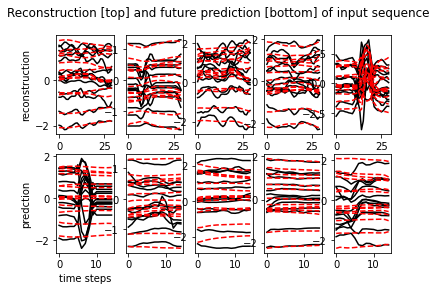

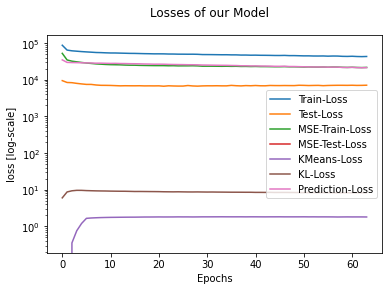

In [3]:
# Evaluate the network

vame.evaluate_model(config)

In [4]:
%%time
# Segment behavior

# vame.behavior_segmentation(config, model_name='VAME_prey_model', cluster_method='kmeans', n_cluster=[30])
vame.pose_segmentation(config)

Pose segmentation for VAME model: VAME 

Using CUDA
GPU active: True
GPU used: GeForce RTX 2080 Ti
Load model... 


  0%|                                                                                                                                                                                                            | 0/4965 [00:00<?, ?it/s]

Embedd latent vector for file 03_17_2021_09_28_35_miniscope_DG_210202_a_habi_nofluo


  1%|██▍                                                                                                                                                                                               | 63/4965 [00:00<00:08, 594.90it/s]

Embedd latent vector for file 08_12_2020_16_12_08_miniscope_DG_200617_b_succ


  1%|██▏                                                                                                                                                                                               | 57/4965 [00:00<00:09, 538.35it/s]

Embedd latent vector for file 06_11_2021_09_51_19_miniscope_DG_210323_b_succ_head


  1%|██▏                                                                                                                                                                                               | 57/4965 [00:00<00:08, 559.88it/s]

Embedd latent vector for file 08_07_2020_16_01_27_miniscope_DG_200701_a_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 503.49it/s]

Embedd latent vector for file 09_08_2020_15_16_25_miniscope_DG_200701_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 593.70it/s]

Embedd latent vector for file 12_03_2019_15_57_28_miniscope_MM_191107_a_succ_nomini


  1%|██                                                                                                                                                                                                | 52/4965 [00:00<00:09, 514.64it/s]

Embedd latent vector for file 08_15_2020_16_34_53_miniscope_DG_200617_b_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 594.72it/s]

Embedd latent vector for file 09_07_2020_15_18_17_miniscope_DG_200617_b_succ


  2%|███▉                                                                                                                                                                                             | 102/4965 [00:00<00:09, 507.07it/s]

Embedd latent vector for file 12_07_2019_15_39_33_miniscope_MM_191108_a_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:08, 546.00it/s]

Embedd latent vector for file 08_16_2020_15_52_46_miniscope_DG_200701_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 595.65it/s]

Embedd latent vector for file 09_01_2020_16_17_14_miniscope_DG_200701_a_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 544.43it/s]

Embedd latent vector for file 08_11_2020_16_03_21_miniscope_DG_200617_b_succ


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 598.22it/s]

Embedd latent vector for file 08_19_2020_16_16_55_miniscope_DG_200701_a_succ_noncon


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:08, 546.01it/s]

Embedd latent vector for file 08_03_2020_16_51_07_miniscope_DG_200617_b_habi_nocricket


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 598.70it/s]

Embedd latent vector for file 04_21_2021_15_15_12_miniscope_DG_210202_a_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 544.93it/s]

Embedd latent vector for file 08_14_2020_15_50_50_miniscope_DG_200617_b_succ


  2%|████▋                                                                                                                                                                                            | 122/4965 [00:00<00:08, 602.76it/s]

Embedd latent vector for file 03_25_2021_09_52_28_miniscope_DG_210202_a_fail_nonres_attempts


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 545.05it/s]

Embedd latent vector for file 08_08_2020_15_47_53_miniscope_DG_200701_a_succ


  1%|██▏                                                                                                                                                                                               | 57/4965 [00:00<00:08, 563.26it/s]

Embedd latent vector for file 08_21_2020_16_08_48_miniscope_DG_200617_b_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 508.26it/s]

Embedd latent vector for file 08_06_2020_18_02_17_miniscope_DG_200701_a_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 545.06it/s]

Embedd latent vector for file 08_19_2020_16_44_52_miniscope_DG_200617_b_succ


  2%|███▉                                                                                                                                                                                             | 102/4965 [00:00<00:09, 506.30it/s]

Embedd latent vector for file 08_11_2020_15_27_09_miniscope_DG_200701_a_succ_injured


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 595.65it/s]

Embedd latent vector for file 03_11_2020_16_42_47_miniscope_MM_200129_b_succ


  2%|████                                                                                                                                                                                             | 104/4965 [00:00<00:09, 517.98it/s]

Embedd latent vector for file 08_06_2020_17_54_57_miniscope_DG_200701_a_succ


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 607.58it/s]

Embedd latent vector for file 03_31_2021_09_45_11_miniscope_DG_210202_a_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 503.51it/s]

Embedd latent vector for file 08_30_2020_15_44_44_miniscope_DG_200701_a_succ


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 599.04it/s]

Embedd latent vector for file 04_23_2021_07_21_14_miniscope_DG_210202_a_succ


  1%|█▉                                                                                                                                                                                                | 49/4965 [00:00<00:10, 480.64it/s]

Embedd latent vector for file 05_10_2021_10_14_34_miniscope_DG_210323_b_fail


  1%|██▎                                                                                                                                                                                               | 59/4965 [00:00<00:08, 589.69it/s]

Embedd latent vector for file 12_02_2019_16_27_33_miniscope_MM_191105_a_fail_nomini


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 503.43it/s]

Embedd latent vector for file 04_01_2021_09_35_49_miniscope_DG_210202_a_succ


  1%|██▏                                                                                                                                                                                               | 56/4965 [00:00<00:08, 552.51it/s]

Embedd latent vector for file 08_08_2020_15_27_33_miniscope_DG_200701_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 599.24it/s]

Embedd latent vector for file 08_09_2020_16_13_20_miniscope_DG_200617_b_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 540.07it/s]

Embedd latent vector for file 04_06_2021_09_58_21_miniscope_DG_210202_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 597.59it/s]

Embedd latent vector for file 08_20_2020_15_43_36_miniscope_DG_200701_a_succ


  1%|██                                                                                                                                                                                                | 54/4965 [00:00<00:09, 537.91it/s]

Embedd latent vector for file 08_11_2020_15_31_17_miniscope_DG_200701_a_succ_injured


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 599.82it/s]

Embedd latent vector for file 12_03_2019_15_24_04_miniscope_MM_191105_a_succ_nomini


  2%|████▎                                                                                                                                                                                            | 110/4965 [00:00<00:09, 539.39it/s]

Embedd latent vector for file 08_30_2020_16_17_16_miniscope_DG_200617_b_succ


  1%|██▌                                                                                                                                                                                               | 67/4965 [00:00<00:08, 606.71it/s]

Embedd latent vector for file 08_09_2020_15_05_48_miniscope_DG_200701_a_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 542.76it/s]

Embedd latent vector for file 09_04_2020_17_11_33_miniscope_DG_200617_b_succ


  2%|████▎                                                                                                                                                                                            | 111/4965 [00:00<00:08, 558.48it/s]

Embedd latent vector for file 04_14_2021_12_43_23_miniscope_DG_210202_a_succ


  1%|██▏                                                                                                                                                                                               | 56/4965 [00:00<00:08, 549.42it/s]

Embedd latent vector for file 04_12_2021_09_31_13_miniscope_DG_210202_a_succ


  2%|████▋                                                                                                                                                                                            | 122/4965 [00:00<00:08, 600.53it/s]

Embedd latent vector for file 08_06_2020_18_46_29_miniscope_DG_200617_b_succ


  1%|██▏                                                                                                                                                                                               | 56/4965 [00:00<00:09, 544.89it/s]

Embedd latent vector for file 04_16_2021_08_47_55_miniscope_DG_210202_a_succ_latestop


  1%|█▋                                                                                                                                                                                                | 43/4965 [00:00<00:11, 424.65it/s]

Embedd latent vector for file 12_07_2019_16_18_20_miniscope_MM_191106_a_succ_nomini


  1%|██                                                                                                                                                                                                | 53/4965 [00:00<00:09, 512.45it/s]

Embedd latent vector for file 04_23_2021_07_24_16_miniscope_DG_210202_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 599.45it/s]

Embedd latent vector for file 12_12_2019_15_27_48_miniscope_MM_191108_a_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 504.20it/s]

Embedd latent vector for file 03_29_2021_09_43_54_miniscope_DG_210202_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.74it/s]

Embedd latent vector for file 09_06_2020_15_35_22_miniscope_DG_200617_b_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 542.79it/s]

Embedd latent vector for file 05_06_2021_10_19_02_miniscope_DG_210323_b_fail_nonres


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.80it/s]

Embedd latent vector for file 05_05_2021_09_45_34_miniscope_DG_210202_a_succ_head


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 504.14it/s]

Embedd latent vector for file 03_11_2020_16_02_24_miniscope_MM_200129_a_succ


  1%|██▋                                                                                                                                                                                               | 69/4965 [00:00<00:08, 610.38it/s]

Embedd latent vector for file 04_13_2021_09_28_41_miniscope_DG_210202_a_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 505.29it/s]

Embedd latent vector for file 09_07_2020_14_51_32_miniscope_DG_200701_a_succ


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 601.62it/s]

Embedd latent vector for file 03_31_2021_09_49_31_miniscope_DG_210202_a_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 502.01it/s]

Embedd latent vector for file 08_29_2020_16_31_16_miniscope_DG_200617_b_succ_injured


  2%|████▊                                                                                                                                                                                            | 123/4965 [00:00<00:07, 611.66it/s]

Embedd latent vector for file 11_14_2019_17_39_46_miniscope_DG_190810_a_succ_nomini


  1%|█▍                                                                                                                                                                                                | 38/4965 [00:00<00:13, 376.06it/s]

Embedd latent vector for file 04_30_2021_09_48_04_miniscope_DG_210202_a_succ_head


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 599.81it/s]

Embedd latent vector for file 08_09_2020_15_44_35_miniscope_DG_200701_a_succ


  1%|█▋                                                                                                                                                                                                | 42/4965 [00:00<00:11, 413.67it/s]

Embedd latent vector for file 12_06_2019_14_21_20_miniscope_MM_191105_a_succ_nomini


  1%|█▋                                                                                                                                                                                                | 42/4965 [00:00<00:11, 419.73it/s]

Embedd latent vector for file 08_20_2020_15_40_41_miniscope_DG_200701_a_succ


  1%|█▌                                                                                                                                                                                                | 41/4965 [00:00<00:12, 404.67it/s]

Embedd latent vector for file 08_06_2020_17_37_15_miniscope_DG_200701_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 597.71it/s]

Embedd latent vector for file 08_30_2020_16_28_07_miniscope_DG_200617_b_succ


  1%|█▉                                                                                                                                                                                                | 50/4965 [00:00<00:09, 499.53it/s]

Embedd latent vector for file 04_26_2021_09_30_05_miniscope_DG_210202_a_succ


  2%|████▊                                                                                                                                                                                            | 123/4965 [00:00<00:07, 610.00it/s]

Embedd latent vector for file 12_04_2019_15_52_05_miniscope_MM_191107_a_succ_nomini


  1%|█▊                                                                                                                                                                                                | 45/4965 [00:00<00:10, 449.58it/s]

Embedd latent vector for file 04_01_2021_09_31_49_miniscope_DG_210202_a_succ_grabbedcable


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 599.78it/s]

Embedd latent vector for file 04_21_2021_15_46_30_miniscope_DG_210202_a_succ


  1%|██                                                                                                                                                                                                | 54/4965 [00:00<00:09, 530.83it/s]

Embedd latent vector for file 12_04_2019_16_53_11_miniscope_MM_191105_a_succ_nomini


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 599.09it/s]

Embedd latent vector for file 11_13_2019_18_19_35_miniscope_DG_190810_a_succ_nomini


  1%|██                                                                                                                                                                                                | 52/4965 [00:00<00:10, 452.16it/s]

Embedd latent vector for file 08_29_2020_16_12_42_miniscope_DG_200701_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 596.41it/s]

Embedd latent vector for file 04_27_2021_10_11_04_miniscope_DG_210323_b_habi_nomini


  1%|█▌                                                                                                                                                                                                | 40/4965 [00:00<00:12, 399.08it/s]

Embedd latent vector for file 08_17_2020_16_22_44_miniscope_DG_200617_b_succ_injured


  2%|████▍                                                                                                                                                                                            | 115/4965 [00:00<00:08, 576.87it/s]

Embedd latent vector for file 09_05_2020_15_50_02_miniscope_DG_200701_a_succ


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 603.89it/s]

Embedd latent vector for file 06_07_2021_09_39_54_miniscope_DG_210323_b_succ_head


  2%|████▋                                                                                                                                                                                            | 121/4965 [00:00<00:08, 599.05it/s]

Embedd latent vector for file 08_21_2020_16_18_56_miniscope_DG_200617_b_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 597.81it/s]

Embedd latent vector for file 05_06_2021_09_38_47_miniscope_DG_210202_a_succ_head_injured


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:08, 549.21it/s]

Embedd latent vector for file 05_05_2021_09_26_05_miniscope_DG_210202_a_succ_head


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 594.46it/s]

Embedd latent vector for file 09_02_2020_17_17_37_miniscope_DG_200617_b_succ


  2%|████▏                                                                                                                                                                                            | 109/4965 [00:00<00:08, 543.76it/s]

Embedd latent vector for file 08_10_2020_16_48_58_miniscope_DG_200701_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 597.50it/s]

Embedd latent vector for file 04_13_2021_09_35_19_miniscope_DG_210202_a_succ


  2%|████▏                                                                                                                                                                                            | 108/4965 [00:00<00:09, 536.33it/s]

Embedd latent vector for file 05_06_2021_09_32_56_miniscope_DG_210202_a_succ_head


  2%|████▋                                                                                                                                                                                            | 120/4965 [00:00<00:08, 597.92it/s]

Embedd latent vector for file 09_03_2020_16_40_53_miniscope_DG_200617_b_succ


  1%|██                                                                                                                                                                                                | 54/4965 [00:00<00:09, 537.39it/s]

Embedd latent vector for file 12_12_2019_15_16_04_miniscope_MM_191108_a_succ


  1%|█▊                                                                                                                                                                                                | 47/4965 [00:00<00:10, 466.04it/s]

Embedd latent vector for file 04_08_2021_09_51_05_miniscope_DG_210202_a_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 543.67it/s]

Embedd latent vector for file 05_10_2021_10_45_08_miniscope_DG_210323_b_fail


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 596.19it/s]

Embedd latent vector for file 11_29_2019_14_43_47_miniscope_MM_191106_a_fail_nomini


  1%|██                                                                                                                                                                                                | 54/4965 [00:00<00:09, 539.59it/s]

Embedd latent vector for file 09_07_2020_14_57_17_miniscope_DG_200701_a_succ


  1%|█▋                                                                                                                                                                                                | 42/4965 [00:00<00:11, 419.30it/s]

Embedd latent vector for file 08_16_2020_16_27_15_miniscope_DG_200617_b_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 543.48it/s]

Embedd latent vector for file 12_06_2019_15_18_15_miniscope_MM_191107_a_succ_nomini


  2%|████▊                                                                                                                                                                                            | 123/4965 [00:00<00:07, 612.51it/s]

Embedd latent vector for file 12_09_2019_16_34_39_miniscope_MM_191105_a_succ_nomini


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 542.80it/s]

Embedd latent vector for file 03_19_2021_07_37_05_miniscope_DG_210202_a_habi_badfluo


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 597.67it/s]

Embedd latent vector for file 09_02_2020_16_55_43_miniscope_DG_200701_a_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 544.29it/s]

Embedd latent vector for file 05_27_2021_10_04_23_miniscope_DG_210323_b_succ_head


  1%|██▋                                                                                                                                                                                               | 70/4965 [00:00<00:08, 607.93it/s]

Embedd latent vector for file 08_06_2020_18_30_31_miniscope_DG_200617_b_succ


  2%|████▏                                                                                                                                                                                            | 108/4965 [00:00<00:09, 539.21it/s]

Embedd latent vector for file 06_07_2021_09_42_58_miniscope_DG_210323_b_succ_head


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 596.07it/s]

Embedd latent vector for file 09_06_2020_15_28_50_miniscope_DG_200617_b_succ


  1%|██▍                                                                                                                                                                                               | 63/4965 [00:00<00:08, 545.53it/s]

Embedd latent vector for file 11_13_2019_17_57_10_miniscope_DG_190806_a_succ_nofluobadtrigger


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 600.67it/s]

Embedd latent vector for file 09_03_2020_16_36_15_miniscope_DG_200617_b_succ


  1%|█▉                                                                                                                                                                                                | 48/4965 [00:00<00:10, 471.79it/s]

Embedd latent vector for file 09_04_2020_17_00_52_miniscope_DG_200617_b_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 596.06it/s]

Embedd latent vector for file 12_11_2019_17_05_25_miniscope_MM_191108_a_succ


  1%|█▉                                                                                                                                                                                                | 50/4965 [00:00<00:09, 498.73it/s]

Embedd latent vector for file 06_08_2021_09_47_21_miniscope_DG_210323_b_succ_head


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.18it/s]

Embedd latent vector for file 09_08_2020_15_10_07_miniscope_DG_200701_a_succ


  1%|█▋                                                                                                                                                                                                | 42/4965 [00:00<00:11, 414.25it/s]

Embedd latent vector for file 12_09_2019_16_30_00_miniscope_MM_191105_a_succ_nomini


  2%|████▋                                                                                                                                                                                            | 120/4965 [00:00<00:08, 594.12it/s]

Embedd latent vector for file 11_14_2019_17_19_46_miniscope_DG_190806_a_succ_nofluo


  1%|█▋                                                                                                                                                                                                | 44/4965 [00:00<00:11, 434.95it/s]

Embedd latent vector for file 12_09_2019_15_21_10_miniscope_MM_191108_a_succ


  1%|██▎                                                                                                                                                                                               | 59/4965 [00:00<00:08, 569.08it/s]

Embedd latent vector for file 08_29_2020_16_08_29_miniscope_DG_200701_a_succ


  1%|█▊                                                                                                                                                                                                | 47/4965 [00:00<00:10, 468.43it/s]

Embedd latent vector for file 08_12_2020_15_56_49_miniscope_DG_200701_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 597.93it/s]

Embedd latent vector for file 06_15_2021_10_08_36_miniscope_DG_210323_b_succ_low_baddark_head


  1%|█▍                                                                                                                                                                                                | 37/4965 [00:00<00:13, 364.76it/s]

Embedd latent vector for file 12_11_2019_16_53_36_miniscope_MM_191108_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 596.74it/s]

Embedd latent vector for file 08_19_2020_15_55_28_miniscope_DG_200701_a_succ_injured


  1%|██▎                                                                                                                                                                                               | 58/4965 [00:00<00:08, 578.21it/s]

Embedd latent vector for file 08_19_2020_16_27_02_miniscope_DG_200617_b_succ


  2%|████▋                                                                                                                                                                                            | 120/4965 [00:00<00:08, 593.35it/s]

Embedd latent vector for file 04_29_2021_07_45_16_miniscope_DG_210202_a_succ_head


  1%|██▎                                                                                                                                                                                               | 58/4965 [00:00<00:08, 577.64it/s]

Embedd latent vector for file 08_08_2020_15_30_48_miniscope_DG_200701_a_succ


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 598.29it/s]

Embedd latent vector for file 11_25_2019_15_49_41_miniscope_MM_191107_a_fail_nomini


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 503.26it/s]

Embedd latent vector for file 03_13_2020_13_53_47_miniscope_MM_200129_b_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 597.20it/s]

Embedd latent vector for file 05_17_2021_10_03_28_miniscope_DG_210323_b_succ_noncon


  1%|██▏                                                                                                                                                                                               | 57/4965 [00:00<00:08, 561.78it/s]

Embedd latent vector for file 03_02_2020_16_20_39_miniscope_MM_200129_b_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.97it/s]

Embedd latent vector for file 08_14_2020_15_09_52_miniscope_DG_200701_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 591.65it/s]

Embedd latent vector for file 12_04_2019_16_27_21_miniscope_MM_191108_a_succ_nomini


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 597.62it/s]

Embedd latent vector for file 08_30_2020_16_14_23_miniscope_DG_200617_b_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 596.67it/s]

Embedd latent vector for file 04_09_2021_07_04_10_miniscope_DG_210202_a_succ_injured


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 540.66it/s]

Embedd latent vector for file 06_09_2021_10_06_13_miniscope_DG_210323_b_succ_head


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 597.59it/s]

Embedd latent vector for file 08_19_2020_16_09_08_miniscope_DG_200701_a_succ


  1%|██                                                                                                                                                                                                | 54/4965 [00:00<00:09, 539.32it/s]

Embedd latent vector for file 06_17_2021_10_39_40_miniscope_DG_210323_b_succ_dark_head


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 591.43it/s]

Embedd latent vector for file 08_09_2020_14_59_34_miniscope_DG_200701_a_succ_injured


  1%|██                                                                                                                                                                                                | 54/4965 [00:00<00:09, 538.17it/s]

Embedd latent vector for file 11_29_2019_15_08_11_miniscope_MM_191107_a_fail_nomini


  1%|██▏                                                                                                                                                                                               | 57/4965 [00:00<00:08, 551.27it/s]

Embedd latent vector for file 08_21_2020_15_42_56_miniscope_DG_200701_a_succ


  1%|█▊                                                                                                                                                                                                | 46/4965 [00:00<00:10, 458.79it/s]

Embedd latent vector for file 03_06_2020_15_49_03_miniscope_MM_200129_a_succ


  2%|███▌                                                                                                                                                                                              | 90/4965 [00:00<00:10, 446.78it/s]

Embedd latent vector for file 12_07_2019_15_24_53_miniscope_MM_191108_a_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 545.01it/s]

Embedd latent vector for file 12_03_2019_16_48_22_miniscope_MM_191108_a_succ_nomini


  2%|████▎                                                                                                                                                                                            | 111/4965 [00:00<00:08, 553.57it/s]

Embedd latent vector for file 09_05_2020_16_16_21_miniscope_DG_200617_b_succ


  1%|█▋                                                                                                                                                                                                | 44/4965 [00:00<00:11, 428.34it/s]

Embedd latent vector for file 08_13_2020_16_21_12_miniscope_DG_200617_b_succ_injured


  2%|████▋                                                                                                                                                                                            | 120/4965 [00:00<00:08, 593.66it/s]

Embedd latent vector for file 08_19_2020_16_35_29_miniscope_DG_200617_b_succ_injured


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 539.31it/s]

Embedd latent vector for file 12_12_2019_15_00_56_miniscope_MM_191108_a_succ


  2%|████▋                                                                                                                                                                                            | 121/4965 [00:00<00:08, 598.01it/s]

Embedd latent vector for file 08_11_2020_15_47_26_miniscope_DG_200617_b_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 543.15it/s]

Embedd latent vector for file 03_31_2021_09_35_52_miniscope_DG_210202_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 594.07it/s]

Embedd latent vector for file 05_03_2021_09_43_13_miniscope_DG_210202_a_succ_head


  1%|██                                                                                                                                                                                                | 54/4965 [00:00<00:09, 538.62it/s]

Embedd latent vector for file 04_09_2021_07_17_14_miniscope_DG_210202_a_succ_distracted


  1%|██▋                                                                                                                                                                                               | 69/4965 [00:00<00:08, 605.17it/s]

Embedd latent vector for file 09_01_2020_16_34_42_miniscope_DG_200617_b_succ


  1%|██                                                                                                                                                                                                | 54/4965 [00:00<00:09, 537.66it/s]

Embedd latent vector for file 03_13_2020_13_25_36_miniscope_MM_200129_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 599.51it/s]

Embedd latent vector for file 03_17_2021_09_21_23_miniscope_DG_210202_a_habi_nofluo


  1%|██▍                                                                                                                                                                                               | 62/4965 [00:00<00:08, 547.22it/s]

Embedd latent vector for file 06_01_2021_09_55_17_miniscope_DG_210323_b_succ_head


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 607.76it/s]

Embedd latent vector for file 08_17_2020_15_38_44_miniscope_DG_200701_a_succ


  2%|████▎                                                                                                                                                                                            | 110/4965 [00:00<00:08, 540.76it/s]

Embedd latent vector for file 04_22_2021_09_21_54_miniscope_DG_210202_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 597.72it/s]

Embedd latent vector for file 08_15_2020_16_02_16_miniscope_DG_200701_a_succ


  1%|██                                                                                                                                                                                                | 54/4965 [00:00<00:09, 538.70it/s]

Embedd latent vector for file 05_17_2021_09_29_34_miniscope_DG_210323_b_fail


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 599.25it/s]

Embedd latent vector for file 08_20_2020_16_06_26_miniscope_DG_200701_a_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 543.59it/s]

Embedd latent vector for file 03_04_2020_16_12_03_miniscope_MM_200129_b_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 597.63it/s]

Embedd latent vector for file 09_08_2020_15_26_21_miniscope_DG_200701_a_succ


  2%|████▍                                                                                                                                                                                            | 114/4965 [00:00<00:08, 567.97it/s]

Embedd latent vector for file 03_22_2021_09_32_34_miniscope_DG_210202_a_habi_smallfluo


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 502.87it/s]

Embedd latent vector for file 05_28_2021_09_43_46_miniscope_DG_210323_b_succ_head


  1%|█▉                                                                                                                                                                                                | 50/4965 [00:00<00:09, 499.55it/s]

Embedd latent vector for file 03_05_2020_15_32_18_miniscope_MM_200129_a_succ


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 600.86it/s]

Embedd latent vector for file 03_29_2021_10_13_07_miniscope_DG_210202_a_succ


  1%|██▎                                                                                                                                                                                               | 59/4965 [00:00<00:08, 579.87it/s]

Embedd latent vector for file 09_04_2020_16_49_06_miniscope_DG_200701_a_succ_injured


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 595.19it/s]

Embedd latent vector for file 05_05_2021_09_39_47_miniscope_DG_210202_a_succ_head


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 501.84it/s]

Embedd latent vector for file 04_16_2021_08_55_41_miniscope_DG_210202_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.65it/s]

Embedd latent vector for file 08_10_2020_17_33_00_miniscope_DG_200617_b_succ


  1%|█▎                                                                                                                                                                                                | 32/4965 [00:00<00:15, 319.33it/s]

Embedd latent vector for file 09_08_2020_15_03_49_miniscope_DG_200701_a_succ_nomini


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 596.02it/s]

Embedd latent vector for file 12_09_2019_16_41_05_miniscope_MM_191105_a_succ_nomini


  1%|██▏                                                                                                                                                                                               | 56/4965 [00:00<00:08, 550.08it/s]

Embedd latent vector for file 08_09_2020_14_55_56_miniscope_DG_200701_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 596.06it/s]

Embedd latent vector for file 03_24_2021_13_38_36_miniscope_DG_210202_a_fail_nonres


  1%|█▋                                                                                                                                                                                                | 42/4965 [00:00<00:11, 419.11it/s]

Embedd latent vector for file 03_12_2020_16_32_46_miniscope_MM_200129_a_succ


  2%|████▋                                                                                                                                                                                            | 122/4965 [00:00<00:07, 610.57it/s]

Embedd latent vector for file 05_12_2021_09_52_47_miniscope_DG_210323_b_succ_head_hyperactive


  1%|█▌                                                                                                                                                                                                | 40/4965 [00:00<00:12, 390.91it/s]

Embedd latent vector for file 12_07_2019_15_52_11_miniscope_MM_191108_a_succ


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 599.04it/s]

Embedd latent vector for file 04_01_2021_09_59_45_miniscope_DG_210202_a_succ_injured


  1%|█▍                                                                                                                                                                                                | 37/4965 [00:00<00:13, 368.85it/s]

Embedd latent vector for file 08_10_2020_16_44_58_miniscope_DG_200701_a_succ


  2%|████▋                                                                                                                                                                                            | 120/4965 [00:00<00:08, 597.99it/s]

Embedd latent vector for file 04_05_2021_10_32_20_miniscope_DG_210202_a_succ


  1%|█▉                                                                                                                                                                                                | 49/4965 [00:00<00:10, 485.36it/s]

Embedd latent vector for file 08_21_2020_15_36_39_miniscope_DG_200701_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 595.08it/s]

Embedd latent vector for file 04_26_2021_09_49_24_miniscope_DG_210202_a_succ


  1%|█▉                                                                                                                                                                                                | 50/4965 [00:00<00:09, 499.02it/s]

Embedd latent vector for file 06_14_2021_11_53_28_miniscope_DG_210323_b_succ_low_head_baddark


  1%|██▌                                                                                                                                                                                               | 64/4965 [00:00<00:08, 606.71it/s]

Embedd latent vector for file 04_27_2021_09_37_28_miniscope_DG_210202_a_succ


  1%|█▌                                                                                                                                                                                                | 41/4965 [00:00<00:12, 407.52it/s]

Embedd latent vector for file 09_04_2020_17_23_03_miniscope_DG_200617_b_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 591.50it/s]

Embedd latent vector for file 04_08_2021_09_55_39_miniscope_DG_210202_a_succ


  1%|█▎                                                                                                                                                                                                | 35/4965 [00:00<00:14, 342.94it/s]

Embedd latent vector for file 11_11_2019_23_07_55_miniscope_DG_190806_a_fail_nofluo


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.90it/s]

Embedd latent vector for file 12_07_2019_16_38_08_miniscope_MM_191107_a_succ_nomini


  1%|█▉                                                                                                                                                                                                | 48/4965 [00:00<00:10, 475.47it/s]

Embedd latent vector for file 06_15_2021_10_00_34_miniscope_DG_210323_b_fail_low_baddark


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 597.76it/s]

Embedd latent vector for file 04_09_2021_07_09_17_miniscope_DG_210202_a_succ


  1%|██                                                                                                                                                                                                | 52/4965 [00:00<00:09, 514.03it/s]

Embedd latent vector for file 05_12_2021_09_46_26_miniscope_DG_210323_b_succ_head


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 591.30it/s]

Embedd latent vector for file 03_10_2020_15_52_35_miniscope_MM_200129_a_succ


  1%|█▉                                                                                                                                                                                                | 50/4965 [00:00<00:09, 495.48it/s]

Embedd latent vector for file 09_07_2020_14_48_19_miniscope_DG_200701_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 596.82it/s]

Embedd latent vector for file 05_05_2021_10_40_59_miniscope_DG_210323_b_fail_nonres


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 599.02it/s]

Embedd latent vector for file 06_02_2021_09_50_52_miniscope_DG_210323_b_succ_head


  1%|██▏                                                                                                                                                                                               | 57/4965 [00:00<00:08, 550.49it/s]

Embedd latent vector for file 05_17_2021_09_51_23_miniscope_DG_210323_b_succ_head


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 599.19it/s]

Embedd latent vector for file 05_04_2021_09_37_07_miniscope_DG_210202_a_succ_head


  1%|█▋                                                                                                                                                                                                | 44/4965 [00:00<00:11, 428.69it/s]

Embedd latent vector for file 05_28_2021_09_58_47_miniscope_DG_210323_b_succ_head


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 593.12it/s]

Embedd latent vector for file 03_18_2021_09_45_56_miniscope_DG_210202_a_habi_badfov


  1%|██                                                                                                                                                                                                | 54/4965 [00:00<00:09, 539.95it/s]

Embedd latent vector for file 12_07_2019_15_06_28_miniscope_MM_191108_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 595.65it/s]

Embedd latent vector for file 08_03_2020_16_05_59_miniscope_DG_200701_a_habi_nocricket


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 543.96it/s]

Embedd latent vector for file 04_09_2021_07_14_09_miniscope_DG_210202_a_succ_injured


  1%|██▌                                                                                                                                                                                               | 65/4965 [00:00<00:08, 604.03it/s]

Embedd latent vector for file 12_09_2019_15_16_05_miniscope_MM_191108_a_succ


  1%|██                                                                                                                                                                                                | 54/4965 [00:00<00:09, 537.90it/s]

Embedd latent vector for file 04_06_2021_09_40_26_miniscope_DG_210202_a_succ_injured


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.01it/s]

Embedd latent vector for file 09_01_2020_16_43_46_miniscope_DG_200617_b_succ


  1%|██▏                                                                                                                                                                                               | 56/4965 [00:00<00:08, 550.01it/s]

Embedd latent vector for file 04_27_2021_09_43_37_miniscope_DG_210202_a_succ


  2%|████▋                                                                                                                                                                                            | 120/4965 [00:00<00:08, 598.04it/s]

Embedd latent vector for file 12_04_2019_15_29_28_miniscope_MM_191106_a_succ_nomini


  1%|█▊                                                                                                                                                                                                | 47/4965 [00:00<00:10, 463.41it/s]

Embedd latent vector for file 11_11_2019_23_35_36_miniscope_DG_190810_a_succ_nomini


  2%|████▋                                                                                                                                                                                            | 122/4965 [00:00<00:07, 610.19it/s]

Embedd latent vector for file 09_08_2020_15_13_51_miniscope_DG_200701_a_succ


  2%|████▎                                                                                                                                                                                            | 110/4965 [00:00<00:08, 541.18it/s]

Embedd latent vector for file 08_14_2020_15_54_58_miniscope_DG_200617_b_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 597.59it/s]

Embedd latent vector for file 08_18_2020_15_59_09_miniscope_DG_200701_a_succ


  1%|██                                                                                                                                                                                                | 54/4965 [00:00<00:09, 538.34it/s]

Embedd latent vector for file 03_22_2021_09_26_19_miniscope_DG_210202_a_habi_smallfluo


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 600.89it/s]

Embedd latent vector for file 04_28_2021_10_01_30_miniscope_DG_210323_b_habi_badfluo


  1%|██                                                                                                                                                                                                | 54/4965 [00:00<00:09, 537.90it/s]

Embedd latent vector for file 05_12_2021_10_09_24_miniscope_DG_210323_b_succ_head


  2%|████▋                                                                                                                                                                                            | 120/4965 [00:00<00:08, 594.62it/s]

Embedd latent vector for file 03_31_2021_09_38_46_miniscope_DG_210202_a_succ


  1%|██                                                                                                                                                                                                | 54/4965 [00:00<00:09, 537.87it/s]

Embedd latent vector for file 08_06_2020_18_07_32_miniscope_DG_200701_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 591.40it/s]

Embedd latent vector for file 11_26_2019_15_44_01_miniscope_MM_191106_a_fail_nomini


  1%|██                                                                                                                                                                                                | 54/4965 [00:00<00:09, 539.34it/s]

Embedd latent vector for file 09_05_2020_15_40_48_miniscope_DG_200701_a_succ_injured


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 599.00it/s]

Embedd latent vector for file 03_02_2020_15_50_05_miniscope_MM_200129_a_succ


  1%|██▏                                                                                                                                                                                               | 57/4965 [00:00<00:08, 566.57it/s]

Embedd latent vector for file 08_11_2020_15_12_33_miniscope_DG_200701_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 596.46it/s]

Embedd latent vector for file 08_31_2020_15_59_34_miniscope_DG_200701_a_succ


  2%|███▍                                                                                                                                                                                              | 89/4965 [00:00<00:10, 453.05it/s]

Embedd latent vector for file 08_18_2020_16_01_32_miniscope_DG_200701_a_succ_injured


  1%|██▌                                                                                                                                                                                               | 65/4965 [00:00<00:08, 604.65it/s]

Embedd latent vector for file 09_04_2020_17_17_48_miniscope_DG_200617_b_succ


  1%|██                                                                                                                                                                                                | 54/4965 [00:00<00:09, 538.35it/s]

Embedd latent vector for file 06_09_2021_09_45_47_miniscope_DG_210323_b_succ_head


  1%|██▎                                                                                                                                                                                               | 59/4965 [00:00<00:08, 567.16it/s]

Embedd latent vector for file 12_07_2019_16_34_28_miniscope_MM_191107_a_succ_nomini


  1%|█▌                                                                                                                                                                                                | 41/4965 [00:00<00:12, 409.44it/s]

Embedd latent vector for file 06_11_2021_10_06_45_miniscope_DG_210323_b_habi


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.26it/s]

Embedd latent vector for file 05_25_2021_09_55_03_miniscope_DG_210323_b_succ_head


  1%|█▊                                                                                                                                                                                                | 45/4965 [00:00<00:11, 443.71it/s]

Embedd latent vector for file 08_05_2020_16_20_09_miniscope_DG_200617_b_succ


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 600.04it/s]

Embedd latent vector for file 09_05_2020_16_19_09_miniscope_DG_200617_b_succ


  1%|█▌                                                                                                                                                                                                | 39/4965 [00:00<00:12, 384.85it/s]

Embedd latent vector for file 04_06_2021_10_09_13_miniscope_DG_210202_a_succ_injured


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.75it/s]

Embedd latent vector for file 04_12_2021_09_34_13_miniscope_DG_210202_a_succ


  2%|████                                                                                                                                                                                             | 103/4965 [00:00<00:09, 513.18it/s]

Embedd latent vector for file 04_28_2021_09_41_07_miniscope_DG_210202_a_succ_head


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.12it/s]

Embedd latent vector for file 04_08_2021_10_14_04_miniscope_DG_210202_a_succ


  1%|█▌                                                                                                                                                                                                | 41/4965 [00:00<00:12, 405.07it/s]

Embedd latent vector for file 08_30_2020_15_56_29_miniscope_DG_200701_a_succ


  2%|████▊                                                                                                                                                                                            | 123/4965 [00:00<00:07, 609.49it/s]

Embedd latent vector for file 05_31_2021_11_09_06_miniscope_DG_210323_b_succ_head


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 503.36it/s]

Embedd latent vector for file 11_14_2019_17_46_42_miniscope_DG_190810_a_succ_nomini


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 597.71it/s]

Embedd latent vector for file 03_11_2020_16_14_11_miniscope_MM_200129_a_succ


  1%|██                                                                                                                                                                                                | 52/4965 [00:00<00:09, 512.58it/s]

Embedd latent vector for file 08_09_2020_16_03_39_miniscope_DG_200617_b_succ


  2%|████▋                                                                                                                                                                                            | 122/4965 [00:00<00:08, 599.26it/s]

Embedd latent vector for file 05_28_2021_10_02_39_miniscope_DG_210323_b_succ_head


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 555.71it/s]

Embedd latent vector for file 12_07_2019_15_20_56_miniscope_MM_191108_a_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 543.99it/s]

Embedd latent vector for file 08_19_2020_15_51_39_miniscope_DG_200701_a_succ_injured


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 507.14it/s]

Embedd latent vector for file 08_31_2020_16_32_34_miniscope_DG_200617_b_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:08, 549.17it/s]

Embedd latent vector for file 04_02_2021_10_10_35_miniscope_DG_210202_a_succ


  1%|██▋                                                                                                                                                                                               | 68/4965 [00:00<00:08, 610.58it/s]

Embedd latent vector for file 08_21_2020_16_28_13_miniscope_DG_200617_b_succ


  1%|██                                                                                                                                                                                                | 52/4965 [00:00<00:09, 519.70it/s]

Embedd latent vector for file 06_14_2021_11_22_15_miniscope_DG_210323_b_succ_dark_nofluo_debris_head


  1%|██▋                                                                                                                                                                                               | 69/4965 [00:00<00:08, 605.25it/s]

Embedd latent vector for file 08_18_2020_16_15_09_miniscope_DG_200701_a_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 507.78it/s]

Embedd latent vector for file 04_14_2021_12_46_52_miniscope_DG_210202_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 597.49it/s]

Embedd latent vector for file 11_29_2019_15_49_40_miniscope_MM_191108_a_fail_nomini


  1%|█▉                                                                                                                                                                                                | 50/4965 [00:00<00:09, 495.17it/s]

Embedd latent vector for file 08_31_2020_16_01_53_miniscope_DG_200701_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 574.39it/s]

Embedd latent vector for file 04_28_2021_10_08_25_miniscope_DG_210323_b_habi_badfluo


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 503.47it/s]

Embedd latent vector for file 09_08_2020_15_23_32_miniscope_DG_200701_a_succ


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 598.29it/s]

Embedd latent vector for file 08_05_2020_15_55_12_miniscope_DG_200617_b_succ


  2%|████                                                                                                                                                                                             | 104/4965 [00:00<00:09, 517.08it/s]

Embedd latent vector for file 05_10_2021_10_59_09_miniscope_DG_210323_b_fail


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.51it/s]

Embedd latent vector for file 11_14_2019_17_24_28_miniscope_DG_190806_a_succ_nofluo


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 508.08it/s]

Embedd latent vector for file 06_10_2021_10_24_12_miniscope_DG_210323_b_succ_head


  1%|█▊                                                                                                                                                                                                | 47/4965 [00:00<00:10, 467.77it/s]

Embedd latent vector for file 12_07_2019_16_05_30_miniscope_MM_191105_a_succ_nomini


  2%|████▋                                                                                                                                                                                            | 121/4965 [00:00<00:08, 601.14it/s]

Embedd latent vector for file 03_13_2020_13_49_34_miniscope_MM_200129_b_succ


  2%|████▎                                                                                                                                                                                            | 110/4965 [00:00<00:08, 545.36it/s]

Embedd latent vector for file 04_23_2021_07_07_28_miniscope_DG_210202_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 599.41it/s]

Embedd latent vector for file 08_10_2020_16_34_57_miniscope_DG_200701_a_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:08, 547.88it/s]

Embedd latent vector for file 05_17_2021_09_38_56_miniscope_DG_210323_b_succ_head


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.32it/s]

Embedd latent vector for file 06_04_2021_10_26_21_miniscope_DG_210323_b_succ_head


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 543.32it/s]

Embedd latent vector for file 12_09_2019_16_46_19_miniscope_MM_191106_a_succ_nomini


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 602.01it/s]

Embedd latent vector for file 11_11_2019_22_48_32_miniscope_DG_190806_a_fail_nofluo


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:08, 547.86it/s]

Embedd latent vector for file 08_08_2020_16_18_51_miniscope_DG_200617_b_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.78it/s]

Embedd latent vector for file 03_04_2020_16_16_18_miniscope_MM_200129_b_succ


  2%|███▉                                                                                                                                                                                             | 102/4965 [00:00<00:09, 503.72it/s]

Embedd latent vector for file 05_25_2021_09_43_20_miniscope_DG_210323_b_succ_head


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 574.69it/s]

Embedd latent vector for file 08_06_2020_18_35_22_miniscope_DG_200617_b_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 505.38it/s]

Embedd latent vector for file 04_01_2021_09_55_30_miniscope_DG_210202_a_succ


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 604.02it/s]

Embedd latent vector for file 05_05_2021_10_20_30_miniscope_DG_210323_b_fail_nonres


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:09, 521.09it/s]

Embedd latent vector for file 11_29_2019_15_30_55_miniscope_MM_191107_a_fail_nomini


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 593.27it/s]

Embedd latent vector for file 06_11_2021_10_36_46_miniscope_DG_210323_b_habi


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 505.35it/s]

Embedd latent vector for file 09_06_2020_15_02_17_miniscope_DG_200701_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 571.63it/s]

Embedd latent vector for file 11_12_2019_17_14_20_miniscope_DG_190810_a_succ_nomini


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 508.85it/s]

Embedd latent vector for file 05_04_2021_09_26_54_miniscope_DG_210202_a_succ_head


  1%|█▋                                                                                                                                                                                                | 44/4965 [00:00<00:11, 434.01it/s]

Embedd latent vector for file 12_07_2019_16_09_54_miniscope_MM_191105_a_succ_nomini


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 507.54it/s]

Embedd latent vector for file 08_21_2020_15_34_25_miniscope_DG_200701_a_succ_injured


  1%|█▉                                                                                                                                                                                                | 49/4965 [00:00<00:10, 472.20it/s]

Embedd latent vector for file 11_26_2019_16_26_36_miniscope_MM_191107_a_fail_nomini


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 504.34it/s]

Embedd latent vector for file 06_18_2021_13_43_26_miniscope_DG_210323_b_succ_head


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.05it/s]

Embedd latent vector for file 05_27_2021_09_47_19_miniscope_DG_210323_b_succ_head


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 599.35it/s]

Embedd latent vector for file 06_09_2021_09_49_26_miniscope_DG_210323_b_succ_head


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:08, 548.01it/s]

Embedd latent vector for file 04_28_2021_09_24_14_miniscope_DG_210202_a_succ


  1%|█▉                                                                                                                                                                                                | 48/4965 [00:00<00:11, 420.39it/s]

Embedd latent vector for file 05_03_2021_09_22_13_miniscope_DG_210202_a_succ_head


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 542.48it/s]

Embedd latent vector for file 04_30_2021_09_22_31_miniscope_DG_210323_b_habi


  1%|██▎                                                                                                                                                                                               | 58/4965 [00:00<00:08, 566.51it/s]

Embedd latent vector for file 09_05_2020_16_12_58_miniscope_DG_200617_b_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:08, 547.98it/s]

Embedd latent vector for file 12_02_2019_16_05_42_miniscope_MM_191105_a_fail_nomini


  1%|██▎                                                                                                                                                                                               | 59/4965 [00:00<00:08, 566.48it/s]

Embedd latent vector for file 08_30_2020_16_20_40_miniscope_DG_200617_b_succ


  2%|████▎                                                                                                                                                                                            | 110/4965 [00:00<00:08, 544.72it/s]

Embedd latent vector for file 11_29_2019_14_57_47_miniscope_MM_191106_a_fail_nomini


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 502.03it/s]

Embedd latent vector for file 12_03_2019_16_11_31_miniscope_MM_191106_a_succ_nomini


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 505.34it/s]

Embedd latent vector for file 07_31_2020_16_44_36_miniscope_DG_200617_b_habi_nocricket_nomini


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 591.43it/s]

Embedd latent vector for file 04_09_2021_07_23_52_miniscope_DG_210202_a_succ_distracted


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 509.57it/s]

Embedd latent vector for file 09_03_2020_16_28_25_miniscope_DG_200617_b_succ


  1%|█▉                                                                                                                                                                                                | 50/4965 [00:00<00:09, 496.22it/s]

Embedd latent vector for file 04_08_2021_09_58_40_miniscope_DG_210202_a_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 505.36it/s]

Embedd latent vector for file 04_09_2021_07_07_05_miniscope_DG_210202_a_succ


  2%|████▋                                                                                                                                                                                            | 120/4965 [00:00<00:08, 598.62it/s]

Embedd latent vector for file 12_12_2019_15_04_45_miniscope_MM_191108_a_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 504.43it/s]

Embedd latent vector for file 08_12_2020_16_30_56_miniscope_DG_200617_b_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 599.37it/s]

Embedd latent vector for file 09_03_2020_16_43_43_miniscope_DG_200617_b_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 507.75it/s]

Embedd latent vector for file 08_17_2020_16_12_24_miniscope_DG_200617_b_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 599.30it/s]

Embedd latent vector for file 08_12_2020_16_14_41_miniscope_DG_200617_b_succ


  1%|█▋                                                                                                                                                                                                | 44/4965 [00:00<00:11, 436.48it/s]

Embedd latent vector for file 04_27_2021_10_25_13_miniscope_DG_210323_b_habi_nomini


  2%|████▎                                                                                                                                                                                            | 110/4965 [00:00<00:08, 544.50it/s]

Embedd latent vector for file 05_11_2021_09_29_01_miniscope_DG_210323_b_fail


  1%|██▌                                                                                                                                                                                               | 67/4965 [00:00<00:08, 605.43it/s]

Embedd latent vector for file 08_19_2020_16_05_59_miniscope_DG_200701_a_succ_grabbedcable


  1%|██                                                                                                                                                                                                | 54/4965 [00:00<00:09, 539.32it/s]

Embedd latent vector for file 08_18_2020_16_28_42_miniscope_DG_200617_b_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 599.39it/s]

Embedd latent vector for file 09_06_2020_15_43_13_miniscope_DG_200617_b_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 543.97it/s]

Embedd latent vector for file 08_07_2020_16_39_29_miniscope_DG_200617_b_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.70it/s]

Embedd latent vector for file 08_09_2020_15_48_25_miniscope_DG_200701_a_succ_nomini


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:08, 548.85it/s]

Embedd latent vector for file 09_01_2020_16_03_24_miniscope_DG_200701_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.14it/s]

Embedd latent vector for file 06_11_2021_09_48_42_miniscope_DG_210323_b_succ_head


  2%|███▉                                                                                                                                                                                             | 101/4965 [00:00<00:09, 502.24it/s]

Embedd latent vector for file 03_05_2020_15_35_45_miniscope_MM_200129_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 592.21it/s]

Embedd latent vector for file 11_14_2019_17_50_12_miniscope_DG_190810_a_succ_nomini


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 503.53it/s]

Embedd latent vector for file 07_31_2020_16_51_20_miniscope_DG_200617_b_habi_nocricket_nomini


  1%|██▌                                                                                                                                                                                               | 65/4965 [00:00<00:08, 606.36it/s]

Embedd latent vector for file 09_04_2020_17_14_08_miniscope_DG_200617_b_succ


  1%|█▌                                                                                                                                                                                                | 41/4965 [00:00<00:12, 407.12it/s]

Embedd latent vector for file 04_29_2021_07_29_23_miniscope_DG_210202_a_succ


  1%|█▋                                                                                                                                                                                                | 42/4965 [00:00<00:11, 415.62it/s]

Embedd latent vector for file 08_12_2020_16_24_56_miniscope_DG_200617_b_succ


  1%|█▌                                                                                                                                                                                                | 39/4965 [00:00<00:13, 365.34it/s]

Embedd latent vector for file 06_04_2021_10_13_58_miniscope_DG_210323_b_succ_head


  1%|██▏                                                                                                                                                                                               | 56/4965 [00:00<00:09, 506.17it/s]

Embedd latent vector for file 05_25_2021_10_00_11_miniscope_DG_210323_b_succ_head


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 507.66it/s]

Embedd latent vector for file 12_11_2019_17_09_52_miniscope_MM_191108_a_succ


  1%|█▋                                                                                                                                                                                                | 44/4965 [00:00<00:11, 434.45it/s]

Embedd latent vector for file 08_14_2020_15_57_32_miniscope_DG_200617_b_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 503.24it/s]

Embedd latent vector for file 12_04_2019_16_01_30_miniscope_MM_191107_a_succ_nomini


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.40it/s]

Embedd latent vector for file 08_31_2020_15_41_54_miniscope_DG_200701_a_succ


  2%|███▉                                                                                                                                                                                             | 102/4965 [00:00<00:09, 505.24it/s]

Embedd latent vector for file 11_26_2019_16_39_57_miniscope_MM_191107_a_fail_nomini


  2%|████▏                                                                                                                                                                                            | 108/4965 [00:00<00:08, 546.53it/s]

Embedd latent vector for file 08_15_2020_15_41_21_miniscope_DG_200701_a_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 504.60it/s]

Embedd latent vector for file 04_13_2021_09_22_44_miniscope_DG_210202_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.13it/s]

Embedd latent vector for file 08_31_2020_16_05_52_miniscope_DG_200701_a_succ


  1%|█▉                                                                                                                                                                                                | 48/4965 [00:00<00:10, 478.89it/s]

Embedd latent vector for file 09_02_2020_16_37_35_miniscope_DG_200701_a_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:08, 548.29it/s]

Embedd latent vector for file 08_06_2020_17_47_03_miniscope_DG_200701_a_fail


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 599.07it/s]

Embedd latent vector for file 08_15_2020_16_22_29_miniscope_DG_200617_b_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:08, 548.20it/s]

Embedd latent vector for file 06_18_2021_13_54_19_miniscope_DG_210323_b_succ_dark_head


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.65it/s]

Embedd latent vector for file 05_07_2021_09_50_11_miniscope_DG_210202_a_succ_head


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 543.15it/s]

Embedd latent vector for file 04_02_2021_10_03_36_miniscope_DG_210202_a_succ


  1%|█▋                                                                                                                                                                                                | 43/4965 [00:00<00:11, 429.56it/s]

Embedd latent vector for file 04_02_2021_10_06_47_miniscope_DG_210202_a_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 543.18it/s]

Embedd latent vector for file 04_21_2021_15_50_50_miniscope_DG_210202_a_succ


  1%|██▍                                                                                                                                                                                               | 62/4965 [00:00<00:08, 610.70it/s]

Embedd latent vector for file 08_07_2020_16_28_48_miniscope_DG_200701_a_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 543.50it/s]

Embedd latent vector for file 11_12_2019_16_50_34_miniscope_DG_190806_a_succ_nofluo


  2%|████▌                                                                                                                                                                                            | 118/4965 [00:00<00:08, 584.79it/s]

Embedd latent vector for file 08_12_2020_15_44_23_miniscope_DG_200701_a_succ_noncon


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 504.25it/s]

Embedd latent vector for file 05_28_2021_09_47_52_miniscope_DG_210323_b_succ_head


  1%|██                                                                                                                                                                                                | 53/4965 [00:00<00:09, 523.37it/s]

Embedd latent vector for file 05_04_2021_09_46_01_miniscope_DG_210202_a_succ_head


  1%|█▋                                                                                                                                                                                                | 44/4965 [00:00<00:11, 433.39it/s]

Embedd latent vector for file 09_02_2020_17_32_19_miniscope_DG_200617_b_succ


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 601.38it/s]

Embedd latent vector for file 08_15_2020_16_05_59_miniscope_DG_200701_a_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 503.30it/s]

Embedd latent vector for file 08_20_2020_15_54_48_miniscope_DG_200701_a_succ


  1%|█▎                                                                                                                                                                                                | 32/4965 [00:00<00:15, 316.05it/s]

Embedd latent vector for file 08_03_2020_16_21_24_miniscope_DG_200701_a_habi_nocricket


  1%|█▎                                                                                                                                                                                                | 34/4965 [00:00<00:14, 334.13it/s]

Embedd latent vector for file 03_04_2020_15_42_07_miniscope_MM_200129_a_succ


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 601.28it/s]

Embedd latent vector for file 04_15_2021_10_39_38_miniscope_DG_210202_a_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 504.29it/s]

Embedd latent vector for file 06_02_2021_09_48_32_miniscope_DG_210323_b_succ_head


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.14it/s]

Embedd latent vector for file 12_09_2019_15_04_06_miniscope_MM_191108_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.01it/s]

Embedd latent vector for file 08_04_2020_15_43_15_miniscope_DG_200617_b_habi_nocricket


  2%|███▉                                                                                                                                                                                             | 101/4965 [00:00<00:09, 507.15it/s]

Embedd latent vector for file 04_06_2021_09_53_32_miniscope_DG_210202_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.33it/s]

Embedd latent vector for file 11_12_2019_16_54_56_miniscope_DG_190806_a_succ_nofluo


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 542.55it/s]

Embedd latent vector for file 04_15_2021_10_44_17_miniscope_DG_210202_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.26it/s]

Embedd latent vector for file 06_03_2021_11_01_42_miniscope_DG_210323_b_succ_head


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:08, 548.10it/s]

Embedd latent vector for file 11_25_2019_16_04_36_miniscope_MM_191107_a_fail_nomini


  2%|████▋                                                                                                                                                                                            | 120/4965 [00:00<00:08, 595.61it/s]

Embedd latent vector for file 08_17_2020_15_34_07_miniscope_DG_200701_a_succ_injured


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 544.04it/s]

Embedd latent vector for file 11_29_2019_14_03_19_miniscope_MM_191105_a_fail_nomini


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 599.34it/s]

Embedd latent vector for file 08_16_2020_16_13_04_miniscope_DG_200617_b_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 503.46it/s]

Embedd latent vector for file 08_09_2020_16_23_45_miniscope_DG_200617_b_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 507.50it/s]

Embedd latent vector for file 03_29_2021_09_49_44_miniscope_DG_210202_a_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 509.14it/s]

Embedd latent vector for file 03_06_2020_16_17_02_miniscope_MM_200129_b_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 599.35it/s]

Embedd latent vector for file 06_04_2021_10_23_41_miniscope_DG_210323_b_succ_head


  1%|██                                                                                                                                                                                                | 52/4965 [00:00<00:09, 518.64it/s]

Embedd latent vector for file 04_27_2021_09_50_05_miniscope_DG_210202_a_succ_head


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.22it/s]

Embedd latent vector for file 05_06_2021_09_48_27_miniscope_DG_210202_a_succ_head_cable


  2%|████                                                                                                                                                                                             | 105/4965 [00:00<00:09, 520.08it/s]

Embedd latent vector for file 06_16_2021_09_55_28_miniscope_DG_210323_b_succ_head


  1%|█▌                                                                                                                                                                                                | 41/4965 [00:00<00:12, 402.31it/s]

Embedd latent vector for file 04_01_2021_09_47_53_miniscope_DG_210202_a_succ


  1%|██                                                                                                                                                                                                | 52/4965 [00:00<00:09, 510.39it/s]

Embedd latent vector for file 06_18_2021_13_35_52_miniscope_DG_210323_b_succ_head


  1%|██▌                                                                                                                                                                                               | 66/4965 [00:00<00:08, 602.82it/s]

Embedd latent vector for file 03_12_2020_16_30_37_miniscope_MM_200129_a_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 505.32it/s]

Embedd latent vector for file 08_08_2020_16_12_42_miniscope_DG_200617_b_succ_noncon


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 598.56it/s]

Embedd latent vector for file 09_01_2020_16_29_24_miniscope_DG_200617_b_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 508.99it/s]

Embedd latent vector for file 03_13_2020_13_20_21_miniscope_MM_200129_a_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:08, 546.57it/s]

Embedd latent vector for file 04_12_2021_09_42_45_miniscope_DG_210202_a_succ


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 598.66it/s]

Embedd latent vector for file 03_30_2021_09_27_31_miniscope_DG_210202_a_succ_cutearly


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 545.15it/s]

Embedd latent vector for file 03_31_2021_09_26_57_miniscope_DG_210202_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 599.24it/s]

Embedd latent vector for file 12_10_2019_16_36_38_miniscope_MM_191106_a_succ_nomini


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 543.91it/s]

Embedd latent vector for file 05_25_2021_10_13_40_miniscope_DG_210323_b_succ_head_injured


  2%|████▋                                                                                                                                                                                            | 121/4965 [00:00<00:08, 601.36it/s]

Embedd latent vector for file 05_05_2021_10_27_23_miniscope_DG_210323_b_fail_nonres


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:08, 549.40it/s]

Embedd latent vector for file 08_30_2020_15_59_37_miniscope_DG_200701_a_succ_injured


  1%|█▋                                                                                                                                                                                                | 44/4965 [00:00<00:11, 435.22it/s]

Embedd latent vector for file 11_13_2019_18_14_36_miniscope_DG_190810_a_succ_nomini


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 544.10it/s]

Embedd latent vector for file 04_13_2021_09_31_33_miniscope_DG_210202_a_succ


  2%|████▋                                                                                                                                                                                            | 122/4965 [00:00<00:08, 603.41it/s]

Embedd latent vector for file 04_06_2021_09_44_21_miniscope_DG_210202_a_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 500.30it/s]

Embedd latent vector for file 06_08_2021_09_42_55_miniscope_DG_210323_b_succ_head


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 604.63it/s]

Embedd latent vector for file 04_14_2021_12_49_53_miniscope_DG_210202_a_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 503.42it/s]

Embedd latent vector for file 04_29_2021_07_49_17_miniscope_DG_210202_a_succ_head


  1%|██▋                                                                                                                                                                                               | 68/4965 [00:00<00:08, 602.27it/s]

Embedd latent vector for file 08_16_2020_15_43_35_miniscope_DG_200701_a_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 503.75it/s]

Embedd latent vector for file 05_31_2021_10_47_54_miniscope_DG_210323_b_succ_head_injured


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 601.21it/s]

Embedd latent vector for file 08_14_2020_15_23_43_miniscope_DG_200701_a_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 508.29it/s]

Embedd latent vector for file 05_28_2021_09_54_22_miniscope_DG_210323_b_succ_head


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 600.57it/s]

Embedd latent vector for file 05_12_2021_10_01_30_miniscope_DG_210323_b_succ_head_injured


  1%|█▋                                                                                                                                                                                                | 44/4965 [00:00<00:11, 438.19it/s]

Embedd latent vector for file 04_30_2021_09_28_50_miniscope_DG_210323_b_habi


  2%|████▏                                                                                                                                                                                            | 107/4965 [00:00<00:09, 531.50it/s]

Embedd latent vector for file 06_07_2021_10_03_58_miniscope_DG_210323_b_succ_head


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 599.50it/s]

Embedd latent vector for file 08_20_2020_15_57_27_miniscope_DG_200701_a_succ_grabbedcable


  1%|█▉                                                                                                                                                                                                | 50/4965 [00:00<00:09, 498.79it/s]

Embedd latent vector for file 08_10_2020_16_52_15_miniscope_DG_200701_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 597.96it/s]

Embedd latent vector for file 03_04_2020_15_54_26_miniscope_MM_200129_a_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 544.50it/s]

Embedd latent vector for file 12_11_2019_16_56_38_miniscope_MM_191108_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 586.69it/s]

Embedd latent vector for file 03_04_2020_15_37_26_miniscope_MM_200129_a_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 542.05it/s]

Embedd latent vector for file 06_04_2021_10_29_52_miniscope_DG_210323_b_succ_head


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 598.43it/s]

Embedd latent vector for file 05_04_2021_09_40_04_miniscope_DG_210202_a_succ_head


  1%|██▏                                                                                                                                                                                               | 56/4965 [00:00<00:08, 549.64it/s]

Embedd latent vector for file 09_07_2020_15_38_41_miniscope_DG_200617_b_succ


  2%|████▋                                                                                                                                                                                            | 122/4965 [00:00<00:08, 600.70it/s]

Embedd latent vector for file 08_16_2020_15_35_26_miniscope_DG_200701_a_succ


  2%|███▉                                                                                                                                                                                             | 102/4965 [00:00<00:09, 503.05it/s]

Embedd latent vector for file 06_09_2021_10_02_47_miniscope_DG_210323_b_succ_head


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 595.01it/s]

Embedd latent vector for file 08_16_2020_15_56_30_miniscope_DG_200701_a_succ


  1%|█▊                                                                                                                                                                                                | 47/4965 [00:00<00:10, 465.87it/s]

Embedd latent vector for file 08_29_2020_16_50_48_miniscope_DG_200617_b_succ


  2%|████▋                                                                                                                                                                                            | 121/4965 [00:00<00:08, 603.93it/s]

Embedd latent vector for file 08_31_2020_16_10_12_miniscope_DG_200701_a_succ


  1%|█▋                                                                                                                                                                                                | 44/4965 [00:00<00:11, 432.58it/s]

Embedd latent vector for file 08_20_2020_16_03_02_miniscope_DG_200701_a_succ


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 599.00it/s]

Embedd latent vector for file 08_16_2020_16_09_31_miniscope_DG_200617_b_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 508.70it/s]

Embedd latent vector for file 12_11_2019_17_01_21_miniscope_MM_191108_a_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:08, 546.81it/s]

Embedd latent vector for file 04_21_2021_15_25_58_miniscope_DG_210202_a_succ


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 599.64it/s]

Embedd latent vector for file 05_28_2021_10_07_10_miniscope_DG_210323_b_succ_head


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 544.52it/s]

Embedd latent vector for file 04_30_2021_09_37_05_miniscope_DG_210323_b_habi


  1%|██▌                                                                                                                                                                                               | 64/4965 [00:00<00:08, 604.54it/s]

Embedd latent vector for file 06_15_2021_09_49_31_miniscope_DG_210323_b_succ_low_baddark_head


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 542.82it/s]

Embedd latent vector for file 08_13_2020_16_05_09_miniscope_DG_200617_b_succ


  1%|██▎                                                                                                                                                                                               | 58/4965 [00:00<00:09, 539.69it/s]

Embedd latent vector for file 08_31_2020_15_54_51_miniscope_DG_200701_a_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 544.47it/s]

Embedd latent vector for file 09_03_2020_16_12_49_miniscope_DG_200701_a_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 506.48it/s]

Embedd latent vector for file 12_10_2019_16_44_10_miniscope_MM_191107_a_succ_nomini


  1%|██▏                                                                                                                                                                                               | 56/4965 [00:00<00:08, 550.49it/s]

Embedd latent vector for file 09_06_2020_15_25_10_miniscope_DG_200617_b_succ


  2%|████▏                                                                                                                                                                                            | 108/4965 [00:00<00:08, 544.78it/s]

Embedd latent vector for file 09_07_2020_14_45_29_miniscope_DG_200701_a_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 539.50it/s]

Embedd latent vector for file 08_13_2020_16_09_18_miniscope_DG_200617_b_succ_injured


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 588.56it/s]

Embedd latent vector for file 08_19_2020_16_50_11_miniscope_DG_200617_b_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 542.72it/s]

Embedd latent vector for file 08_15_2020_16_18_50_miniscope_DG_200617_b_succ


  1%|██▎                                                                                                                                                                                               | 59/4965 [00:00<00:08, 588.10it/s]

Embedd latent vector for file 08_14_2020_15_44_42_miniscope_DG_200617_b_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 507.69it/s]

Embedd latent vector for file 05_28_2021_10_12_56_miniscope_DG_210323_b_succ_head


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 599.12it/s]

Embedd latent vector for file 11_26_2019_16_54_02_miniscope_MM_191108_a_fail_nomini


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 503.21it/s]

Embedd latent vector for file 06_01_2021_09_43_50_miniscope_DG_210323_b_succ_head


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 597.25it/s]

Embedd latent vector for file 04_07_2021_09_50_25_miniscope_DG_210202_a_succ_firsthead


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 507.96it/s]

Embedd latent vector for file 08_08_2020_16_29_56_miniscope_DG_200617_b_succ


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 602.93it/s]

Embedd latent vector for file 03_10_2020_16_21_31_miniscope_MM_200129_b_succ


  2%|███▉                                                                                                                                                                                             | 102/4965 [00:00<00:09, 504.65it/s]

Embedd latent vector for file 03_22_2021_09_49_08_miniscope_DG_210202_a_habi


  1%|█▋                                                                                                                                                                                                | 42/4965 [00:00<00:11, 414.27it/s]

Embedd latent vector for file 06_17_2021_10_29_17_miniscope_DG_210323_b_succ_head


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 508.36it/s]

Embedd latent vector for file 03_12_2020_16_56_04_miniscope_MM_200129_b_succ


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 607.82it/s]

Embedd latent vector for file 12_06_2019_15_13_44_miniscope_MM_191107_a_succ_nomini


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.09it/s]

Embedd latent vector for file 03_25_2021_09_36_59_miniscope_DG_210202_a_fail_nonres_attempts


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 507.02it/s]

Embedd latent vector for file 12_07_2019_16_29_31_miniscope_MM_191107_a_succ_nomini


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.59it/s]

Embedd latent vector for file 12_07_2019_15_56_10_miniscope_MM_191108_a_fail


  1%|██▏                                                                                                                                                                                               | 56/4965 [00:00<00:08, 552.03it/s]

Embedd latent vector for file 04_28_2021_09_35_35_miniscope_DG_210202_a_succ_head


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.22it/s]

Embedd latent vector for file 06_04_2021_10_35_02_miniscope_DG_210323_b_succ_head


  1%|██▏                                                                                                                                                                                               | 56/4965 [00:00<00:08, 552.29it/s]

Embedd latent vector for file 03_30_2021_09_41_12_miniscope_DG_210202_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 599.91it/s]

Embedd latent vector for file 06_01_2021_09_40_53_miniscope_DG_210323_b_succ_head


  1%|█▉                                                                                                                                                                                                | 49/4965 [00:00<00:10, 489.61it/s]

Embedd latent vector for file 04_09_2021_07_20_17_miniscope_DG_210202_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.75it/s]

Embedd latent vector for file 08_06_2020_18_50_24_miniscope_DG_200617_b_succ


  1%|█▉                                                                                                                                                                                                | 50/4965 [00:00<00:09, 498.27it/s]

Embedd latent vector for file 05_24_2021_10_43_55_miniscope_DG_210323_b_succ_head


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 599.14it/s]

Embedd latent vector for file 09_02_2020_17_27_37_miniscope_DG_200617_b_succ


  1%|██                                                                                                                                                                                                | 52/4965 [00:00<00:09, 513.40it/s]

Embedd latent vector for file 04_21_2021_15_19_32_miniscope_DG_210202_a_succ


  2%|████▋                                                                                                                                                                                            | 120/4965 [00:00<00:08, 599.13it/s]

Embedd latent vector for file 03_06_2020_15_53_37_miniscope_MM_200129_a_succ


  1%|██                                                                                                                                                                                                | 52/4965 [00:00<00:09, 518.66it/s]

Embedd latent vector for file 03_17_2021_09_47_02_miniscope_DG_210202_a_habi_nofluo


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.23it/s]

Embedd latent vector for file 09_01_2020_15_59_31_miniscope_DG_200701_a_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 503.67it/s]

Embedd latent vector for file 08_15_2020_16_31_30_miniscope_DG_200617_b_succ_nofluo


  1%|██▎                                                                                                                                                                                               | 59/4965 [00:00<00:08, 588.73it/s]

Embedd latent vector for file 09_08_2020_15_56_34_miniscope_DG_200617_b_succ_injured_nofluo


  1%|█▋                                                                                                                                                                                                | 42/4965 [00:00<00:11, 417.94it/s]

Embedd latent vector for file 04_08_2021_10_10_36_miniscope_DG_210202_a_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:08, 549.52it/s]

Embedd latent vector for file 03_31_2021_09_23_53_miniscope_DG_210202_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 599.42it/s]

Embedd latent vector for file 09_06_2020_15_11_37_miniscope_DG_200701_a_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:08, 548.35it/s]

Embedd latent vector for file 06_10_2021_10_44_39_miniscope_DG_210323_b_succ_dark_head_baddark_debris


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 592.74it/s]

Embedd latent vector for file 03_12_2020_16_52_33_miniscope_MM_200129_b_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 543.94it/s]

Embedd latent vector for file 11_26_2019_16_48_28_miniscope_MM_191108_a_fail_nomini


  1%|██▍                                                                                                                                                                                               | 63/4965 [00:00<00:08, 602.70it/s]

Embedd latent vector for file 09_05_2020_16_09_14_miniscope_DG_200617_b_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 542.59it/s]

Embedd latent vector for file 04_26_2021_09_46_03_miniscope_DG_210202_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 596.98it/s]

Embedd latent vector for file 04_02_2021_10_34_47_miniscope_DG_210202_a_succ


  2%|████▎                                                                                                                                                                                            | 110/4965 [00:00<00:08, 544.01it/s]

Embedd latent vector for file 12_03_2019_16_42_00_miniscope_MM_191108_a_fail_nomini


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.04it/s]

Embedd latent vector for file 09_03_2020_16_09_44_miniscope_DG_200701_a_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 502.83it/s]

Embedd latent vector for file 03_10_2020_16_17_45_miniscope_MM_200129_b_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.39it/s]

Embedd latent vector for file 03_05_2020_16_07_59_miniscope_MM_200129_b_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 503.41it/s]

Embedd latent vector for file 08_10_2020_17_04_35_miniscope_DG_200617_b_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 597.45it/s]

Embedd latent vector for file 08_13_2020_15_42_16_miniscope_DG_200701_a_succ


  2%|███▉                                                                                                                                                                                             | 102/4965 [00:00<00:09, 501.99it/s]

Embedd latent vector for file 03_06_2020_16_20_40_miniscope_MM_200129_b_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 597.80it/s]

Embedd latent vector for file 04_28_2021_09_45_19_miniscope_DG_210202_a_succ_head


  1%|█▋                                                                                                                                                                                                | 42/4965 [00:00<00:11, 412.07it/s]

Embedd latent vector for file 04_16_2021_08_37_19_miniscope_DG_210202_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 595.64it/s]

Embedd latent vector for file 08_21_2020_15_58_04_miniscope_DG_200617_b_succ_injured


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 504.02it/s]

Embedd latent vector for file 12_10_2019_15_35_36_miniscope_MM_191108_a_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 545.04it/s]

Embedd latent vector for file 08_12_2020_16_02_32_miniscope_DG_200617_b_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 593.79it/s]

Embedd latent vector for file 04_28_2021_10_15_35_miniscope_DG_210323_b_habi_badfluo


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 542.80it/s]

Embedd latent vector for file 08_10_2020_16_31_43_miniscope_DG_200701_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 599.40it/s]

Embedd latent vector for file 09_06_2020_15_51_43_miniscope_DG_200617_b_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 544.00it/s]

Embedd latent vector for file 12_02_2019_17_26_56_miniscope_MM_191107_a_succ_nomini


  1%|██▋                                                                                                                                                                                               | 69/4965 [00:00<00:08, 603.48it/s]

Embedd latent vector for file 03_22_2021_09_42_53_miniscope_DG_210202_a_habi


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:08, 549.53it/s]

Embedd latent vector for file 08_07_2020_16_43_52_miniscope_DG_200617_b_succ


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 602.33it/s]

Embedd latent vector for file 08_10_2020_16_56_35_miniscope_DG_200701_a_succ_injured


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 543.45it/s]

Embedd latent vector for file 04_15_2021_10_22_42_miniscope_DG_210202_a_succ


  1%|██▏                                                                                                                                                                                               | 57/4965 [00:00<00:08, 562.23it/s]

Embedd latent vector for file 12_03_2019_16_20_45_miniscope_MM_191106_a_fail_nomini


  1%|█▉                                                                                                                                                                                                | 50/4965 [00:00<00:09, 498.39it/s]

Embedd latent vector for file 04_14_2021_13_00_40_miniscope_DG_210202_a_succ


  1%|██▎                                                                                                                                                                                               | 59/4965 [00:00<00:08, 588.26it/s]

Embedd latent vector for file 06_11_2021_10_16_01_miniscope_DG_210323_b_succ_head


  1%|█▉                                                                                                                                                                                                | 50/4965 [00:00<00:09, 498.77it/s]

Embedd latent vector for file 12_12_2019_14_58_00_miniscope_MM_191108_a_succ_nofluo


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 597.88it/s]

Embedd latent vector for file 11_25_2019_14_47_40_miniscope_MM_191105_a_fail_nomini


  2%|███▉                                                                                                                                                                                             | 102/4965 [00:00<00:09, 503.50it/s]

Embedd latent vector for file 06_10_2021_10_40_49_miniscope_DG_210323_b_succ_dark_head_baddark


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.05it/s]

Embedd latent vector for file 08_07_2020_16_24_44_miniscope_DG_200701_a_succ_noncon


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 508.27it/s]

Embedd latent vector for file 08_20_2020_16_18_53_miniscope_DG_200617_b_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 593.37it/s]

Embedd latent vector for file 08_05_2020_15_43_21_miniscope_DG_200701_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 599.21it/s]

Embedd latent vector for file 06_01_2021_09_59_05_miniscope_DG_210323_b_succ_head


  2%|████▎                                                                                                                                                                                            | 110/4965 [00:00<00:08, 544.58it/s]

Embedd latent vector for file 08_11_2020_15_51_51_miniscope_DG_200617_b_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.26it/s]

Embedd latent vector for file 12_04_2019_16_18_37_miniscope_MM_191108_a_succ_nomini


  1%|█▋                                                                                                                                                                                                | 44/4965 [00:00<00:11, 429.95it/s]

Embedd latent vector for file 08_01_2020_13_37_45_miniscope_DG_200701_a_habi_nocricket_nomini


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.16it/s]

Embedd latent vector for file 03_30_2021_09_36_54_miniscope_DG_210202_a_succ


  2%|████▎                                                                                                                                                                                            | 110/4965 [00:00<00:08, 542.53it/s]

Embedd latent vector for file 08_10_2020_17_24_14_miniscope_DG_200617_b_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 594.61it/s]

Embedd latent vector for file 12_09_2019_16_53_42_miniscope_MM_191106_a_succ_nomini


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:08, 548.03it/s]

Embedd latent vector for file 06_07_2021_09_54_26_miniscope_DG_210323_b_succ_head


  2%|████▊                                                                                                                                                                                            | 123/4965 [00:00<00:07, 612.66it/s]

Embedd latent vector for file 06_02_2021_09_56_53_miniscope_DG_210323_b_succ_head


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 503.54it/s]

Embedd latent vector for file 09_03_2020_16_21_39_miniscope_DG_200617_b_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.44it/s]

Embedd latent vector for file 09_01_2020_16_52_15_miniscope_DG_200617_b_succ_injured


  1%|█▌                                                                                                                                                                                                | 41/4965 [00:00<00:12, 408.48it/s]

Embedd latent vector for file 08_08_2020_15_38_09_miniscope_DG_200701_a_succ_injured


  1%|█▉                                                                                                                                                                                                | 48/4965 [00:00<00:10, 474.64it/s]

Embedd latent vector for file 09_02_2020_16_45_55_miniscope_DG_200701_a_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 503.18it/s]

Embedd latent vector for file 05_06_2021_10_25_36_miniscope_DG_210323_b_fail_nonres_attempt


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 599.61it/s]

Embedd latent vector for file 04_16_2021_08_45_04_miniscope_DG_210202_a_succ


  2%|███▉                                                                                                                                                                                             | 102/4965 [00:00<00:09, 503.52it/s]

Embedd latent vector for file 08_16_2020_16_04_28_miniscope_DG_200617_b_succ


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 598.71it/s]

Embedd latent vector for file 08_21_2020_15_45_14_miniscope_DG_200701_a_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 504.37it/s]

Embedd latent vector for file 12_12_2019_15_08_15_miniscope_MM_191108_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 599.58it/s]

Embedd latent vector for file 08_16_2020_15_50_17_miniscope_DG_200701_a_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 504.09it/s]

Embedd latent vector for file 03_15_2021_10_57_23_miniscope_DG_210202_a_habi_nomini


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 543.14it/s]

Embedd latent vector for file 03_02_2020_16_15_37_miniscope_MM_200129_b_fail


  2%|████▏                                                                                                                                                                                            | 109/4965 [00:00<00:08, 553.25it/s]

Embedd latent vector for file 08_06_2020_18_53_34_miniscope_DG_200617_b_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:08, 547.80it/s]

Embedd latent vector for file 06_14_2021_11_35_58_miniscope_DG_210323_b_succ_low_baddark_head


  1%|█▋                                                                                                                                                                                                | 42/4965 [00:00<00:11, 414.18it/s]

Embedd latent vector for file 11_29_2019_14_36_52_miniscope_MM_191106_a_fail_nomini


  1%|██▎                                                                                                                                                                                               | 58/4965 [00:00<00:08, 555.28it/s]

Embedd latent vector for file 12_03_2019_15_08_15_miniscope_MM_191105_a_succ_nomini


  1%|██▎                                                                                                                                                                                               | 59/4965 [00:00<00:08, 583.85it/s]

Embedd latent vector for file 04_06_2021_09_47_18_miniscope_DG_210202_a_succ_injured


  1%|██▍                                                                                                                                                                                               | 62/4965 [00:00<00:08, 557.36it/s]

Embedd latent vector for file 11_13_2019_18_25_56_miniscope_DG_190810_a_succ_nomini


  2%|████▋                                                                                                                                                                                            | 120/4965 [00:00<00:08, 588.00it/s]

Embedd latent vector for file 03_12_2020_16_23_09_miniscope_MM_200129_a_succ


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 559.51it/s]

Embedd latent vector for file 04_29_2021_09_56_57_miniscope_DG_210323_b_habi_badfluo


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 598.69it/s]

Embedd latent vector for file 08_01_2020_13_59_43_miniscope_DG_200617_b_habi_nocricket_nomini


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 593.67it/s]

Embedd latent vector for file 03_11_2020_16_10_08_miniscope_MM_200129_a_succ


  2%|████▋                                                                                                                                                                                            | 122/4965 [00:00<00:08, 600.19it/s]

Embedd latent vector for file 08_31_2020_16_39_00_miniscope_DG_200617_b_succ


  1%|██                                                                                                                                                                                                | 52/4965 [00:00<00:09, 514.05it/s]

Embedd latent vector for file 08_19_2020_16_01_41_miniscope_DG_200701_a_succ


  1%|█▋                                                                                                                                                                                                | 42/4965 [00:00<00:11, 417.15it/s]

Embedd latent vector for file 09_05_2020_15_56_40_miniscope_DG_200701_a_succ


  1%|█▊                                                                                                                                                                                                | 46/4965 [00:00<00:10, 453.43it/s]

Embedd latent vector for file 12_06_2019_15_04_44_miniscope_MM_191107_a_succ_nomini


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 601.72it/s]

Embedd latent vector for file 04_28_2021_09_38_10_miniscope_DG_210202_a_succ_head


  1%|█▉                                                                                                                                                                                                | 48/4965 [00:00<00:10, 476.02it/s]

Embedd latent vector for file 08_21_2020_15_48_23_miniscope_DG_200701_a_succ


  2%|████▋                                                                                                                                                                                            | 121/4965 [00:00<00:08, 599.09it/s]

Embedd latent vector for file 09_06_2020_15_38_32_miniscope_DG_200617_b_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 508.48it/s]

Embedd latent vector for file 11_29_2019_14_16_30_miniscope_MM_191105_a_fail_nomini


  2%|███▍                                                                                                                                                                                              | 88/4965 [00:00<00:11, 440.51it/s]

Embedd latent vector for file 04_07_2021_10_11_16_miniscope_DG_210202_a_succ


  1%|█▋                                                                                                                                                                                                | 42/4965 [00:00<00:11, 418.78it/s]

Embedd latent vector for file 05_07_2021_10_35_24_miniscope_DG_210323_b_fail_nonres_attempts


  1%|█▉                                                                                                                                                                                                | 49/4965 [00:00<00:10, 481.14it/s]

Embedd latent vector for file 03_23_2021_07_28_32_miniscope_DG_210202_a_habi


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 599.39it/s]

Embedd latent vector for file 04_12_2021_09_27_00_miniscope_DG_210202_a_succ


  1%|██▎                                                                                                                                                                                               | 59/4965 [00:00<00:08, 559.29it/s]

Embedd latent vector for file 09_01_2020_16_58_35_miniscope_DG_200617_b_succ_injured


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 597.85it/s]

Embedd latent vector for file 09_05_2020_15_59_18_miniscope_DG_200701_a_succ


  1%|██▏                                                                                                                                                                                               | 56/4965 [00:00<00:08, 553.26it/s]

Embedd latent vector for file 12_16_2019_16_21_34_miniscope_MM_191108_a_fail


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 599.35it/s]

Embedd latent vector for file 04_29_2021_07_36_15_miniscope_DG_210202_a_succ_head


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:08, 549.65it/s]

Embedd latent vector for file 03_13_2020_13_10_44_miniscope_MM_200129_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.45it/s]

Embedd latent vector for file 06_17_2021_10_46_31_miniscope_DG_210323_b_succ_dark_head


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 543.90it/s]

Embedd latent vector for file 03_05_2020_16_13_46_miniscope_MM_200129_b_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 594.56it/s]

Embedd latent vector for file 05_12_2021_10_15_57_miniscope_DG_210323_b_fail_attempts_long


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 503.48it/s]

Embedd latent vector for file 04_28_2021_10_22_41_miniscope_DG_210323_b_habi_badfluo


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.39it/s]

Embedd latent vector for file 08_09_2020_16_17_40_miniscope_DG_200617_b_succ


  1%|█▋                                                                                                                                                                                                | 44/4965 [00:00<00:11, 432.79it/s]

Embedd latent vector for file 04_22_2021_09_13_20_miniscope_DG_210202_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 597.74it/s]

Embedd latent vector for file 08_08_2020_15_33_57_miniscope_DG_200701_a_succ_injured_noncon


  1%|██                                                                                                                                                                                                | 52/4965 [00:00<00:09, 512.27it/s]

Embedd latent vector for file 08_19_2020_16_55_33_miniscope_DG_200617_b_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 599.91it/s]

Embedd latent vector for file 08_20_2020_16_13_59_miniscope_DG_200617_b_succ


  1%|█▊                                                                                                                                                                                                | 45/4965 [00:00<00:11, 446.45it/s]

Embedd latent vector for file 03_18_2021_09_25_02_miniscope_DG_210202_a_habi_badfov


  2%|████▋                                                                                                                                                                                            | 120/4965 [00:00<00:08, 595.22it/s]

Embedd latent vector for file 06_02_2021_09_45_43_miniscope_DG_210323_b_succ_head


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 600.93it/s]

Embedd latent vector for file 03_11_2020_15_58_51_miniscope_MM_200129_a_succ


  1%|█▊                                                                                                                                                                                                | 46/4965 [00:00<00:10, 457.30it/s]

Embedd latent vector for file 05_27_2021_09_52_33_miniscope_DG_210323_b_succ_head


  1%|█▉                                                                                                                                                                                                | 50/4965 [00:00<00:09, 493.92it/s]

Embedd latent vector for file 09_04_2020_17_03_57_miniscope_DG_200617_b_succ


  2%|████▎                                                                                                                                                                                            | 111/4965 [00:00<00:08, 545.51it/s]

Embedd latent vector for file 05_06_2021_09_44_17_miniscope_DG_210202_a_succ_head


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.35it/s]

Embedd latent vector for file 08_17_2020_15_36_48_miniscope_DG_200701_a_succ


  2%|████▎                                                                                                                                                                                            | 110/4965 [00:00<00:08, 544.20it/s]

Embedd latent vector for file 08_30_2020_16_03_21_miniscope_DG_200701_a_succ


  1%|█▋                                                                                                                                                                                                | 43/4965 [00:00<00:11, 428.93it/s]

Embedd latent vector for file 11_26_2019_15_52_26_miniscope_MM_191106_a_fail_nomini


  1%|██▎                                                                                                                                                                                               | 59/4965 [00:00<00:08, 552.50it/s]

Embedd latent vector for file 04_01_2021_09_51_46_miniscope_DG_210202_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 595.94it/s]

Embedd latent vector for file 04_28_2021_09_27_49_miniscope_DG_210202_a_succ_head


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 542.27it/s]

Embedd latent vector for file 06_07_2021_09_45_36_miniscope_DG_210323_b_succ_head_large


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.51it/s]

Embedd latent vector for file 11_25_2019_16_22_23_miniscope_MM_191108_a_fail_nomini


  1%|█▋                                                                                                                                                                                                | 44/4965 [00:00<00:11, 437.48it/s]

Embedd latent vector for file 05_07_2021_09_45_32_miniscope_DG_210202_a_succ_head


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 507.99it/s]

Embedd latent vector for file 09_08_2020_15_39_45_miniscope_DG_200617_b_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 502.88it/s]

Embedd latent vector for file 08_10_2020_17_07_51_miniscope_DG_200617_b_succ_injured


  0%|▉                                                                                                                                                                                                 | 23/4965 [00:00<00:21, 228.47it/s]

Embedd latent vector for file 08_18_2020_16_45_57_miniscope_DG_200617_b_succ


  2%|████                                                                                                                                                                                             | 104/4965 [00:00<00:09, 517.51it/s]

Embedd latent vector for file 08_31_2020_15_50_06_miniscope_DG_200701_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 594.96it/s]

Embedd latent vector for file 08_12_2020_15_29_25_miniscope_DG_200701_a_succ


  1%|█▉                                                                                                                                                                                                | 50/4965 [00:00<00:09, 499.64it/s]

Embedd latent vector for file 04_30_2021_09_15_57_miniscope_DG_210323_b_habi


  1%|██                                                                                                                                                                                                | 53/4965 [00:00<00:09, 523.11it/s]

Embedd latent vector for file 12_10_2019_15_39_55_miniscope_MM_191108_a_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 504.12it/s]

Embedd latent vector for file 08_14_2020_15_04_44_miniscope_DG_200701_a_succ


  2%|████▋                                                                                                                                                                                            | 121/4965 [00:00<00:08, 596.09it/s]

Embedd latent vector for file 12_03_2019_16_57_25_miniscope_MM_191108_a_succ_nomini


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 503.98it/s]

Embedd latent vector for file 04_23_2021_07_27_39_miniscope_DG_210202_a_succ


  1%|█▎                                                                                                                                                                                                | 32/4965 [00:00<00:15, 319.28it/s]

Embedd latent vector for file 05_11_2021_09_51_25_miniscope_DG_210323_b_fail_injured


  1%|█▉                                                                                                                                                                                                | 50/4965 [00:00<00:09, 498.25it/s]

Embedd latent vector for file 04_15_2021_10_26_27_miniscope_DG_210202_a_succ_injured


  1%|██▎                                                                                                                                                                                               | 59/4965 [00:00<00:08, 588.85it/s]

Embedd latent vector for file 09_05_2020_15_47_48_miniscope_DG_200701_a_succ


  2%|███▊                                                                                                                                                                                              | 99/4965 [00:00<00:09, 498.20it/s]

Embedd latent vector for file 05_17_2021_09_57_24_miniscope_DG_210323_b_succ_head


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 593.40it/s]

Embedd latent vector for file 08_15_2020_16_12_31_miniscope_DG_200617_b_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 509.45it/s]

Embedd latent vector for file 03_31_2021_09_32_31_miniscope_DG_210202_a_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:08, 547.08it/s]

Embedd latent vector for file 08_05_2020_16_11_00_miniscope_DG_200617_b_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 599.36it/s]

Embedd latent vector for file 07_31_2020_16_29_30_miniscope_DG_200701_a_habi_nocricket_nomini


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 543.81it/s]

Embedd latent vector for file 08_17_2020_15_47_55_miniscope_DG_200701_a_succ


  1%|█▊                                                                                                                                                                                                | 47/4965 [00:00<00:10, 465.75it/s]

Embedd latent vector for file 12_07_2019_15_47_28_miniscope_MM_191108_a_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:08, 546.02it/s]

Embedd latent vector for file 08_31_2020_16_22_19_miniscope_DG_200617_b_succ


  1%|█▊                                                                                                                                                                                                | 47/4965 [00:00<00:10, 469.37it/s]

Embedd latent vector for file 08_20_2020_16_36_12_miniscope_DG_200617_b_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:08, 546.84it/s]

Embedd latent vector for file 03_25_2021_09_45_37_miniscope_DG_210202_a_fail_nonres_attempts


  1%|█▌                                                                                                                                                                                                | 40/4965 [00:00<00:12, 393.71it/s]

Embedd latent vector for file 11_11_2019_23_30_06_miniscope_DG_190810_a_succ_nomini


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 543.59it/s]

Embedd latent vector for file 09_08_2020_15_50_32_miniscope_DG_200617_b_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 594.03it/s]

Embedd latent vector for file 09_08_2020_15_06_13_miniscope_DG_200701_a_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:08, 546.68it/s]

Embedd latent vector for file 08_18_2020_16_41_33_miniscope_DG_200617_b_succ


  1%|█▌                                                                                                                                                                                                | 39/4965 [00:00<00:12, 388.80it/s]

Embedd latent vector for file 08_07_2020_16_57_16_miniscope_DG_200617_b_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:08, 548.31it/s]

Embedd latent vector for file 06_18_2021_13_39_05_miniscope_DG_210323_b_succ_dark_head


  1%|██▋                                                                                                                                                                                               | 68/4965 [00:00<00:08, 604.99it/s]

Embedd latent vector for file 09_06_2020_15_05_22_miniscope_DG_200701_a_succ


  2%|████▎                                                                                                                                                                                            | 110/4965 [00:00<00:08, 546.18it/s]

Embedd latent vector for file 12_10_2019_15_19_56_miniscope_MM_191108_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 592.50it/s]

Embedd latent vector for file 06_14_2021_11_26_24_miniscope_DG_210323_b_succ_dark_nofluo_head


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:08, 546.36it/s]

Embedd latent vector for file 08_06_2020_17_33_37_miniscope_DG_200701_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.94it/s]

Embedd latent vector for file 04_05_2021_10_25_10_miniscope_DG_210202_a_succ_injured


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 503.07it/s]

Embedd latent vector for file 08_08_2020_15_44_28_miniscope_DG_200701_a_succ


  2%|████▋                                                                                                                                                                                            | 120/4965 [00:00<00:08, 593.98it/s]

Embedd latent vector for file 08_11_2020_16_10_57_miniscope_DG_200617_b_succ


  2%|███▉                                                                                                                                                                                             | 102/4965 [00:00<00:09, 506.24it/s]

Embedd latent vector for file 08_12_2020_15_39_17_miniscope_DG_200701_a_succ


  1%|█▎                                                                                                                                                                                                | 34/4965 [00:00<00:14, 338.39it/s]

Embedd latent vector for file 04_09_2021_07_11_46_miniscope_DG_210202_a_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 507.23it/s]

Embedd latent vector for file 04_14_2021_12_40_17_miniscope_DG_210202_a_succ


  1%|█▊                                                                                                                                                                                                | 47/4965 [00:00<00:10, 465.64it/s]

Embedd latent vector for file 06_08_2021_09_39_17_miniscope_DG_210323_b_succ_head


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 504.30it/s]

Embedd latent vector for file 08_09_2020_16_26_36_miniscope_DG_200617_b_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 599.63it/s]

Embedd latent vector for file 03_30_2021_09_46_33_miniscope_DG_210202_a_succ_injured


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 505.04it/s]

Embedd latent vector for file 11_13_2019_18_04_22_miniscope_DG_190806_a_succ_nofluo


  1%|█▍                                                                                                                                                                                                | 36/4965 [00:00<00:13, 358.53it/s]

Embedd latent vector for file 12_09_2019_15_08_33_miniscope_MM_191108_a_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 504.20it/s]

Embedd latent vector for file 04_12_2021_09_50_24_miniscope_DG_210202_a_succ


  1%|█▊                                                                                                                                                                                                | 47/4965 [00:00<00:10, 466.17it/s]

Embedd latent vector for file 09_02_2020_17_24_54_miniscope_DG_200617_b_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 504.25it/s]

Embedd latent vector for file 04_30_2021_09_56_07_miniscope_DG_210202_a_succ_head


  2%|████▌                                                                                                                                                                                            | 118/4965 [00:00<00:08, 586.29it/s]

Embedd latent vector for file 03_25_2021_09_29_46_miniscope_DG_210202_a_fail_nonres_attempts


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 504.38it/s]

Embedd latent vector for file 09_04_2020_16_43_01_miniscope_DG_200701_a_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 506.18it/s]

Embedd latent vector for file 11_29_2019_14_25_32_miniscope_MM_191105_a_fail_nomini


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 545.41it/s]

Embedd latent vector for file 08_19_2020_15_58_22_miniscope_DG_200701_a_succ


  2%|████▎                                                                                                                                                                                            | 110/4965 [00:00<00:08, 543.63it/s]

Embedd latent vector for file 12_03_2019_15_52_44_miniscope_MM_191107_a_succ_nomini


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.69it/s]

Embedd latent vector for file 12_02_2019_16_45_51_miniscope_MM_191106_a_fail_nomini


  1%|██                                                                                                                                                                                                | 54/4965 [00:00<00:09, 539.85it/s]

Embedd latent vector for file 04_30_2021_10_12_25_miniscope_DG_210202_a_succ_head


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 599.37it/s]

Embedd latent vector for file 08_07_2020_16_16_35_miniscope_DG_200701_a_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:08, 548.48it/s]

Embedd latent vector for file 06_16_2021_10_11_32_miniscope_DG_210323_b_succ_low_baddark_head


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.26it/s]

Embedd latent vector for file 08_11_2020_15_15_22_miniscope_DG_200701_a_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:08, 548.24it/s]

Embedd latent vector for file 06_15_2021_09_41_18_miniscope_DG_210323_b_succ_low_baddark_head


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 594.59it/s]

Embedd latent vector for file 03_02_2020_15_45_20_miniscope_MM_200129_a_succ_nomini


  2%|████▏                                                                                                                                                                                            | 109/4965 [00:00<00:08, 540.78it/s]

Embedd latent vector for file 08_11_2020_15_25_00_miniscope_DG_200701_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.16it/s]

Embedd latent vector for file 12_03_2019_15_38_58_miniscope_MM_191106_a_fail_nomini


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 503.38it/s]

Embedd latent vector for file 03_18_2021_09_39_24_miniscope_DG_210202_a_habi_badfov


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 599.10it/s]

Embedd latent vector for file 12_06_2019_14_47_35_miniscope_MM_191106_a_succ_nomini


  1%|█▉                                                                                                                                                                                                | 50/4965 [00:00<00:09, 499.43it/s]

Embedd latent vector for file 03_02_2020_15_54_55_miniscope_MM_200129_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 597.39it/s]

Embedd latent vector for file 09_02_2020_17_35_23_miniscope_DG_200617_b_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 508.48it/s]

Embedd latent vector for file 08_15_2020_16_36_57_miniscope_DG_200617_b_succ


  1%|█▉                                                                                                                                                                                                | 50/4965 [00:00<00:09, 495.07it/s]

Embedd latent vector for file 12_09_2019_16_49_50_miniscope_MM_191106_a_succ_nomini


  2%|████                                                                                                                                                                                             | 104/4965 [00:00<00:09, 515.67it/s]

Embedd latent vector for file 08_14_2020_15_21_09_miniscope_DG_200701_a_succ


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 598.69it/s]

Embedd latent vector for file 05_10_2021_10_07_32_miniscope_DG_210323_b_fail


  1%|██▎                                                                                                                                                                                               | 58/4965 [00:00<00:08, 578.98it/s]

Embedd latent vector for file 05_05_2021_09_37_31_miniscope_DG_210202_a_succ_head


  1%|██                                                                                                                                                                                                | 54/4965 [00:00<00:09, 534.22it/s]

Embedd latent vector for file 04_15_2021_10_30_39_miniscope_DG_210202_a_succ


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 604.62it/s]

Embedd latent vector for file 08_15_2020_15_54_28_miniscope_DG_200701_a_succ


  1%|██▏                                                                                                                                                                                               | 56/4965 [00:00<00:09, 539.28it/s]

Embedd latent vector for file 11_25_2019_16_15_54_miniscope_MM_191108_a_fail_nomini


  1%|█▉                                                                                                                                                                                                | 49/4965 [00:00<00:10, 489.88it/s]

Embedd latent vector for file 09_02_2020_17_38_56_miniscope_DG_200617_b_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 544.15it/s]

Embedd latent vector for file 05_05_2021_09_43_26_miniscope_DG_210202_a_succ_head


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 595.68it/s]

Embedd latent vector for file 09_02_2020_16_41_25_miniscope_DG_200701_a_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 542.10it/s]

Embedd latent vector for file 03_19_2021_07_30_40_miniscope_DG_210202_a_habi_badfluo


  1%|██▎                                                                                                                                                                                               | 59/4965 [00:00<00:08, 588.62it/s]

Embedd latent vector for file 08_18_2020_15_51_16_miniscope_DG_200701_a_succ


  1%|█▉                                                                                                                                                                                                | 50/4965 [00:00<00:10, 479.00it/s]

Embedd latent vector for file 03_16_2021_09_53_54_miniscope_DG_210202_a_habi_nofluo


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 599.44it/s]

Embedd latent vector for file 04_14_2021_12_56_11_miniscope_DG_210202_a_succ_noncon


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 504.55it/s]

Embedd latent vector for file 09_03_2020_15_54_14_miniscope_DG_200701_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 599.25it/s]

Embedd latent vector for file 05_28_2021_10_16_39_miniscope_DG_210323_b_succ_head


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 505.17it/s]

Embedd latent vector for file 12_06_2019_14_07_11_miniscope_MM_191105_a_succ_nomini


  1%|█▌                                                                                                                                                                                                | 40/4965 [00:00<00:12, 399.34it/s]

Embedd latent vector for file 08_13_2020_15_36_29_miniscope_DG_200701_a_succ


  2%|███▉                                                                                                                                                                                             | 101/4965 [00:00<00:09, 501.85it/s]

Embedd latent vector for file 03_11_2020_16_37_26_miniscope_MM_200129_b_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.73it/s]

Embedd latent vector for file 06_15_2021_09_44_56_miniscope_DG_210323_b_succ_head


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.18it/s]

Embedd latent vector for file 03_13_2020_13_14_07_miniscope_MM_200129_a_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 542.92it/s]

Embedd latent vector for file 04_21_2021_15_38_42_miniscope_DG_210202_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 594.53it/s]

Embedd latent vector for file 07_31_2020_16_21_42_miniscope_DG_200701_a_habi_nocricket_nomini


  1%|██                                                                                                                                                                                                | 54/4965 [00:00<00:09, 534.28it/s]

Embedd latent vector for file 09_04_2020_17_26_53_miniscope_DG_200617_b_succ


  2%|████▋                                                                                                                                                                                            | 121/4965 [00:00<00:08, 594.65it/s]

Embedd latent vector for file 03_23_2021_07_15_34_miniscope_DG_210202_a_habi


  1%|██▏                                                                                                                                                                                               | 56/4965 [00:00<00:08, 552.30it/s]

Embedd latent vector for file 11_26_2019_16_20_21_miniscope_MM_191107_a_fail_nomini


  1%|██▎                                                                                                                                                                                               | 59/4965 [00:00<00:08, 588.13it/s]

Embedd latent vector for file 04_15_2021_10_34_04_miniscope_DG_210202_a_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 542.77it/s]

Embedd latent vector for file 05_11_2021_09_44_29_miniscope_DG_210323_b_fail_attempts


  1%|█▌                                                                                                                                                                                                | 41/4965 [00:00<00:12, 405.58it/s]

Embedd latent vector for file 03_02_2020_15_59_15_miniscope_MM_200129_a_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 504.22it/s]

Embedd latent vector for file 06_07_2021_09_58_06_miniscope_DG_210323_b_succ_head_distracted


  1%|██▌                                                                                                                                                                                               | 66/4965 [00:00<00:08, 601.51it/s]

Embedd latent vector for file 04_16_2021_08_42_50_miniscope_DG_210202_a_succ_headfirst


  1%|██▎                                                                                                                                                                                               | 59/4965 [00:00<00:08, 581.70it/s]

Embedd latent vector for file 08_21_2020_16_33_02_miniscope_DG_200617_b_succ


  1%|██▌                                                                                                                                                                                               | 64/4965 [00:00<00:08, 609.08it/s]

Embedd latent vector for file 12_06_2019_14_15_39_miniscope_MM_191105_a_succ_nomini


  1%|█▊                                                                                                                                                                                                | 45/4965 [00:00<00:10, 448.60it/s]

Embedd latent vector for file 08_12_2020_16_06_17_miniscope_DG_200617_b_succ


  1%|██▌                                                                                                                                                                                               | 66/4965 [00:00<00:08, 606.46it/s]

Embedd latent vector for file 04_28_2021_09_32_01_miniscope_DG_210202_a_succ_head


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 508.71it/s]

Embedd latent vector for file 12_02_2019_16_13_23_miniscope_MM_191105_a_fail_nomini


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 595.63it/s]

Embedd latent vector for file 08_30_2020_16_24_08_miniscope_DG_200617_b_succ


  1%|██                                                                                                                                                                                                | 54/4965 [00:00<00:10, 486.27it/s]

Embedd latent vector for file 08_11_2020_15_17_38_miniscope_DG_200701_a_succ


  1%|██                                                                                                                                                                                                | 54/4965 [00:00<00:09, 539.72it/s]

Embedd latent vector for file 05_06_2021_09_28_57_miniscope_DG_210202_a_succ_head


  1%|██▌                                                                                                                                                                                               | 65/4965 [00:00<00:08, 610.83it/s]

Embedd latent vector for file 03_29_2021_09_56_46_miniscope_DG_210202_a_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 542.53it/s]

Embedd latent vector for file 05_03_2021_09_35_13_miniscope_DG_210202_a_succ_head


  2%|████▋                                                                                                                                                                                            | 120/4965 [00:00<00:08, 594.62it/s]

Embedd latent vector for file 09_07_2020_14_42_14_miniscope_DG_200701_a_succ_injured


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:08, 548.15it/s]

Embedd latent vector for file 04_29_2021_09_49_56_miniscope_DG_210323_b_habi_badfluo


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 597.62it/s]

Embedd latent vector for file 12_03_2019_15_00_53_miniscope_MM_191105_a_fail_nomini


  1%|██▌                                                                                                                                                                                               | 64/4965 [00:00<00:08, 562.25it/s]

Embedd latent vector for file 08_11_2020_16_06_06_miniscope_DG_200617_b_succ


  2%|████▋                                                                                                                                                                                            | 120/4965 [00:00<00:08, 598.35it/s]

Embedd latent vector for file 06_03_2021_10_51_19_miniscope_DG_210323_b_succ_head


  1%|██▎                                                                                                                                                                                               | 58/4965 [00:00<00:08, 554.31it/s]

Embedd latent vector for file 12_02_2019_17_33_47_miniscope_MM_191107_a_succ_nomini


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 592.14it/s]

Embedd latent vector for file 08_29_2020_15_58_33_miniscope_DG_200701_a_succ


  1%|██▏                                                                                                                                                                                               | 57/4965 [00:00<00:09, 516.19it/s]

Embedd latent vector for file 12_09_2019_15_30_13_miniscope_MM_191108_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 597.70it/s]

Embedd latent vector for file 09_01_2020_16_20_52_miniscope_DG_200701_a_succ


  1%|█▊                                                                                                                                                                                                | 45/4965 [00:00<00:11, 442.15it/s]

Embedd latent vector for file 08_21_2020_15_32_26_miniscope_DG_200701_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 599.37it/s]

Embedd latent vector for file 04_16_2021_08_39_50_miniscope_DG_210202_a_succ_injured


  1%|██                                                                                                                                                                                                | 52/4965 [00:00<00:09, 517.82it/s]

Embedd latent vector for file 08_18_2020_16_34_54_miniscope_DG_200617_b_succ


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 602.33it/s]

Embedd latent vector for file 04_29_2021_10_03_42_miniscope_DG_210323_b_habi_badfluo


  1%|█▉                                                                                                                                                                                                | 50/4965 [00:00<00:09, 498.32it/s]

Embedd latent vector for file 03_16_2021_10_17_47_miniscope_DG_210202_a_habi_nofluo


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 599.82it/s]

Embedd latent vector for file 08_18_2020_16_11_41_miniscope_DG_200701_a_succ_grabbedcable


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 496.31it/s]

Embedd latent vector for file 09_01_2020_16_07_13_miniscope_DG_200701_a_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:08, 549.29it/s]

Embedd latent vector for file 08_08_2020_16_26_31_miniscope_DG_200617_b_succ


  1%|██▌                                                                                                                                                                                               | 65/4965 [00:00<00:08, 604.68it/s]

Embedd latent vector for file 09_05_2020_15_42_56_miniscope_DG_200701_a_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:08, 546.01it/s]

Embedd latent vector for file 03_22_2021_09_19_25_miniscope_DG_210202_a_habi_smallfluo


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 597.72it/s]

Embedd latent vector for file 04_26_2021_10_09_34_miniscope_DG_210323_b_habi_nomini


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:08, 546.01it/s]

Embedd latent vector for file 12_16_2019_16_31_08_miniscope_MM_191108_a_succ


  1%|██▏                                                                                                                                                                                               | 57/4965 [00:00<00:08, 559.82it/s]

Embedd latent vector for file 08_30_2020_15_53_35_miniscope_DG_200701_a_succ_injured


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 544.63it/s]

Embedd latent vector for file 03_29_2021_09_25_44_miniscope_DG_210202_a_succ


  2%|████▋                                                                                                                                                                                            | 120/4965 [00:00<00:08, 595.40it/s]

Embedd latent vector for file 12_04_2019_15_45_59_miniscope_MM_191107_a_succ_nomini


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 503.09it/s]

Embedd latent vector for file 06_03_2021_11_13_02_miniscope_DG_210323_b_succ_head_injured


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 597.84it/s]

Embedd latent vector for file 08_16_2020_16_23_16_miniscope_DG_200617_b_succ_injured


  1%|█▌                                                                                                                                                                                                | 41/4965 [00:00<00:12, 406.25it/s]

Embedd latent vector for file 08_08_2020_15_24_06_miniscope_DG_200701_a_succ


  2%|████▏                                                                                                                                                                                            | 107/4965 [00:00<00:09, 539.44it/s]

Embedd latent vector for file 09_07_2020_15_29_47_miniscope_DG_200617_b_succ


  1%|█▉                                                                                                                                                                                                | 50/4965 [00:00<00:09, 498.17it/s]

Embedd latent vector for file 06_17_2021_10_25_56_miniscope_DG_210323_b_succ_head


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 592.92it/s]

Embedd latent vector for file 06_09_2021_09_56_07_miniscope_DG_210323_b_succ_head


  2%|███▉                                                                                                                                                                                             | 102/4965 [00:00<00:09, 500.77it/s]

Embedd latent vector for file 04_01_2021_09_43_29_miniscope_DG_210202_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 597.94it/s]

Embedd latent vector for file 12_10_2019_15_43_20_miniscope_MM_191108_a_fail


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 503.96it/s]

Embedd latent vector for file 06_11_2021_10_00_17_miniscope_DG_210323_b_succ_head


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 592.63it/s]

Embedd latent vector for file 04_05_2021_10_22_15_miniscope_DG_210202_a_succ


  1%|█▋                                                                                                                                                                                                | 42/4965 [00:00<00:11, 417.08it/s]

Embedd latent vector for file 08_08_2020_15_50_40_miniscope_DG_200701_a_succ_noncon


  1%|██                                                                                                                                                                                                | 54/4965 [00:00<00:09, 538.78it/s]

Embedd latent vector for file 08_04_2020_15_15_34_miniscope_DG_200701_a_habi_nocricket


  1%|██▎                                                                                                                                                                                               | 59/4965 [00:00<00:08, 588.65it/s]

Embedd latent vector for file 06_10_2021_10_20_43_miniscope_DG_210323_b_succ_head


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 542.38it/s]

Embedd latent vector for file 08_31_2020_16_26_28_miniscope_DG_200617_b_succ


  2%|████▋                                                                                                                                                                                            | 120/4965 [00:00<00:08, 592.72it/s]

Embedd latent vector for file 12_02_2019_16_37_29_miniscope_MM_191106_a_fail_nomini


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 543.58it/s]

Embedd latent vector for file 09_06_2020_14_55_10_miniscope_DG_200701_a_succ_injured


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 594.26it/s]

Embedd latent vector for file 05_27_2021_09_55_56_miniscope_DG_210323_b_succ_head


  1%|██                                                                                                                                                                                                | 54/4965 [00:00<00:09, 538.54it/s]

Embedd latent vector for file 04_28_2021_09_20_42_miniscope_DG_210202_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 591.90it/s]

Embedd latent vector for file 08_03_2020_16_43_38_miniscope_DG_200617_b_habi_nocricket


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 506.31it/s]

Embedd latent vector for file 12_02_2019_17_52_21_miniscope_MM_191108_a_fail_nomini


  2%|████▋                                                                                                                                                                                            | 120/4965 [00:00<00:08, 595.89it/s]

Embedd latent vector for file 08_29_2020_16_01_17_miniscope_DG_200701_a_succ


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 503.37it/s]

Embedd latent vector for file 04_22_2021_09_34_43_miniscope_DG_210202_a_succ


  2%|████▋                                                                                                                                                                                            | 120/4965 [00:00<00:08, 595.86it/s]

Embedd latent vector for file 08_14_2020_15_07_03_miniscope_DG_200701_a_succ


  1%|█▉                                                                                                                                                                                                | 50/4965 [00:00<00:09, 498.57it/s]

Embedd latent vector for file 05_05_2021_10_34_14_miniscope_DG_210323_b_fail_nonres_injured


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 592.91it/s]

Embedd latent vector for file 11_25_2019_14_55_06_miniscope_MM_191105_a_fail_nomini


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 503.46it/s]

Embedd latent vector for file 05_24_2021_11_01_01_miniscope_DG_210323_b_succ_head


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 597.69it/s]

Embedd latent vector for file 04_29_2021_10_10_04_miniscope_DG_210323_b_habi_badfluo_long


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 595.94it/s]

Embedd latent vector for file 11_25_2019_14_30_43_miniscope_MM_191105_a_fail_nomini


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:08, 547.49it/s]

Embedd latent vector for file 12_03_2019_15_47_19_miniscope_MM_191107_a_succ_nomini


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 607.58it/s]

Embedd latent vector for file 09_03_2020_16_15_16_miniscope_DG_200701_a_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 541.96it/s]

Embedd latent vector for file 08_04_2020_15_49_56_miniscope_DG_200617_b_habi_nocricket


  1%|██▌                                                                                                                                                                                               | 64/4965 [00:00<00:08, 608.75it/s]

Embedd latent vector for file 09_04_2020_16_39_31_miniscope_DG_200701_a_succ


  1%|██                                                                                                                                                                                                | 54/4965 [00:00<00:09, 539.22it/s]

Embedd latent vector for file 05_07_2021_09_21_22_miniscope_DG_210202_a_succ_head


  1%|██▌                                                                                                                                                                                               | 64/4965 [00:00<00:08, 603.79it/s]

Embedd latent vector for file 08_10_2020_17_16_40_miniscope_DG_200617_b_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:08, 548.87it/s]

Embedd latent vector for file 04_08_2021_10_18_50_miniscope_DG_210202_a_succ


  1%|██▌                                                                                                                                                                                               | 67/4965 [00:00<00:08, 601.94it/s]

Embedd latent vector for file 06_07_2021_10_01_22_miniscope_DG_210323_b_succ_head


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 503.52it/s]

Embedd latent vector for file 08_13_2020_15_55_14_miniscope_DG_200701_a_succ


  1%|██▋                                                                                                                                                                                               | 70/4965 [00:00<00:08, 607.35it/s]

Embedd latent vector for file 05_25_2021_09_31_09_miniscope_DG_210323_b_succ_head_injured


  1%|█▉                                                                                                                                                                                                | 51/4965 [00:00<00:09, 501.16it/s]

Embedd latent vector for file 09_02_2020_16_34_36_miniscope_DG_200701_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 597.38it/s]

Embedd latent vector for file 04_13_2021_09_17_31_miniscope_DG_210202_a_succ


  1%|█▉                                                                                                                                                                                                | 50/4965 [00:00<00:09, 499.17it/s]

Embedd latent vector for file 04_29_2021_07_26_10_miniscope_DG_210202_a_succ_head


  2%|████▋                                                                                                                                                                                            | 122/4965 [00:00<00:07, 608.81it/s]

Embedd latent vector for file 06_18_2021_14_01_27_miniscope_DG_210323_b_succ_dark_head


  2%|███▎                                                                                                                                                                                              | 85/4965 [00:00<00:11, 421.74it/s]

Embedd latent vector for file 12_03_2019_16_03_45_miniscope_MM_191107_a_succ_nomini


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 599.71it/s]

Embedd latent vector for file 09_03_2020_16_06_54_miniscope_DG_200701_a_succ_injured


  1%|██                                                                                                                                                                                                | 52/4965 [00:00<00:09, 511.57it/s]

Embedd latent vector for file 04_12_2021_09_46_36_miniscope_DG_210202_a_succ


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.70it/s]

Embedd latent vector for file 08_17_2020_15_43_31_miniscope_DG_200701_a_succ


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 603.26it/s]

Embedd latent vector for file 12_04_2019_15_56_34_miniscope_MM_191107_a_succ_nomini


  1%|██                                                                                                                                                                                                | 54/4965 [00:00<00:09, 539.26it/s]

Embedd latent vector for file 12_03_2019_15_15_55_miniscope_MM_191105_a_succ_nomini


  1%|██▍                                                                                                                                                                                               | 61/4965 [00:00<00:08, 601.56it/s]

Embedd latent vector for file 03_04_2020_15_46_47_miniscope_MM_200129_a_succ


  1%|██▏                                                                                                                                                                                               | 55/4965 [00:00<00:09, 544.77it/s]

Embedd latent vector for file 06_04_2021_10_16_56_miniscope_DG_210323_b_succ_head_injured


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.99it/s]

Embedd latent vector for file 03_05_2020_15_59_48_miniscope_MM_200129_b_succ


  1%|█▋                                                                                                                                                                                                | 44/4965 [00:00<00:11, 436.77it/s]

Embedd latent vector for file 05_07_2021_09_26_50_miniscope_DG_210202_a_succ_head


  1%|██▎                                                                                                                                                                                               | 60/4965 [00:00<00:08, 598.81it/s]

Embedd latent vector for file 06_09_2021_09_59_30_miniscope_DG_210323_b_succ_head


  1%|█▊                                                                                                                                                                                                | 45/4965 [00:00<00:11, 442.31it/s]

Embedd latent vector for file 04_02_2021_10_16_10_miniscope_DG_210202_a_succ


  1%|█▉                                                                                                                                                                                                | 50/4965 [00:00<00:09, 494.53it/s]

Embedd latent vector for file 05_10_2021_10_23_14_miniscope_DG_210323_b_fail


  1%|██                                                                                                                                                                                                | 53/4965 [00:00<00:09, 528.20it/s]

Embedd latent vector for file 09_07_2020_14_53_42_miniscope_DG_200701_a_succ


  1%|█▌                                                                                                                                                                                                | 39/4965 [00:00<00:12, 388.76it/s]

Embedd latent vector for file 04_29_2021_07_32_02_miniscope_DG_210202_a_succ_head


  1%|█▌                                                                                                                                                                                                | 39/4965 [00:00<00:12, 386.50it/s]

Embedd latent vector for file 09_06_2020_15_47_33_miniscope_DG_200617_b_succ_injured


  1%|█▋                                                                                                                                                                                                | 44/4965 [00:00<00:11, 439.25it/s]

Embedd latent vector for file 09_05_2020_15_52_46_miniscope_DG_200701_a_succ


  1%|█▌                                                                                                                                                                                                | 40/4965 [00:00<00:12, 396.75it/s]

Embedd latent vector for file 03_30_2021_09_16_35_miniscope_DG_210202_a_succ_injured


  1%|█▍                                                                                                                                                                                                | 38/4965 [00:00<00:13, 374.63it/s]

Embedd latent vector for file 09_02_2020_16_30_27_miniscope_DG_200701_a_succ_injured


  1%|█▋                                                                                                                                                                                                | 42/4965 [00:00<00:11, 417.80it/s]

Embedd latent vector for file 08_31_2020_16_17_53_miniscope_DG_200617_b_succ


  2%|███▌                                                                                                                                                                                              | 91/4965 [00:00<00:10, 462.21it/s]

Embedd latent vector for file 05_11_2021_09_14_25_miniscope_DG_210323_b_fail_injured


  1%|█▉                                                                                                                                                                                                | 48/4965 [00:00<00:10, 479.78it/s]

Embedd latent vector for file 08_14_2020_15_17_30_miniscope_DG_200701_a_succ_injured


  1%|█▊                                                                                                                                                                                                | 46/4965 [00:00<00:10, 454.93it/s]

Embedd latent vector for file 03_15_2021_10_43_36_miniscope_DG_210202_a_habi_nomini


  1%|██                                                                                                                                                                                                | 53/4965 [00:00<00:09, 523.95it/s]

Embedd latent vector for file 08_04_2020_15_22_12_miniscope_DG_200701_a_habi_nocricket


  1%|█▊                                                                                                                                                                                                | 45/4965 [00:00<00:11, 421.23it/s]

Embedd latent vector for file 04_27_2021_09_46_57_miniscope_DG_210202_a_succ_head


  1%|█▊                                                                                                                                                                                                | 47/4965 [00:00<00:10, 463.86it/s]

Embedd latent vector for file 12_06_2019_14_00_21_miniscope_MM_191105_a_succ_nomini


  2%|███▉                                                                                                                                                                                             | 102/4965 [00:00<00:09, 508.51it/s]

Embedd latent vector for file 04_05_2021_10_48_27_miniscope_DG_210202_a_succ


  1%|█▋                                                                                                                                                                                                | 43/4965 [00:00<00:11, 426.08it/s]

Embedd latent vector for file 11_29_2019_15_23_26_miniscope_MM_191107_a_fail_nomini


  1%|█▋                                                                                                                                                                                                | 42/4965 [00:00<00:11, 413.35it/s]

Embedd latent vector for file 06_18_2021_13_58_30_miniscope_DG_210323_b_succ_head


  1%|██▎                                                                                                                                                                                               | 59/4965 [00:00<00:08, 575.00it/s]

Embedd latent vector for file 08_07_2020_16_52_22_miniscope_DG_200617_b_succ


  2%|████                                                                                                                                                                                             | 103/4965 [00:00<00:09, 514.35it/s]

Embedd latent vector for file 11_13_2019_18_00_39_miniscope_DG_190806_a_succ_nofluo


  1%|█▌                                                                                                                                                                                                | 41/4965 [00:00<00:12, 409.78it/s]

Embedd latent vector for file 08_18_2020_16_31_06_miniscope_DG_200617_b_succ


  2%|███▌                                                                                                                                                                                              | 91/4965 [00:00<00:10, 456.27it/s]

Embedd latent vector for file 12_10_2019_16_48_14_miniscope_MM_191107_a_succ_nomini


  1%|█▌                                                                                                                                                                                                | 39/4965 [00:00<00:12, 389.65it/s]

Embedd latent vector for file 11_25_2019_15_15_55_miniscope_MM_191106_a_fail_nomini


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4965/4965 [00:10<00:00, 486.39it/s]


For all animals the same k-Means parameterization of latent vectors is applied for 10 cluster
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\03_17_2021_09_28_35_miniscope_DG_210202_a_habi_nofluo\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\08_12_2020_16_12_08_miniscope_DG_200617_b_succ\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\06_11_2021_09_51_19_miniscope_DG_210323_b_succ_head\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\08_07_2020_16_01_27_miniscope_DG_200701_a_succ\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\09_08_2020_15_16_25_miniscope_DG_200701_a_succ\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\12_03_2019_15_57_28_miniscope_MM_191107_a_succ_nomini\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\08_15_2020_16_34_53_miniscope_DG_200617_b_succ\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-202

D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\09_04_2020_17_00_52_miniscope_DG_200617_b_succ\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\12_11_2019_17_05_25_miniscope_MM_191108_a_succ\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\06_08_2021_09_47_21_miniscope_DG_210323_b_succ_head\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\09_08_2020_15_10_07_miniscope_DG_200701_a_succ\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\12_09_2019_16_30_00_miniscope_MM_191105_a_succ_nomini\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\11_14_2019_17_19_46_miniscope_DG_190806_a_succ_nofluo\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\12_09_2019_15_21_10_miniscope_MM_191108_a_succ\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\08_29_2020_16_08_29_miniscope_DG_200701_a_succ\VAME\kmeans-10\
D:\VAME_projects\VAME

D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\08_03_2020_16_05_59_miniscope_DG_200701_a_habi_nocricket\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\04_09_2021_07_14_09_miniscope_DG_210202_a_succ_injured\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\12_09_2019_15_16_05_miniscope_MM_191108_a_succ\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\04_06_2021_09_40_26_miniscope_DG_210202_a_succ_injured\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\09_01_2020_16_43_46_miniscope_DG_200617_b_succ\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\04_27_2021_09_43_37_miniscope_DG_210202_a_succ\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\12_04_2019_15_29_28_miniscope_MM_191106_a_succ_nomini\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\11_11_2019_23_35_36_miniscope_DG_190810_a_succ_nomini\VAME\kmeans-10\


D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\08_18_2020_16_28_42_miniscope_DG_200617_b_succ\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\09_06_2020_15_43_13_miniscope_DG_200617_b_succ\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\08_07_2020_16_39_29_miniscope_DG_200617_b_succ\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\08_09_2020_15_48_25_miniscope_DG_200701_a_succ_nomini\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\09_01_2020_16_03_24_miniscope_DG_200701_a_succ\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\06_11_2021_09_48_42_miniscope_DG_210323_b_succ_head\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\03_05_2020_15_35_45_miniscope_MM_200129_a_succ\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\11_14_2019_17_50_12_miniscope_DG_190810_a_succ_nomini\VAME\kmeans-10\
D:\VAME_projects\VAME

D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\04_30_2021_09_37_05_miniscope_DG_210323_b_habi\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\06_15_2021_09_49_31_miniscope_DG_210323_b_succ_low_baddark_head\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\08_13_2020_16_05_09_miniscope_DG_200617_b_succ\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\08_31_2020_15_54_51_miniscope_DG_200701_a_succ\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\09_03_2020_16_12_49_miniscope_DG_200701_a_succ\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\12_10_2019_16_44_10_miniscope_MM_191107_a_succ_nomini\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\09_06_2020_15_25_10_miniscope_DG_200617_b_succ\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\09_07_2020_14_45_29_miniscope_DG_200701_a_succ\VAME\kmeans-10\
D:\VAME_projects

D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\11_29_2019_14_36_52_miniscope_MM_191106_a_fail_nomini\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\12_03_2019_15_08_15_miniscope_MM_191105_a_succ_nomini\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\04_06_2021_09_47_18_miniscope_DG_210202_a_succ_injured\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\11_13_2019_18_25_56_miniscope_DG_190810_a_succ_nomini\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\03_12_2020_16_23_09_miniscope_MM_200129_a_succ\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\04_29_2021_09_56_57_miniscope_DG_210323_b_habi_badfluo\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\08_01_2020_13_59_43_miniscope_DG_200617_b_habi_nocricket_nomini\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\03_11_2020_16_10_08_miniscope_MM_200129_a_succ\VA

D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\12_02_2019_16_45_51_miniscope_MM_191106_a_fail_nomini\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\04_30_2021_10_12_25_miniscope_DG_210202_a_succ_head\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\08_07_2020_16_16_35_miniscope_DG_200701_a_succ\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\06_16_2021_10_11_32_miniscope_DG_210323_b_succ_low_baddark_head\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\08_11_2020_15_15_22_miniscope_DG_200701_a_succ\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\06_15_2021_09_41_18_miniscope_DG_210323_b_succ_low_baddark_head\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\03_02_2020_15_45_20_miniscope_MM_200129_a_succ_nomini\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\08_11_2020_15_25_00_miniscope_DG_200701_a_succ\VAM

D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\06_07_2021_10_01_22_miniscope_DG_210323_b_succ_head\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\08_13_2020_15_55_14_miniscope_DG_200701_a_succ\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\05_25_2021_09_31_09_miniscope_DG_210323_b_succ_head_injured\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\09_02_2020_16_34_36_miniscope_DG_200701_a_succ\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\04_13_2021_09_17_31_miniscope_DG_210202_a_succ\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\04_29_2021_07_26_10_miniscope_DG_210202_a_succ_head\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\06_18_2021_14_01_27_miniscope_DG_210323_b_succ_dark_head\VAME\kmeans-10\
D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\results\12_03_2019_16_03_45_miniscope_MM_191107_a_succ_nomini\VAME\kmeans-10\


In [ ]:
# Visualize embedding
# vame.visualization(config, label=None)

In [ ]:
# Create motif videos
# vame.motif_videos(config, videoType='.avi')

In [ ]:
# Community analysis

# vame.community(config, show_umap=False, cut_tree=None)

In [ ]:
# Quantify behavior

# vame.behavior_quantification(config, model_name='VAME_prey_model', cluster_method='kmeans', n_cluster=30)